# Blender Environment

## Get Tensor of noise function

In [11]:
import bpy
import bmesh
import numpy as np
import torch

def create_noise_with_colorramp():
    """Create noise setup matching your exact configuration"""
    
    # Clear existing mesh objects
    bpy.ops.object.select_all(action='SELECT')
    bpy.ops.object.delete(use_global=False, confirm=False)
    
    # Clear existing node groups
    for node_group in bpy.data.node_groups:
        bpy.data.node_groups.remove(node_group)
    
    # Create a subdivided plane
    bpy.ops.mesh.primitive_plane_add(size=2)
    plane = bpy.context.active_object
    
    # Subdivide the plane for resolution
    bpy.ops.object.mode_set(mode='EDIT')
    bpy.ops.mesh.subdivide(number_cuts=63)  # 64x64 grid
    bpy.ops.object.mode_set(mode='OBJECT')
    
    # Create geometry node group (your exact setup)
    node_group = bpy.data.node_groups.new("NoiseColorRampGroup", 'GeometryNodeTree')
    
    # Add group input and output nodes
    group_input = node_group.nodes.new('NodeGroupInput')
    group_output = node_group.nodes.new('NodeGroupOutput')
    
    # Set up the interface (Blender 4.4 style)
    if hasattr(node_group, 'interface'):
        # Add input socket for geometry
        node_group.interface.new_socket(
            name="Geometry", in_out="INPUT", socket_type="NodeSocketGeometry"
        )
        # Add output socket for geometry
        node_group.interface.new_socket(
            name="Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry"
        )
    
    # Create nodes according to your config
    nodes_config = {
        "nodes": [
            ("noise", "ShaderNodeTexNoise"),
            ("combine", "ShaderNodeCombineXYZ"),
            ("ramp", "ShaderNodeValToRGB"),
            ("set_pos", "GeometryNodeSetPosition"),
        ],
        "connections": [
            ("noise", "Fac", "combine", "X"),
            ("noise", "Fac", "combine", "Y"), 
            ("noise", "Fac", "combine", "Z"),
            ("combine", "Vector", "ramp", "Fac"),
            ("ramp", "Color", "set_pos", "Offset"),
        ],
    }
    
    # Create the nodes
    created_nodes = {}
    for name, node_type in nodes_config["nodes"]:
        created_nodes[name] = node_group.nodes.new(node_type)
        print(f"Created {node_type} node named '{name}'")
    
    # Also need position input for the noise
    position_node = node_group.nodes.new('GeometryNodeInputPosition')
    created_nodes["position"] = position_node
    
    # Connect position to noise
    node_group.links.new(
        position_node.outputs['Position'],
        created_nodes["noise"].inputs['Vector']
    )
    
    # Create connections according to your config
    for from_node, from_out, to_node, to_in in nodes_config["connections"]:
        node_group.links.new(
            created_nodes[from_node].outputs[from_out],
            created_nodes[to_node].inputs[to_in],
        )
        print(f"Connected {from_node}.{from_out} → {to_node}.{to_in}")
    
    # Connect to group input/output
    node_group.links.new(
        group_input.outputs[0], 
        created_nodes["set_pos"].inputs["Geometry"]
    )
    node_group.links.new(
        created_nodes["set_pos"].outputs["Geometry"], 
        group_output.inputs[0]
    )
    
    # Set default noise parameters
    noise_node = created_nodes["noise"]
    noise_node.inputs['Scale'].default_value = 5.0
    noise_node.inputs['Detail'].default_value = 5.0
    noise_node.inputs['Roughness'].default_value = 0.5
    
    # Set up color ramp (default gradient)
    ramp_node = created_nodes["ramp"]
    ramp_node.color_ramp.elements[0].color = (0, 0, 0, 1)  # Black at 0
    ramp_node.color_ramp.elements[1].color = (1, 1, 1, 1)  # White at 1
    
    # Add geometry nodes modifier
    modifier = plane.modifiers.new("GeometryNodes", 'NODES')
    modifier.node_group = node_group
    
    print(f"Created noise setup with {len(node_group.links)} connections")
    
    return plane, modifier, created_nodes

def get_noise_tensor_from_colorramp(plane, resolution=64):
    """Extract height data from the color ramp setup"""
    
    # Force update
    bpy.context.view_layer.update()
    
    # Get the displaced mesh data
    depsgraph = bpy.context.evaluated_depsgraph_get()
    plane_eval = plane.evaluated_get(depsgraph)
    mesh = plane_eval.to_mesh()
    
    # Extract Z coordinates (heights) as grid
    verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
    
    # Convert to regular grid
    grid_size = int(np.sqrt(len(verts)))
    heights = verts[:, 2].reshape(grid_size, grid_size)
    
    # Convert to tensor
    tensor = torch.from_numpy(heights).float()
    
    # Clean up
    plane_eval.to_mesh_clear()
    
    return tensor

def modify_noise_parameters(created_nodes, scale=5.0, detail=5.0, roughness=0.5):
    """Modify noise parameters directly on the nodes"""
    
    noise_node = created_nodes["noise"]
    
    print(f"Setting noise parameters:")
    print(f"  Scale: {scale}")
    print(f"  Detail: {detail}")
    print(f"  Roughness: {roughness}")
    
    # Update the noise node directly
    noise_node.inputs['Scale'].default_value = scale
    noise_node.inputs['Detail'].default_value = detail
    noise_node.inputs['Roughness'].default_value = roughness
    
    # Force update
    bpy.context.view_layer.update()

def modify_color_ramp(created_nodes, positions, colors):
    """Modify the color ramp points"""
    
    ramp_node = created_nodes["ramp"]
    color_ramp = ramp_node.color_ramp
    
    print(f"Updating color ramp with {len(positions)} points")
    
    # Clear existing points (keep first two)
    while len(color_ramp.elements) > 2:
        color_ramp.elements.remove(color_ramp.elements[-1])
    
    # Update existing points and add new ones
    for i, (pos, color) in enumerate(zip(positions, colors)):
        if i < 2:
            # Update existing points
            color_ramp.elements[i].position = pos
            color_ramp.elements[i].color = color
            print(f"  Updated point {i}: pos={pos}, color={color}")
        else:
            # Add new points
            element = color_ramp.elements.new(pos)
            element.color = color
            print(f"  Added point {i}: pos={pos}, color={color}")

def test_noise_manipulation():
    """Test that we can manipulate the noise and see changes"""
    
    print("🔍 TESTING NOISE MANIPULATION (YOUR SETUP)")
    print("=" * 60)
    
    # Create the setup
    plane, modifier, nodes = create_noise_with_colorramp()
    
    # Test 1: Different noise scales
    print("\n📏 Testing different noise scales:")
    scales = [1.0, 5.0, 10.0, 20.0]
    scale_results = {}
    
    for scale in scales:
        modify_noise_parameters(nodes, scale=scale, detail=5.0, roughness=0.5)
        tensor = get_noise_tensor_from_colorramp(plane)
        scale_results[scale] = tensor
        
        print(f"  Scale {scale:4.1f}: Range [{tensor.min():6.3f}, {tensor.max():6.3f}], Std: {tensor.std():6.3f}")
    
    # Test 2: Different detail levels
    print("\n🔍 Testing different detail levels:")
    details = [2.0, 5.0, 10.0, 15.0]
    detail_results = {}
    
    for detail in details:
        modify_noise_parameters(nodes, scale=5.0, detail=detail, roughness=0.5)
        tensor = get_noise_tensor_from_colorramp(plane)
        detail_results[detail] = tensor
        
        print(f"  Detail {detail:4.1f}: Range [{tensor.min():6.3f}, {tensor.max():6.3f}], Std: {tensor.std():6.3f}")
    
    # Test 3: Different color ramps
    print("\n🌈 Testing different color ramps:")
    
    # Linear gradient (default)
    modify_color_ramp(nodes, 
                     positions=[0.0, 1.0],
                     colors=[(0, 0, 0, 1), (1, 1, 1, 1)])
    tensor_linear = get_noise_tensor_from_colorramp(plane)
    print(f"  Linear gradient: Range [{tensor_linear.min():6.3f}, {tensor_linear.max():6.3f}]")
    
    # Step function
    modify_color_ramp(nodes,
                     positions=[0.0, 0.5, 0.51, 1.0], 
                     colors=[(0, 0, 0, 1), (0, 0, 0, 1), (1, 1, 1, 1), (1, 1, 1, 1)])
    tensor_step = get_noise_tensor_from_colorramp(plane)
    print(f"  Step function: Range [{tensor_step.min():6.3f}, {tensor_step.max():6.3f}]")
    
    # Inverted gradient
    modify_color_ramp(nodes,
                     positions=[0.0, 1.0],
                     colors=[(1, 1, 1, 1), (0, 0, 0, 1)])
    tensor_inverted = get_noise_tensor_from_colorramp(plane)
    print(f"  Inverted gradient: Range [{tensor_inverted.min():6.3f}, {tensor_inverted.max():6.3f}]")
    
    # Verification tests
    print("\n✅ Verification:")
    
    # Different scales should produce different results
    diff_scales = torch.abs(scale_results[1.0] - scale_results[20.0]).mean()
    print(f"  Scale difference (1.0 vs 20.0): {diff_scales:.6f} (should be > 0)")
    
    # Different details should produce different results  
    diff_details = torch.abs(detail_results[2.0] - detail_results[15.0]).mean()
    print(f"  Detail difference (2.0 vs 15.0): {diff_details:.6f} (should be > 0)")
    
    # Different color ramps should produce different results
    diff_ramps = torch.abs(tensor_linear - tensor_step).mean()
    print(f"  Color ramp difference: {diff_ramps:.6f} (should be > 0)")
    
    # Save results
    results = {
        'scales': scale_results,
        'details': detail_results,
        'color_ramps': {
            'linear': tensor_linear,
            'step': tensor_step,
            'inverted': tensor_inverted
        },
        'verification': {
            'scale_diff': diff_scales,
            'detail_diff': diff_details,
            'ramp_diff': diff_ramps
        }
    }
    
    torch.save(results, 'noise_colorramp_results.pt')
    
    # Quick test - save the current state
    final_tensor = get_noise_tensor_from_colorramp(plane)
    np.save('blender_noise_colorramp.npy', final_tensor.numpy())
    torch.save(final_tensor, 'blender_noise_colorramp.pt')
    
    print(f"\n💾 Results saved:")
    print(f"  Full results: noise_colorramp_results.pt")
    print(f"  Final tensor: blender_noise_colorramp.npy")
    
    return results

if __name__ == "__main__":
    # Run the test
    results = test_noise_manipulation()
    
    print(f"\n🎯 FINAL SUMMARY:")
    print(f"✅ Noise parameters working: {results['verification']['scale_diff'] > 0.01}")
    print(f"✅ Detail parameters working: {results['verification']['detail_diff'] > 0.01}")
    print(f"✅ Color ramp manipulation working: {results['verification']['ramp_diff'] > 0.01}")

🔍 TESTING NOISE MANIPULATION (YOUR SETUP)
Created ShaderNodeTexNoise node named 'noise'
Created ShaderNodeCombineXYZ node named 'combine'
Created ShaderNodeValToRGB node named 'ramp'
Created GeometryNodeSetPosition node named 'set_pos'
Connected noise.Fac → combine.X
Connected noise.Fac → combine.Y
Connected noise.Fac → combine.Z
Connected combine.Vector → ramp.Fac
Connected ramp.Color → set_pos.Offset
Created noise setup with 8 connections

📏 Testing different noise scales:
Setting noise parameters:
  Scale: 1.0
  Detail: 5.0
  Roughness: 0.5
  Scale  1.0: Range [ 0.361,  0.680], Std:  0.063
Setting noise parameters:
  Scale: 5.0
  Detail: 5.0
  Roughness: 0.5
  Scale  5.0: Range [ 0.277,  0.739], Std:  0.069
Setting noise parameters:
  Scale: 10.0
  Detail: 5.0
  Roughness: 0.5
  Scale 10.0: Range [ 0.283,  0.734], Std:  0.072
Setting noise parameters:
  Scale: 20.0
  Detail: 5.0
  Roughness: 0.5
  Scale 20.0: Range [ 0.281,  0.734], Std:  0.074

🔍 Testing different detail levels:
Se

## Figures

🎨 BLENDER NOISE VISUALIZATION SUITE
1. Running comprehensive analysis...
🎨 VISUALIZING COLOR RAMP NOISE RESULTS


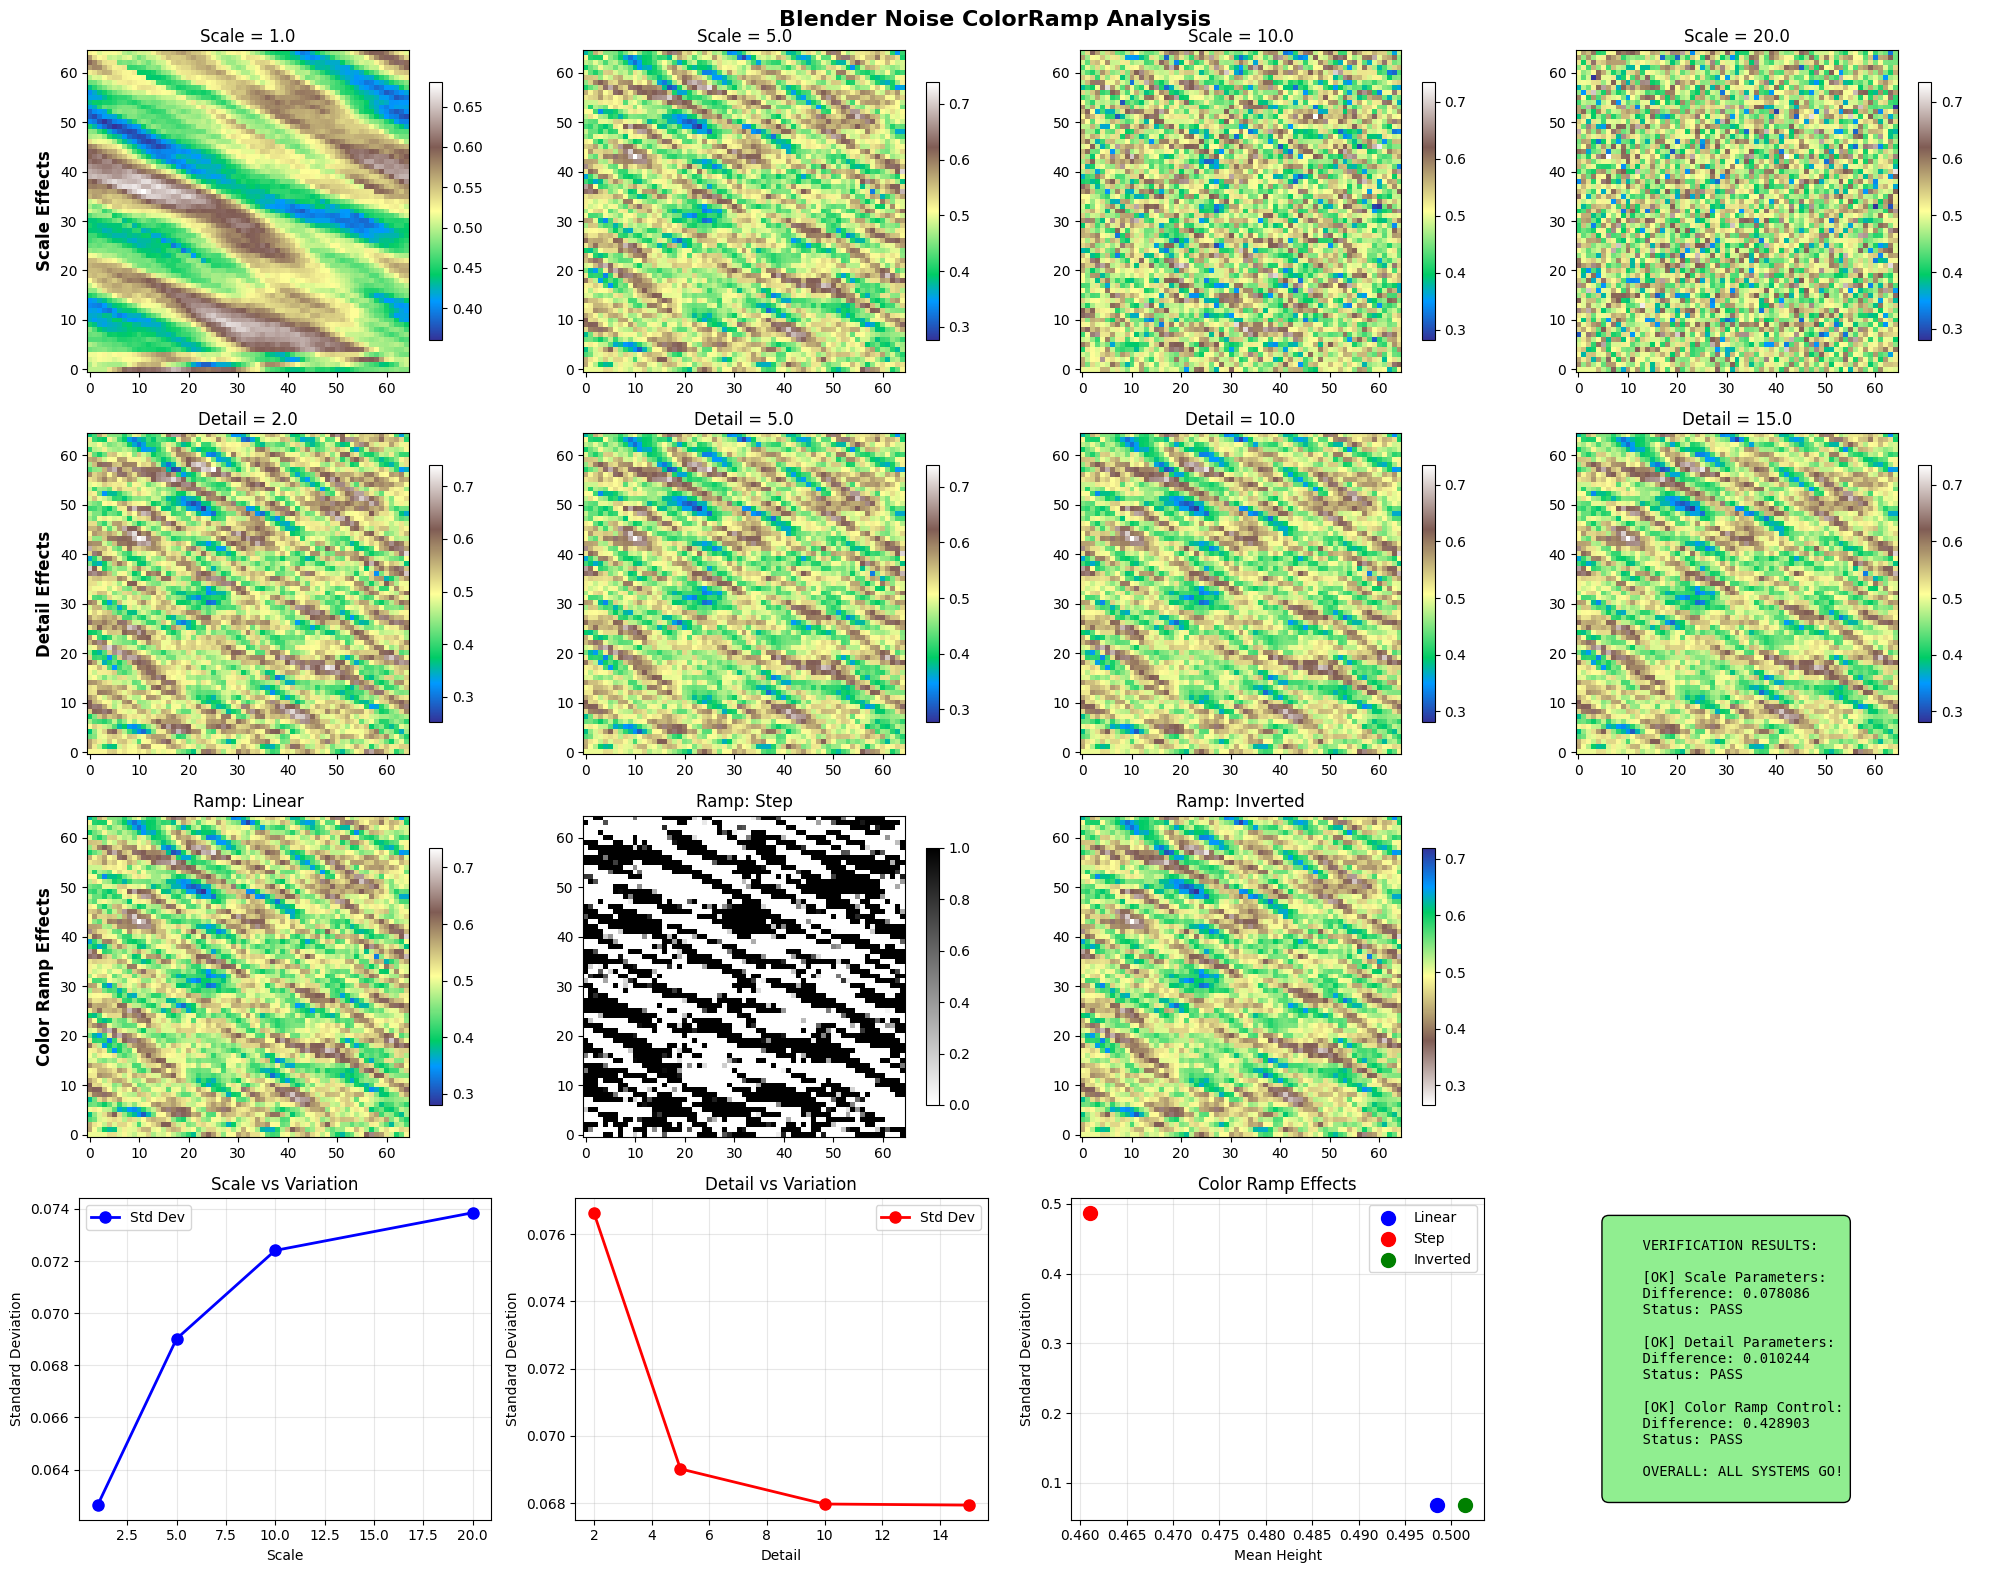


📊 ANALYSIS SUMMARY:
Scale control: [OK] WORKING
Detail control: [OK] WORKING
Color ramp control: [OK] WORKING

2. Running 3D surface comparison...


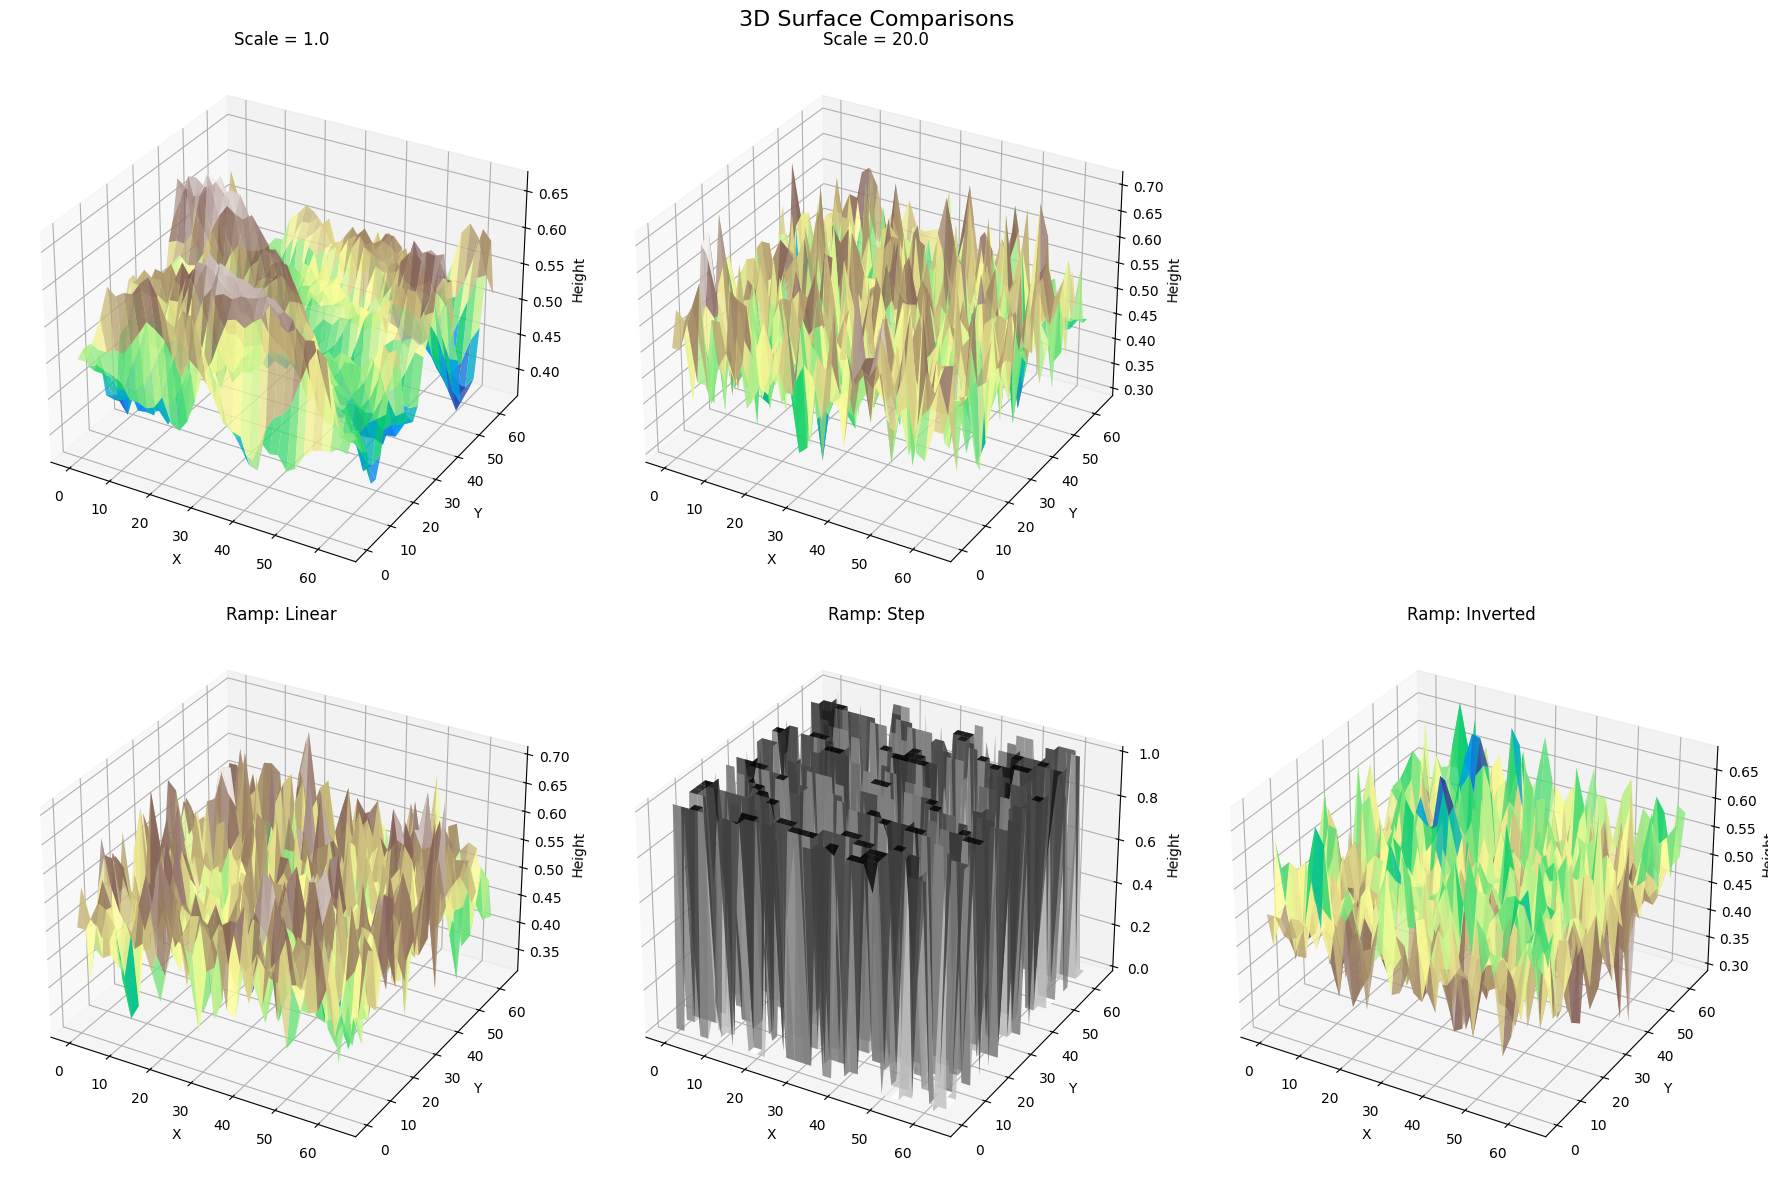


3. Running detailed characteristics analysis...


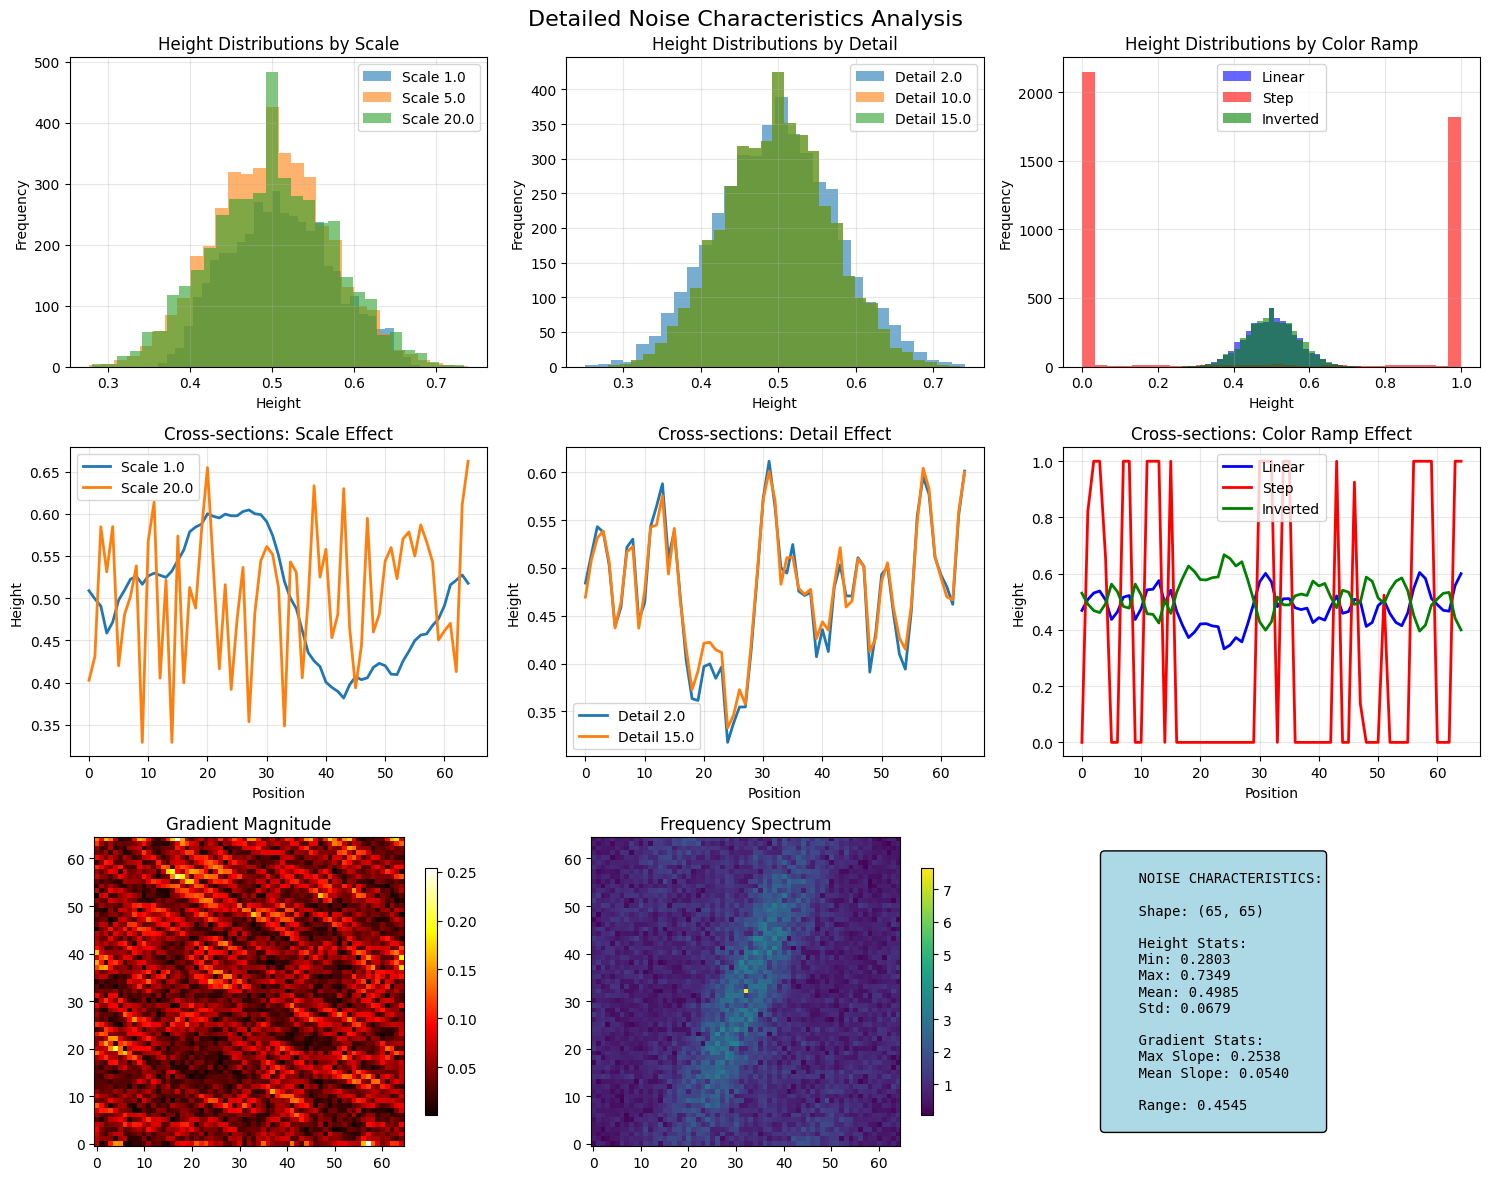


4. Running quick single sample visualization...


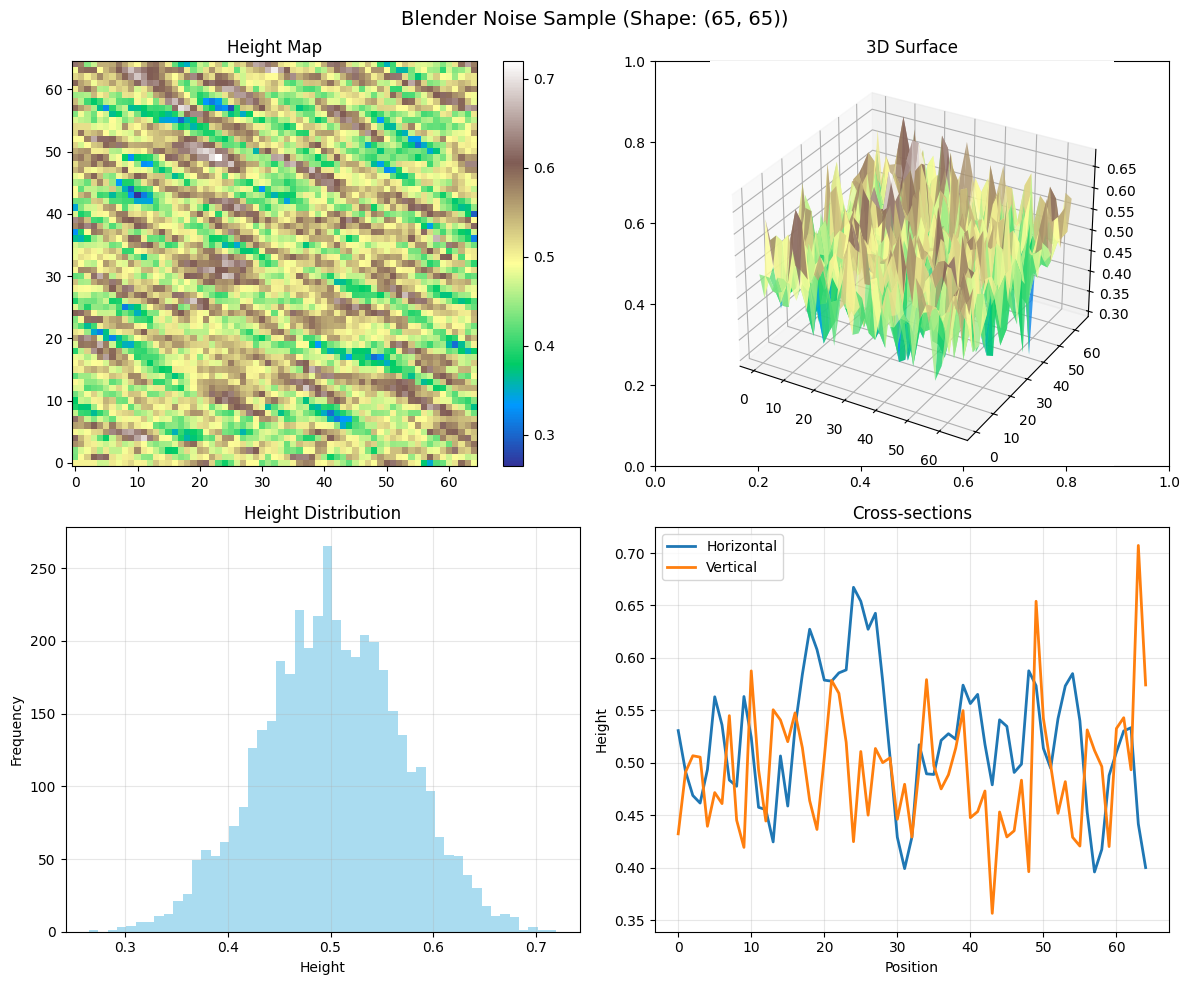

📊 Quick Stats:
Shape: (65, 65)
Range: [0.2651, 0.7197]
Mean: 0.5015
Std: 0.0679

✅ All visualizations complete!
Generated files:
  - noise_colorramp_analysis.png
  - noise_3d_comparison.png
  - noise_characteristics_analysis.png
  - quick_noise_visualization.png


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

def visualize_colorramp_results():
    """Visualize the noise color ramp results"""
    
    try:
        results = torch.load('noise_colorramp_results.pt')
    except FileNotFoundError:
        print("❌ No color ramp results found!")
        print("Run the Blender color ramp script first.")
        return
    
    print("🎨 VISUALIZING COLOR RAMP NOISE RESULTS")
    print("=" * 60)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Scale comparison (top row)
    scale_results = results['scales']
    scales = list(scale_results.keys())
    
    for i, scale in enumerate(scales):
        ax = plt.subplot(4, 4, i + 1)
        noise = scale_results[scale].numpy()
        im = plt.imshow(noise, cmap='terrain', origin='lower')
        plt.title(f'Scale = {scale}')
        plt.colorbar(im, shrink=0.8)
        if i == 0:
            plt.ylabel('Scale Effects', fontsize=12, fontweight='bold')
    
    # 2. Detail comparison (second row)
    detail_results = results['details']
    details = list(detail_results.keys())
    
    for i, detail in enumerate(details):
        ax = plt.subplot(4, 4, 4 + i + 1)
        noise = detail_results[detail].numpy()
        im = plt.imshow(noise, cmap='terrain', origin='lower')
        plt.title(f'Detail = {detail}')
        plt.colorbar(im, shrink=0.8)
        if i == 0:
            plt.ylabel('Detail Effects', fontsize=12, fontweight='bold')
    
    # 3. Color ramp comparison (third row)
    ramp_results = results['color_ramps']
    ramp_names = list(ramp_results.keys())
    
    for i, ramp_name in enumerate(ramp_names):
        ax = plt.subplot(4, 4, 8 + i + 1)
        noise = ramp_results[ramp_name].numpy()
        
        # Use different colormaps to show the effect
        cmap = 'terrain' if ramp_name == 'linear' else ('binary' if ramp_name == 'step' else 'terrain_r')
        im = plt.imshow(noise, cmap=cmap, origin='lower')
        plt.title(f'Ramp: {ramp_name.title()}')
        plt.colorbar(im, shrink=0.8)
        if i == 0:
            plt.ylabel('Color Ramp Effects', fontsize=12, fontweight='bold')
    
    # 4. Statistical analysis (fourth row)
    
    # Scale effect on variation
    ax = plt.subplot(4, 4, 13)
    scale_stds = [scale_results[s].std().item() for s in scales]
    scale_means = [scale_results[s].mean().item() for s in scales]
    
    plt.plot(scales, scale_stds, 'bo-', linewidth=2, markersize=8, label='Std Dev')
    plt.xlabel('Scale')
    plt.ylabel('Standard Deviation')
    plt.title('Scale vs Variation')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Detail effect on variation
    ax = plt.subplot(4, 4, 14)
    detail_stds = [detail_results[d].std().item() for d in details]
    detail_means = [detail_results[d].mean().item() for d in details]
    
    plt.plot(details, detail_stds, 'ro-', linewidth=2, markersize=8, label='Std Dev')
    plt.xlabel('Detail')
    plt.ylabel('Standard Deviation')
    plt.title('Detail vs Variation')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Color ramp effect comparison
    ax = plt.subplot(4, 4, 15)
    ramp_stds = [ramp_results[name].std().item() for name in ramp_names]
    ramp_means = [ramp_results[name].mean().item() for name in ramp_names]
    
    colors = ['blue', 'red', 'green']
    for i, (name, std, mean) in enumerate(zip(ramp_names, ramp_stds, ramp_means)):
        plt.scatter(mean, std, c=colors[i], s=100, label=name.title())
    
    plt.xlabel('Mean Height')
    plt.ylabel('Standard Deviation')
    plt.title('Color Ramp Effects')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Verification status
    ax = plt.subplot(4, 4, 16)
    plt.axis('off')
    
    verification = results['verification']
    scale_diff = verification['scale_diff'].item()
    detail_diff = verification['detail_diff'].item()
    ramp_diff = verification['ramp_diff'].item()
    
    # Status checks
    scale_ok = scale_diff > 0.01
    detail_ok = detail_diff > 0.01
    ramp_ok = ramp_diff > 0.01
    
    status_text = f"""
    VERIFICATION RESULTS:
    
    [OK] Scale Parameters:
    Difference: {scale_diff:.6f}
    Status: {"PASS" if scale_ok else "FAIL"}
    
    [OK] Detail Parameters:
    Difference: {detail_diff:.6f}
    Status: {"PASS" if detail_ok else "FAIL"}
    
    [OK] Color Ramp Control:
    Difference: {ramp_diff:.6f}
    Status: {"PASS" if ramp_ok else "FAIL"}
    
    OVERALL: {"ALL SYSTEMS GO!" if all([scale_ok, detail_ok, ramp_ok]) else "ISSUES DETECTED"}
    """
    
    bg_color = "lightgreen" if all([scale_ok, detail_ok, ramp_ok]) else "lightcoral"
    plt.text(0.1, 0.5, status_text, fontsize=10, 
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor=bg_color))
    
    plt.suptitle('Blender Noise ColorRamp Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('noise_colorramp_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"\n📊 ANALYSIS SUMMARY:")
    print(f"Scale control: {'[OK] WORKING' if scale_ok else '[X] NOT WORKING'}")
    print(f"Detail control: {'[OK] WORKING' if detail_ok else '[X] NOT WORKING'}")
    print(f"Color ramp control: {'[OK] WORKING' if ramp_ok else '[X] NOT WORKING'}")

def compare_3d_surfaces():
    """Show 3D surface comparisons"""
    
    try:
        results = torch.load('noise_colorramp_results.pt')
    except FileNotFoundError:
        print("❌ No results found!")
        return
    
    fig = plt.figure(figsize=(18, 12))
    
    # Compare different scales in 3D
    scales = [1.0, 20.0]
    scale_results = results['scales']
    
    for i, scale in enumerate(scales):
        ax = fig.add_subplot(2, 3, i + 1, projection='3d')
        noise = scale_results[scale].numpy()
        
        # Create coordinate grids
        x = np.arange(noise.shape[1])
        y = np.arange(noise.shape[0])
        X, Y = np.meshgrid(x, y)
        
        # Subsample for performance
        step = max(1, noise.shape[0] // 32)
        X_sub = X[::step, ::step]
        Y_sub = Y[::step, ::step]
        noise_sub = noise[::step, ::step]
        
        surf = ax.plot_surface(X_sub, Y_sub, noise_sub, cmap='terrain', alpha=0.8)
        ax.set_title(f'Scale = {scale}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Height')
    
    # Compare different color ramps
    ramp_results = results['color_ramps']
    ramp_names = ['linear', 'step', 'inverted']
    
    for i, ramp_name in enumerate(ramp_names):
        ax = fig.add_subplot(2, 3, 3 + i + 1, projection='3d')
        noise = ramp_results[ramp_name].numpy()
        
        x = np.arange(noise.shape[1])
        y = np.arange(noise.shape[0])
        X, Y = np.meshgrid(x, y)
        
        step = max(1, noise.shape[0] // 32)
        X_sub = X[::step, ::step]
        Y_sub = Y[::step, ::step]
        noise_sub = noise[::step, ::step]
        
        cmap = 'terrain' if ramp_name == 'linear' else ('binary' if ramp_name == 'step' else 'terrain_r')
        surf = ax.plot_surface(X_sub, Y_sub, noise_sub, cmap=cmap, alpha=0.8)
        ax.set_title(f'Ramp: {ramp_name.title()}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Height')
    
    plt.suptitle('3D Surface Comparisons', fontsize=16)
    plt.tight_layout()
    plt.savefig('noise_3d_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

def analyze_noise_characteristics():
    """Detailed analysis of noise characteristics"""
    
    try:
        results = torch.load('noise_colorramp_results.pt')
    except FileNotFoundError:
        print("❌ No results found!")
        return
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    # 1. Height distributions for different scales
    scale_results = results['scales']
    ax = axes[0, 0]
    for scale in [1.0, 5.0, 20.0]:
        noise = scale_results[scale].numpy().flatten()
        ax.hist(noise, bins=30, alpha=0.6, label=f'Scale {scale}')
    ax.set_title('Height Distributions by Scale')
    ax.set_xlabel('Height')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Height distributions for different details
    detail_results = results['details']
    ax = axes[0, 1]
    for detail in [2.0, 10.0, 15.0]:
        noise = detail_results[detail].numpy().flatten()
        ax.hist(noise, bins=30, alpha=0.6, label=f'Detail {detail}')
    ax.set_title('Height Distributions by Detail')
    ax.set_xlabel('Height')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Color ramp effect on distributions
    ramp_results = results['color_ramps']
    ax = axes[0, 2]
    colors = ['blue', 'red', 'green']
    for i, (name, color) in enumerate(zip(['linear', 'step', 'inverted'], colors)):
        noise = ramp_results[name].numpy().flatten()
        ax.hist(noise, bins=30, alpha=0.6, label=name.title(), color=color)
    ax.set_title('Height Distributions by Color Ramp')
    ax.set_xlabel('Height')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Cross-sections for scale comparison
    ax = axes[1, 0]
    for scale in [1.0, 20.0]:
        noise = scale_results[scale].numpy()
        mid_row = noise[noise.shape[0] // 2, :]
        ax.plot(mid_row, label=f'Scale {scale}', linewidth=2)
    ax.set_title('Cross-sections: Scale Effect')
    ax.set_xlabel('Position')
    ax.set_ylabel('Height')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. Cross-sections for detail comparison
    ax = axes[1, 1]
    for detail in [2.0, 15.0]:
        noise = detail_results[detail].numpy()
        mid_row = noise[noise.shape[0] // 2, :]
        ax.plot(mid_row, label=f'Detail {detail}', linewidth=2)
    ax.set_title('Cross-sections: Detail Effect')
    ax.set_xlabel('Position')
    ax.set_ylabel('Height')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 6. Cross-sections for color ramp comparison
    ax = axes[1, 2]
    colors = ['blue', 'red', 'green']
    for i, (name, color) in enumerate(zip(['linear', 'step', 'inverted'], colors)):
        noise = ramp_results[name].numpy()
        mid_row = noise[noise.shape[0] // 2, :]
        ax.plot(mid_row, label=name.title(), linewidth=2, color=color)
    ax.set_title('Cross-sections: Color Ramp Effect')
    ax.set_xlabel('Position')
    ax.set_ylabel('Height')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 7. Gradient analysis
    ax = axes[2, 0]
    linear_noise = ramp_results['linear'].numpy()
    gy, gx = np.gradient(linear_noise)
    gradient_mag = np.sqrt(gx**2 + gy**2)
    im = ax.imshow(gradient_mag, cmap='hot', origin='lower')
    ax.set_title('Gradient Magnitude')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    # 8. Frequency analysis (2D FFT)
    ax = axes[2, 1]
    fft = np.fft.fft2(linear_noise)
    fft_mag = np.log(np.abs(np.fft.fftshift(fft)) + 1)
    im = ax.imshow(fft_mag, cmap='viridis', origin='lower')
    ax.set_title('Frequency Spectrum')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    # 9. Statistics summary
    ax = axes[2, 2]
    ax.axis('off')
    
    # Calculate some statistics
    linear_noise = ramp_results['linear'].numpy()
    stats_text = f"""
    NOISE CHARACTERISTICS:
    
    Shape: {linear_noise.shape}
    
    Height Stats:
    Min: {linear_noise.min():.4f}
    Max: {linear_noise.max():.4f}
    Mean: {linear_noise.mean():.4f}
    Std: {linear_noise.std():.4f}
    
    Gradient Stats:
    Max Slope: {gradient_mag.max():.4f}
    Mean Slope: {gradient_mag.mean():.4f}
    
    Range: {linear_noise.max() - linear_noise.min():.4f}
    """
    
    ax.text(0.1, 0.5, stats_text, fontsize=10,
            verticalalignment='center', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    plt.suptitle('Detailed Noise Characteristics Analysis', fontsize=16)
    plt.tight_layout()
    plt.savefig('noise_characteristics_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

def quick_single_visualization():
    """Quick visualization of a single noise sample"""
    
    try:
        # Try to load the single sample
        noise = np.load('blender_noise_colorramp.npy')
    except FileNotFoundError:
        print("❌ No single noise sample found!")
        print("Run the Blender script first to generate 'blender_noise_colorramp.npy'")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Height map
    im1 = axes[0, 0].imshow(noise, cmap='terrain', origin='lower')
    axes[0, 0].set_title('Height Map')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # 3D surface (subsampled)
    ax_3d = fig.add_subplot(2, 2, 2, projection='3d')
    step = max(1, noise.shape[0] // 32)
    x = np.arange(0, noise.shape[1], step)
    y = np.arange(0, noise.shape[0], step)
    X, Y = np.meshgrid(x, y)
    Z = noise[::step, ::step]
    
    surf = ax_3d.plot_surface(X, Y, Z, cmap='terrain', alpha=0.8)
    ax_3d.set_title('3D Surface')
    
    # Height distribution
    axes[1, 0].hist(noise.flatten(), bins=50, alpha=0.7, color='skyblue')
    axes[1, 0].set_title('Height Distribution')
    axes[1, 0].set_xlabel('Height')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Cross-section
    mid_row = noise[noise.shape[0] // 2, :]
    mid_col = noise[:, noise.shape[1] // 2]
    axes[1, 1].plot(mid_row, label='Horizontal', linewidth=2)
    axes[1, 1].plot(mid_col, label='Vertical', linewidth=2)
    axes[1, 1].set_title('Cross-sections')
    axes[1, 1].set_xlabel('Position')
    axes[1, 1].set_ylabel('Height')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Blender Noise Sample (Shape: {noise.shape})', fontsize=14)
    plt.tight_layout()
    plt.savefig('quick_noise_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Quick Stats:")
    print(f"Shape: {noise.shape}")
    print(f"Range: [{noise.min():.4f}, {noise.max():.4f}]")
    print(f"Mean: {noise.mean():.4f}")
    print(f"Std: {noise.std():.4f}")

if __name__ == "__main__":
    print("🎨 BLENDER NOISE VISUALIZATION SUITE")
    print("=" * 60)
    
    # Try comprehensive analysis first
    print("1. Running comprehensive analysis...")
    visualize_colorramp_results()
    
    print("\n2. Running 3D surface comparison...")
    compare_3d_surfaces()
    
    print("\n3. Running detailed characteristics analysis...")
    analyze_noise_characteristics()
    
    print("\n4. Running quick single sample visualization...")
    quick_single_visualization()
    
    print("\n✅ All visualizations complete!")
    print("Generated files:")
    print("  - noise_colorramp_analysis.png")
    print("  - noise_3d_comparison.png")
    print("  - noise_characteristics_analysis.png")
    print("  - quick_noise_visualization.png")

# hole detection 

🚀 EXAMPLE: BLOB HOLE DETECTION
✓ Loaded Blender noise: (65, 65)

1️⃣ Single threshold test:
🔍 BLOB HOLE DETECTION
Noise shape: (65, 65)
Noise range: [0.2651, 0.7197]
Threshold: 0.5354
White pixels (above threshold): 1336/4225 (31.6%)
Found 167 separate blob(s)
  Blob 1: 4 pixels, no holes ✓
  Blob 2: 1 pixels, no holes ✓
  Blob 3: 7 pixels, no holes ✓
  Blob 4: 14 pixels, no holes ✓
  Blob 5: 2 pixels, no holes ✓
  Blob 6: 3 pixels, no holes ✓
  Blob 7: 1 pixels, no holes ✓
  Blob 8: 1 pixels, no holes ✓
  Blob 9: 2 pixels, no holes ✓
  Blob 10: 1 pixels, no holes ✓
  Blob 11: 2 pixels, no holes ✓
  Blob 12: 4 pixels, no holes ✓
  Blob 13: 4 pixels, no holes ✓
  Blob 14: 124 pixels, 1 hole pixels ❌
  Blob 15: 4 pixels, no holes ✓
  Blob 16: 3 pixels, no holes ✓
  Blob 17: 3 pixels, no holes ✓
  Blob 18: 1 pixels, no holes ✓
  Blob 19: 1 pixels, no holes ✓
  Blob 20: 1 pixels, no holes ✓
  Blob 21: 18 pixels, no holes ✓
  Blob 22: 10 pixels, no holes ✓
  Blob 23: 1 pixels, no holes ✓
  

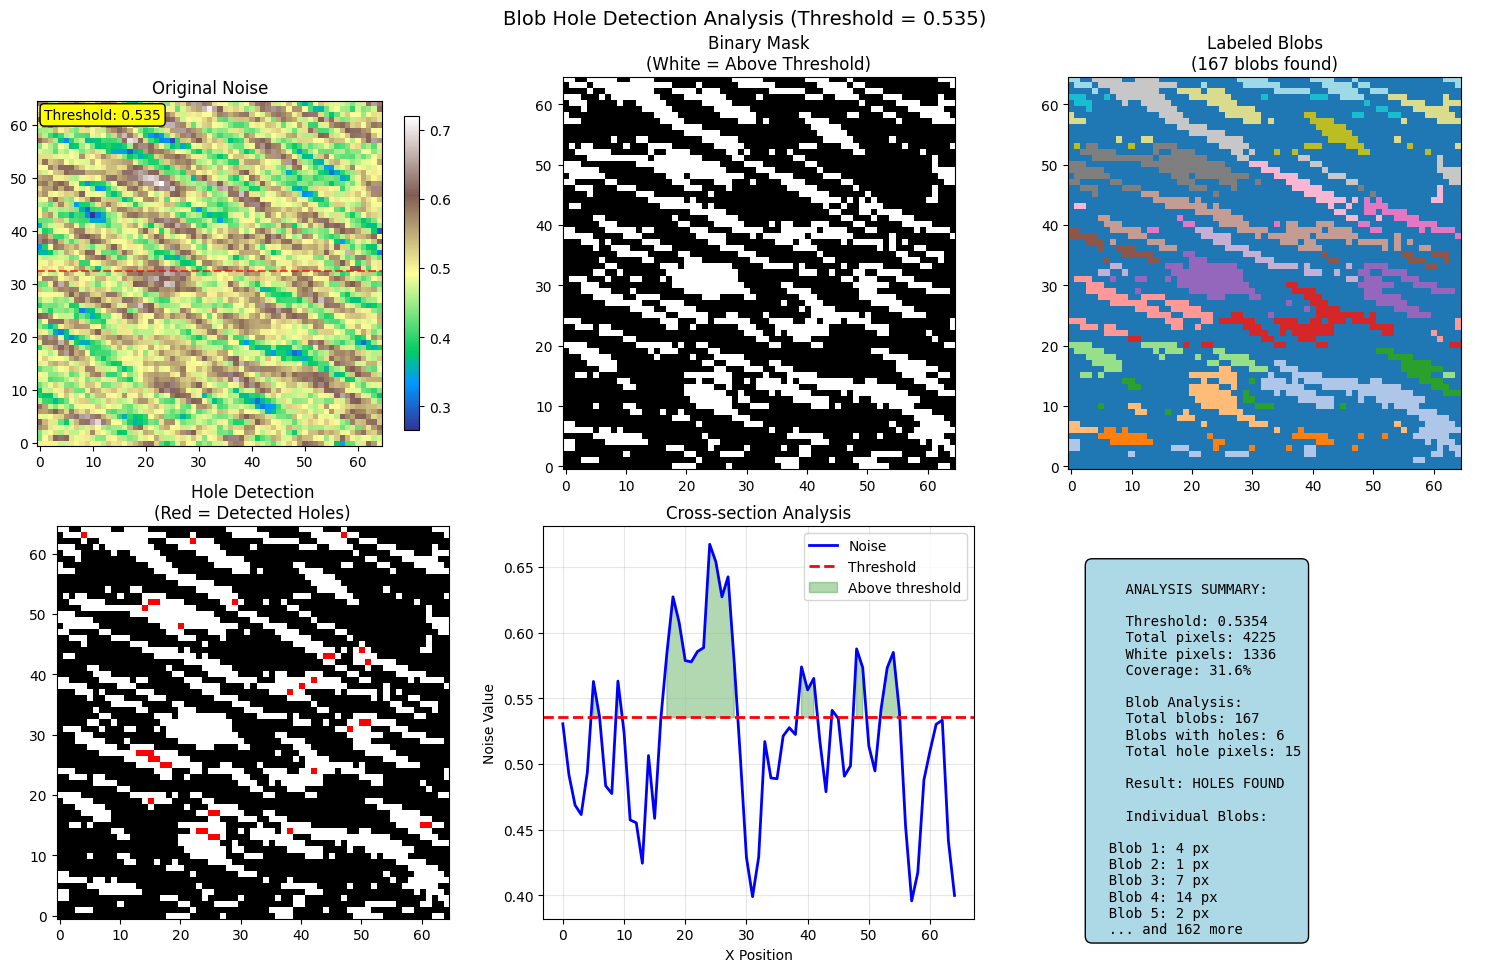

Single test result: Holes detected

2️⃣ Multiple threshold test:
🧪 TESTING MULTIPLE THRESHOLDS
Thresholds: ['0.311', '0.371', '0.432', '0.492', '0.553', '0.614', '0.674']

📍 Test 1/7 - Threshold: 0.3106
----------------------------------------
🔍 BLOB HOLE DETECTION
Noise shape: (65, 65)
Noise range: [0.2651, 0.7197]
Threshold: 0.3106
White pixels (above threshold): 4216/4225 (99.8%)
Found 1 separate blob(s)
  Blob 1: 4216 pixels, 8 hole pixels ❌

RESULT:
  Detection method: Holes detected
  Contour method: Holes detected
  Final: ❌ HOLES DETECTED
Result: ❌ HOLES FOUND

📍 Test 2/7 - Threshold: 0.3712
----------------------------------------
🔍 BLOB HOLE DETECTION
Noise shape: (65, 65)
Noise range: [0.2651, 0.7197]
Threshold: 0.3712
White pixels (above threshold): 4104/4225 (97.1%)
Found 1 separate blob(s)
  Blob 1: 4104 pixels, 110 hole pixels ❌

RESULT:
  Detection method: Holes detected
  Contour method: Holes detected
  Final: ❌ HOLES DETECTED
Result: ❌ HOLES FOUND

📍 Test 3/7 - Thres

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology, measure
import cv2

def detect_holes_in_blobs(noise_tensor, threshold, visualize=True):
    """
    Take noise function and threshold to create binary mask,
    then detect if there are holes in the white blobs.
    
    Args:
        noise_tensor: 2D tensor/array of noise values
        threshold: threshold value to binarize the noise
        visualize: whether to show visualization
    
    Returns:
        bool: True if NO holes are found in blobs, False if holes exist
    """
    
    # Convert to numpy if tensor
    if torch.is_tensor(noise_tensor):
        noise = noise_tensor.numpy()
    else:
        noise = noise_tensor
    
    print(f"🔍 BLOB HOLE DETECTION")
    print(f"Noise shape: {noise.shape}")
    print(f"Noise range: [{noise.min():.4f}, {noise.max():.4f}]")
    print(f"Threshold: {threshold:.4f}")
    
    # Create binary mask: white (True) for values above threshold
    binary_mask = noise > threshold
    white_pixels = binary_mask.sum()
    total_pixels = binary_mask.size
    
    print(f"White pixels (above threshold): {white_pixels}/{total_pixels} ({100*white_pixels/total_pixels:.1f}%)")
    
    if white_pixels == 0:
        print("❌ No white pixels found - threshold too high")
        return True  # No blobs = no holes
    
    # Find connected components (blobs)
    labeled_blobs, num_blobs = ndimage.label(binary_mask)
    print(f"Found {num_blobs} separate blob(s)")
    
    if num_blobs == 0:
        return True  # No blobs = no holes
    
    # Check each blob for holes
    holes_found = False
    blob_info = []
    
    for blob_id in range(1, num_blobs + 1):
        # Extract single blob
        single_blob = (labeled_blobs == blob_id)
        blob_size = single_blob.sum()
        
        # Method 1: Detect holes by checking what would be filled
        # Compare original blob with what it would look like if holes were filled
        would_be_filled = ndimage.binary_fill_holes(single_blob)
        hole_pixels = would_be_filled.sum() - blob_size  # How many pixels would be added
        has_holes = hole_pixels > 0
        
        blob_info.append({
            'id': blob_id,
            'size': blob_size,
            'hole_pixels': hole_pixels,
            'has_holes': has_holes
        })
        
        if has_holes:
            holes_found = True
            print(f"  Blob {blob_id}: {blob_size} pixels, {hole_pixels} hole pixels ❌")
        else:
            print(f"  Blob {blob_id}: {blob_size} pixels, no holes ✓")
    
    # Alternative method using contours (more robust)
    holes_found_contour = check_holes_with_contours(binary_mask.astype(np.uint8))
    
    # Final result - use more conservative approach
    final_result = not (holes_found or holes_found_contour)
    
    print(f"\nRESULT:")
    print(f"  Detection method: {'No holes' if not holes_found else 'Holes detected'}")
    print(f"  Contour method: {'No holes' if not holes_found_contour else 'Holes detected'}")
    print(f"  Final: {'✓ NO HOLES' if final_result else '❌ HOLES DETECTED'}")
    
    if visualize:
        visualize_blob_analysis(noise, threshold, binary_mask, labeled_blobs, blob_info)
    
    return final_result

def check_holes_with_contours(binary_mask):
    """Alternative hole detection using OpenCV contours"""
    
    try:
        # Find contours
        contours, hierarchy = cv2.findContours(
            binary_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
        )
        
        if hierarchy is None:
            return False
        
        # Check hierarchy for holes
        # In RETR_CCOMP: hierarchy[i] = [next, prev, first_child, parent]
        # If first_child != -1, this contour has holes
        holes_found = False
        for i, h in enumerate(hierarchy[0]):
            if h[2] != -1:  # has child contour (hole)
                holes_found = True
                break
        
        return holes_found
        
    except Exception as e:
        print(f"Contour method failed: {e}")
        return False

def visualize_blob_analysis(noise, threshold, binary_mask, labeled_blobs, blob_info):
    """Visualize the blob analysis process"""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Original noise
    im1 = axes[0, 0].imshow(noise, cmap='terrain', origin='lower')
    axes[0, 0].axhline(y=noise.shape[0]/2, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('Original Noise')
    plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)
    
    # Add threshold line to colorbar area
    axes[0, 0].text(0.02, 0.98, f'Threshold: {threshold:.3f}', 
                   transform=axes[0, 0].transAxes, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"),
                   verticalalignment='top')
    
    # 2. Binary mask
    axes[0, 1].imshow(binary_mask, cmap='gray', origin='lower')
    axes[0, 1].set_title('Binary Mask\n(White = Above Threshold)')
    
    # 3. Labeled blobs
    axes[0, 2].imshow(labeled_blobs, cmap='tab20', origin='lower')
    axes[0, 2].set_title(f'Labeled Blobs\n({len(blob_info)} blobs found)')
    
    # 4. Hole detection visualization
    # Show where holes would be (for visualization only - we're not filling them!)
    would_be_filled = ndimage.binary_fill_holes(binary_mask)
    hole_locations = would_be_filled & ~binary_mask  # Where holes are located
    
    # Create RGB image to show original + detected hole locations
    rgb_image = np.zeros((*binary_mask.shape, 3))
    rgb_image[binary_mask] = [1, 1, 1]      # White for original blobs
    rgb_image[hole_locations] = [1, 0, 0]   # Red for detected hole locations
    
    axes[1, 0].imshow(rgb_image, origin='lower')
    axes[1, 0].set_title('Hole Detection\n(Red = Detected Holes)')
    
    # 5. Cross-section analysis
    mid_row = noise[noise.shape[0] // 2, :]
    x_coords = np.arange(len(mid_row))
    
    axes[1, 1].plot(x_coords, mid_row, 'b-', linewidth=2, label='Noise')
    axes[1, 1].axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
    axes[1, 1].fill_between(x_coords, threshold, mid_row, 
                           where=(mid_row > threshold), alpha=0.3, color='green', label='Above threshold')
    axes[1, 1].set_title('Cross-section Analysis')
    axes[1, 1].set_xlabel('X Position')
    axes[1, 1].set_ylabel('Noise Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Statistics summary
    axes[1, 2].axis('off')
    
    total_holes = sum([info['hole_pixels'] for info in blob_info])
    blobs_with_holes = sum([1 for info in blob_info if info['has_holes']])
    
    stats_text = f"""
    ANALYSIS SUMMARY:
    
    Threshold: {threshold:.4f}
    Total pixels: {binary_mask.size}
    White pixels: {binary_mask.sum()}
    Coverage: {100*binary_mask.sum()/binary_mask.size:.1f}%
    
    Blob Analysis:
    Total blobs: {len(blob_info)}
    Blobs with holes: {blobs_with_holes}
    Total hole pixels: {total_holes}
    
    Result: {"NO HOLES" if total_holes == 0 else "HOLES FOUND"}
    
    Individual Blobs:
    """
    
    for info in blob_info[:5]:  # Show first 5 blobs
        stats_text += f"\n  Blob {info['id']}: {info['size']} px"
        if info['has_holes']:
            stats_text += f" ({info['hole_pixels']} holes)"
    
    if len(blob_info) > 5:
        stats_text += f"\n  ... and {len(blob_info)-5} more"
    
    axes[1, 2].text(0.1, 0.9, stats_text, fontsize=10,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue"))
    
    plt.suptitle(f'Blob Hole Detection Analysis (Threshold = {threshold:.3f})', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'blob_analysis_thresh_{threshold:.3f}.png', dpi=150, bbox_inches='tight')
    plt.show()

def test_different_thresholds(noise_tensor, thresholds=None):
    """Test hole detection across multiple threshold values"""
    
    if thresholds is None:
        # Auto-generate thresholds based on noise range
        if torch.is_tensor(noise_tensor):
            noise = noise_tensor.numpy()
        else:
            noise = noise_tensor
            
        min_val, max_val = noise.min(), noise.max()
        thresholds = np.linspace(min_val + 0.1*(max_val-min_val), 
                                max_val - 0.1*(max_val-min_val), 
                                7)
    
    print(f"🧪 TESTING MULTIPLE THRESHOLDS")
    print(f"Thresholds: {[f'{t:.3f}' for t in thresholds]}")
    print("=" * 60)
    
    results = []
    
    for i, thresh in enumerate(thresholds):
        print(f"\n📍 Test {i+1}/{len(thresholds)} - Threshold: {thresh:.4f}")
        print("-" * 40)
        
        no_holes = detect_holes_in_blobs(noise_tensor, thresh, visualize=False)
        
        results.append({
            'threshold': thresh,
            'no_holes': no_holes,
            'status': 'PASS' if no_holes else 'FAIL'
        })
        
        print(f"Result: {'✓ NO HOLES' if no_holes else '❌ HOLES FOUND'}")
    
    # Summary
    print(f"\n📊 THRESHOLD TEST SUMMARY:")
    print("=" * 60)
    
    for result in results:
        status_symbol = "✓" if result['no_holes'] else "❌"
        print(f"Threshold {result['threshold']:.4f}: {status_symbol} {result['status']}")
    
    # Find good thresholds
    good_thresholds = [r['threshold'] for r in results if r['no_holes']]
    
    if good_thresholds:
        print(f"\n🎯 GOOD THRESHOLDS (no holes): {len(good_thresholds)}/{len(thresholds)}")
        print(f"Range: [{min(good_thresholds):.4f}, {max(good_thresholds):.4f}]")
    else:
        print(f"\n⚠️  NO THRESHOLDS FOUND WITHOUT HOLES")
    
    return results

# Example usage and testing
def example_usage():
    """Example of how to use the hole detection function"""
    
    print("🚀 EXAMPLE: BLOB HOLE DETECTION")
    print("=" * 50)
    
    # Load your noise data
    try:
        # Try to load from your Blender output
        noise = np.load('blender_noise_colorramp.npy')
        print(f"✓ Loaded Blender noise: {noise.shape}")
    except FileNotFoundError:
        # Generate synthetic noise for demo
        print("! No Blender noise found, generating synthetic data")
        noise = np.random.random((64, 64)) * 0.5 + 0.25
        # Add some structure
        x, y = np.mgrid[0:64, 0:64]
        noise += 0.3 * np.exp(-((x-32)**2 + (y-32)**2) / 200)
    
    # Test single threshold
    print(f"\n1️⃣ Single threshold test:")
    threshold = np.mean(noise) + 0.5 * np.std(noise)
    result = detect_holes_in_blobs(noise, threshold, visualize=True)
    print(f"Single test result: {'No holes found' if result else 'Holes detected'}")
    
    # Test multiple thresholds
    print(f"\n2️⃣ Multiple threshold test:")
    test_results = test_different_thresholds(noise)
    
    return result, test_results

if __name__ == "__main__":
    # Run the example
    result, test_results = example_usage()

## Blender Actions

In [16]:
import numpy as np
import torch
import bpy
from typing import Dict, List, Tuple, Optional

class BlenderColorRampEnvironment:
    """
    Blender environment for building color ramps through sequential actions.
    
    Action Space:
    - First action: Choose noise scale from predefined values
    - Subsequent actions: Add colors (1-32) at available positions (1/n, 2/n, ..., n/n)
    """
    
    def __init__(self, 
                 max_colors: int = 5,
                 num_color_choices: int = 32,
                 available_scales: List[float] = None,
                 plane_name: str = "Plane",
                 modifier_name: str = "GeometryNodes"):
        
        self.max_colors = max_colors
        self.num_color_choices = num_color_choices  # 32 possible colors
        self.plane_name = plane_name
        self.modifier_name = modifier_name
        
        # Default noise scales if not provided
        if available_scales is None:
            self.available_scales = [0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0]
        else:
            self.available_scales = available_scales
        
        # State tracking
        self.reset()
        
        # Blender objects (set when environment is initialized)
        self.plane = None
        self.modifier = None
        self.created_nodes = None
        
        print(f"🎮 Blender ColorRamp Environment initialized:")
        print(f"  Max colors: {max_colors}")
        print(f"  Color choices: {num_color_choices}")
        print(f"  Available scales: {len(self.available_scales)}")
        print(f"  Position slots: {max_colors}")
    
    def reset(self) -> Dict:
        """Reset environment to initial state"""
        
        self.step_count = 0
        self.scale_chosen = False
        self.noise_scale = None
        
        # Color ramp state: position -> color_id
        # Positions are at 1/n, 2/n, 3/n, ..., n/n where n = max_colors
        self.color_positions = {}  # {position_index: color_id}
        self.occupied_positions = set()
        
        # Available positions (0, 1, 2, ..., max_colors-1 corresponding to 1/n, 2/n, ..., n/n)
        self.available_positions = set(range(self.max_colors))
        
        self.done = False
        
        return self.get_state()
    
    def get_action_space_info(self) -> Dict:
        """Get information about the action space"""
        
        if not self.scale_chosen:
            # First action: choose scale
            return {
                'action_type': 'choose_scale',
                'num_actions': len(self.available_scales),
                'available_scales': self.available_scales,
                'description': f'Choose noise scale from {len(self.available_scales)} options'
            }
        else:
            # Subsequent actions: add color at position
            num_position_color_combinations = len(self.available_positions) * self.num_color_choices
            return {
                'action_type': 'add_color',
                'num_actions': num_position_color_combinations,
                'available_positions': list(self.available_positions),
                'num_color_choices': self.num_color_choices,
                'description': f'Choose from {len(self.available_positions)} positions × {self.num_color_choices} colors = {num_position_color_combinations} actions'
            }
    
    def get_state(self) -> Dict:
        """Get current environment state"""
        
        return {
            'step_count': self.step_count,
            'scale_chosen': self.scale_chosen,
            'noise_scale': self.noise_scale,
            'color_positions': self.color_positions.copy(),
            'occupied_positions': list(self.occupied_positions),
            'available_positions': list(self.available_positions),
            'colors_placed': len(self.color_positions),
            'max_colors': self.max_colors,
            'done': self.done
        }
    
    def action_to_scale(self, action: int) -> float:
        """Convert action index to scale value"""
        if 0 <= action < len(self.available_scales):
            return self.available_scales[action]
        else:
            raise ValueError(f"Invalid scale action {action}, must be 0-{len(self.available_scales)-1}")
    
    def action_to_position_color(self, action: int) -> Tuple[int, int]:
        """Convert action index to (position_index, color_id)"""
        if len(self.available_positions) == 0:
            raise ValueError("No available positions for color placement")
        
        num_positions = len(self.available_positions)
        position_idx = action // self.num_color_choices
        color_id = action % self.num_color_choices
        
        if position_idx >= num_positions:
            raise ValueError(f"Invalid action {action}: position index {position_idx} >= {num_positions}")
        
        # Convert to actual position index
        available_pos_list = sorted(list(self.available_positions))
        actual_position = available_pos_list[position_idx]
        
        return actual_position, color_id
    
    def position_index_to_normalized(self, position_index: int) -> float:
        """Convert position index to normalized position (0.0 to 1.0)"""
        return (position_index + 1) / self.max_colors
    
    def color_id_to_rgb(self, color_id: int) -> Tuple[float, float, float, float]:
        """Convert color ID (0-31) to RGBA values"""
        
        # Create 32 distinct colors
        if color_id == 0:
            return (0.0, 0.0, 0.0, 1.0)  # Black
        elif color_id == 1:
            return (1.0, 1.0, 1.0, 1.0)  # White
        elif color_id < 8:
            # Primary colors
            colors = [
                (1.0, 0.0, 0.0, 1.0),  # Red
                (0.0, 1.0, 0.0, 1.0),  # Green
                (0.0, 0.0, 1.0, 1.0),  # Blue
                (1.0, 1.0, 0.0, 1.0),  # Yellow
                (1.0, 0.0, 1.0, 1.0),  # Magenta
                (0.0, 1.0, 1.0, 1.0),  # Cyan
            ]
            return colors[color_id - 2]
        else:
            # Generate systematic colors for remaining IDs
            # Use HSV color space for better distribution
            hue = ((color_id - 8) / (32 - 8)) * 360
            saturation = 0.8 if color_id % 2 == 0 else 1.0
            value = 0.9 if color_id % 3 == 0 else 0.7
            
            # Convert HSV to RGB (simple approximation)
            import colorsys
            r, g, b = colorsys.hsv_to_rgb(hue/360, saturation, value)
            return (r, g, b, 1.0)
    
    def step(self, action: int) -> Tuple[Dict, float, bool, Dict]:
        """
        Take an action in the environment
        
        Returns:
            state, reward, done, info
        """
        
        if self.done:
            raise ValueError("Environment is done, call reset() first")
        
        info = {'action_taken': action}
        
        try:
            if not self.scale_chosen:
                # First action: choose scale
                self.noise_scale = self.action_to_scale(action)
                self.scale_chosen = True
                info['scale_chosen'] = self.noise_scale
                
                # Apply scale to Blender
                if self.created_nodes:
                    self._apply_noise_scale(self.noise_scale)
                
                print(f"🎛️ Step {self.step_count}: Chose noise scale {self.noise_scale}")
                
            else:
                # Subsequent actions: add color at position
                position_idx, color_id = self.action_to_position_color(action)
                
                if position_idx not in self.available_positions:
                    # Invalid action - position already occupied
                    info['error'] = f'Position {position_idx} already occupied'
                    return self.get_state(), -1.0, self.done, info
                
                # Add color to position
                self.color_positions[position_idx] = color_id
                self.occupied_positions.add(position_idx)
                self.available_positions.remove(position_idx)
                
                # Apply to Blender
                if self.created_nodes:
                    self._apply_color_ramp()
                
                normalized_pos = self.position_index_to_normalized(position_idx)
                rgba = self.color_id_to_rgb(color_id)
                
                print(f"🎨 Step {self.step_count}: Added color {color_id} (RGBA={rgba[:3]}) at position {normalized_pos:.3f}")
                
                info['position_added'] = position_idx
                info['color_added'] = color_id
                info['normalized_position'] = normalized_pos
                info['rgba'] = rgba
            
            self.step_count += 1
            
            # Check if done (all positions filled or max steps reached)
            if len(self.available_positions) == 0 or self.step_count >= self.max_colors + 1:
                self.done = True
            
            # Calculate reward (placeholder - implement your reward function)
            reward = self._calculate_reward()
            
            return self.get_state(), reward, self.done, info
            
        except Exception as e:
            info['error'] = str(e)
            return self.get_state(), -1.0, self.done, info
    
    def _apply_noise_scale(self, scale: float):
        """Apply noise scale to Blender"""
        if 'noise' in self.created_nodes:
            noise_node = self.created_nodes['noise']
            noise_node.inputs['Scale'].default_value = scale
            bpy.context.view_layer.update()
    
    def _apply_color_ramp(self):
        """Apply current color ramp state to Blender"""
        if 'ramp' not in self.created_nodes:
            return
        
        ramp_node = self.created_nodes['ramp']
        color_ramp = ramp_node.color_ramp
        
        # Clear existing points
        while len(color_ramp.elements) > 0:
            color_ramp.elements.remove(color_ramp.elements[0])
        
        # Add points based on current state
        if len(self.color_positions) == 0:
            # Add default black and white
            elem0 = color_ramp.elements.new(0.0)
            elem0.color = (0, 0, 0, 1)
            elem1 = color_ramp.elements.new(1.0)
            elem1.color = (1, 1, 1, 1)
        else:
            # Sort positions and add colors
            sorted_positions = sorted(self.color_positions.items())
            
            for position_idx, color_id in sorted_positions:
                normalized_pos = self.position_index_to_normalized(position_idx)
                rgba = self.color_id_to_rgb(color_id)
                
                elem = color_ramp.elements.new(normalized_pos)
                elem.color = rgba
        
        bpy.context.view_layer.update()
    
    def _calculate_reward(self) -> float:
        """Calculate reward for current state (implement your logic here)"""
        
        # Placeholder reward function
        if not self.scale_chosen:
            return 0.1  # Small reward for choosing scale
        
        # Reward for adding colors
        base_reward = 0.5
        
        # Bonus for having more colors (exploration)
        color_bonus = len(self.color_positions) * 0.1
        
        # You can add hole detection here:
        # if self.done:
        #     tensor = self.get_current_noise_tensor()
        #     no_holes = detect_holes_in_blobs(tensor, threshold=0.5)
        #     if no_holes:
        #         return base_reward + color_bonus + 1.0  # Big bonus for no holes
        #     else:
        #         return base_reward + color_bonus - 0.5  # Penalty for holes
        
        return base_reward + color_bonus
    
    def get_current_noise_tensor(self, resolution: int = 64) -> torch.Tensor:
        """Get current noise tensor from Blender"""
        if not self.plane:
            raise ValueError("Blender environment not initialized")
        
        # Force update
        bpy.context.view_layer.update()
        
        # Extract tensor (similar to your existing code)
        depsgraph = bpy.context.evaluated_depsgraph_get()
        plane_eval = self.plane.evaluated_get(depsgraph)
        mesh = plane_eval.to_mesh()
        
        verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
        grid_size = int(np.sqrt(len(verts)))
        heights = verts[:, 2].reshape(grid_size, grid_size)
        tensor = torch.from_numpy(heights).float()
        
        plane_eval.to_mesh_clear()
        return tensor
    
    def connect_to_blender(self, plane, modifier, created_nodes):
        """Connect environment to existing Blender setup"""
        self.plane = plane
        self.modifier = modifier
        self.created_nodes = created_nodes
        print("🔗 Connected to Blender environment")
    
    def render_current_state(self) -> str:
        """Render current state as string for debugging"""
        
        state_str = f"Step {self.step_count}:\n"
        
        if not self.scale_chosen:
            state_str += "  ⏳ Waiting for scale choice\n"
            state_str += f"  Available scales: {self.available_scales}\n"
        else:
            state_str += f"  🎛️ Noise scale: {self.noise_scale}\n"
            state_str += f"  🎨 Colors placed: {len(self.color_positions)}/{self.max_colors}\n"
            
            if self.color_positions:
                state_str += "  Color ramp:\n"
                for pos_idx in sorted(self.color_positions.keys()):
                    norm_pos = self.position_index_to_normalized(pos_idx)
                    color_id = self.color_positions[pos_idx]
                    rgba = self.color_id_to_rgb(color_id)
                    state_str += f"    Position {norm_pos:.3f}: Color {color_id} {rgba[:3]}\n"
            
            if self.available_positions:
                available_norm = [self.position_index_to_normalized(p) for p in sorted(self.available_positions)]
                state_str += f"  📍 Available positions: {[f'{p:.3f}' for p in available_norm]}\n"
        
        if self.done:
            state_str += "  ✅ DONE\n"
        
        return state_str

# Example usage and testing
def test_environment():
    """Test the environment logic"""
    
    print("🧪 TESTING BLENDER ENVIRONMENT")
    print("=" * 50)
    
    # Create environment
    env = BlenderColorRampEnvironment(max_colors=3, num_color_choices=4)
    
    # Reset and show initial state
    state = env.reset()
    print("Initial state:")
    print(env.render_current_state())
    
    # Test scale choice
    print(f"\n1️⃣ Action space info: {env.get_action_space_info()}")
    state, reward, done, info = env.step(2)  # Choose scale index 2
    print(f"After scale choice: reward={reward}, info={info}")
    print(env.render_current_state())
    
    # Test color additions
    for i in range(3):
        print(f"\n{i+2}️⃣ Action space info: {env.get_action_space_info()}")
        
        # Choose position 0, color i
        action = 0 * env.num_color_choices + i
        state, reward, done, info = env.step(action)
        
        print(f"After color {i}: reward={reward}, info={info}")
        print(env.render_current_state())
        
        if done:
            print("🏁 Environment finished!")
            break
    
    return env

if __name__ == "__main__":
    test_env = test_environment()

🧪 TESTING BLENDER ENVIRONMENT
🎮 Blender ColorRamp Environment initialized:
  Max colors: 3
  Color choices: 4
  Available scales: 7
  Position slots: 3
Initial state:
Step 0:
  ⏳ Waiting for scale choice
  Available scales: [0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0]


1️⃣ Action space info: {'action_type': 'choose_scale', 'num_actions': 7, 'available_scales': [0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0], 'description': 'Choose noise scale from 7 options'}
🎛️ Step 0: Chose noise scale 2.0
After scale choice: reward=0.5, info={'action_taken': 2, 'scale_chosen': 2.0}
Step 1:
  🎛️ Noise scale: 2.0
  🎨 Colors placed: 0/3
  📍 Available positions: ['0.333', '0.667', '1.000']


2️⃣ Action space info: {'action_type': 'add_color', 'num_actions': 12, 'available_positions': [0, 1, 2], 'num_color_choices': 4, 'description': 'Choose from 3 positions × 4 colors = 12 actions'}
🎨 Step 1: Added color 0 (RGBA=(0.0, 0.0, 0.0)) at position 0.333
After color 0: reward=0.6, info={'action_taken': 0, 'position_added': 0

# Blender sampler

In [17]:
import numpy as np
import torch
import bpy
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass

@dataclass
class ColorRampState:
    """Represents a state in the color ramp construction process"""
    scale: Optional[float] = None
    colors: Dict[int, int] = None  # position_index -> color_id
    step_count: int = 0
    
    def __post_init__(self):
        if self.colors is None:
            self.colors = {}
    
    def __hash__(self):
        if self.scale is None:
            scale_tuple = (None,)
        else:
            scale_tuple = (self.scale,)
        colors_tuple = tuple(sorted(self.colors.items()))
        return hash((scale_tuple, colors_tuple, self.step_count))
    
    def __eq__(self, other):
        if not isinstance(other, ColorRampState):
            return False
        return (self.scale == other.scale and 
                self.colors == other.colors and 
                self.step_count == other.step_count)
    
    def copy(self):
        return ColorRampState(
            scale=self.scale,
            colors=self.colors.copy(),
            step_count=self.step_count
        )
    
    def is_terminal(self, max_colors: int) -> bool:
        return (self.scale is not None and len(self.colors) >= max_colors)

class BlenderColorRampEnvironment:
    """
    Blender environment for color ramp generation - composition based.
    Similar to your HyperGrid approach.
    """
    
    def __init__(self, 
                 max_colors: int = 5,
                 num_color_choices: int = 32,
                 available_scales: List[float] = None):
        
        self.max_colors = max_colors
        self.num_color_choices = num_color_choices
        
        if available_scales is None:
            self.available_scales = [0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0]
        else:
            self.available_scales = available_scales
        
        # Blender connections (set externally)
        self.plane = None
        self.modifier = None
        self.created_nodes = None
        
        print(f"🎨 Blender ColorRamp Environment created")
        print(f"  Max colors: {max_colors}")
        print(f"  Color choices: {num_color_choices}")
        print(f"  Available scales: {len(self.available_scales)}")
    
    def get_initial_state(self) -> ColorRampState:
        """
        Get the initial empty state.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=3)
            >>> state = env.get_initial_state()
            >>> print(state.scale)     # None
            >>> print(state.colors)    # {}
        """
        return ColorRampState()
    
    def get_valid_actions(self, state: ColorRampState) -> List[int]:
        """
        Get all valid actions from current state.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=2, num_color_choices=3)
            >>> state = env.get_initial_state()
            >>> actions = env.get_valid_actions(state)
            >>> print(actions)  # [0, 1, 2, 3, 4, 5, 6] - scale choices
        """
        if state.scale is None:
            return list(range(len(self.available_scales)))
        
        occupied_positions = set(state.colors.keys())
        available_positions = [i for i in range(self.max_colors) 
                             if i not in occupied_positions]
        
        if not available_positions:
            return []
        
        valid_actions = []
        scale_offset = len(self.available_scales)
        
        for pos in available_positions:
            for color_id in range(self.num_color_choices):
                action = scale_offset + pos * self.num_color_choices + color_id
                valid_actions.append(action)
        
        return valid_actions
    
    def apply_action(self, state: ColorRampState, action: int) -> ColorRampState:
        """
        Apply action to state to get next state.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=2)
            >>> state = env.get_initial_state()
            >>> next_state = env.apply_action(state, action=2)  # Choose scale
            >>> print(next_state.scale)  # 2.0 (or whatever scale index 2 is)
        """
        if action not in self.get_valid_actions(state):
            raise ValueError(f"Invalid action {action} for state {state}")
        
        next_state = state.copy()
        next_state.step_count += 1
        
        if state.scale is None:
            if 0 <= action < len(self.available_scales):
                next_state.scale = self.available_scales[action]
            else:
                raise ValueError(f"Invalid scale action {action}")
        else:
            scale_offset = len(self.available_scales)
            color_action = action - scale_offset
            
            position_idx = color_action // self.num_color_choices
            color_id = color_action % self.num_color_choices
            
            if position_idx in state.colors:
                raise ValueError(f"Position {position_idx} already occupied")
            
            next_state.colors[position_idx] = color_id
        
        return next_state
    
    def is_terminal(self, state: ColorRampState) -> bool:
        """
        Check if state is terminal.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=2)
            >>> state = ColorRampState(scale=5.0, colors={0: 1, 1: 2})
            >>> print(env.is_terminal(state))  # True
        """
        return state.is_terminal(self.max_colors)
    
    def get_reward(self, state: ColorRampState) -> float:
        """
        Get reward for terminal state.
        
        Example:
            >>> env = BlenderColorRampEnvironment()
            >>> env.connect_blender(plane, modifier, nodes)
            >>> terminal_state = ColorRampState(scale=5.0, colors={0: 1, 1: 2})
            >>> reward = env.get_reward(terminal_state)
            >>> print(reward)  # 1.0 if no holes, 0.0 if holes
        """
        if not self.is_terminal(state):
            return 0.0
        
        try:
            # ====================================================
            # Apply state to Blender
            # ====================================================
            if not self.created_nodes:
                return 0.0
            
            # Apply noise scale
            if state.scale is not None and 'noise' in self.created_nodes:
                noise_node = self.created_nodes['noise']
                noise_node.inputs['Scale'].default_value = state.scale
            
            # Apply color ramp
            if 'ramp' in self.created_nodes:
                ramp_node = self.created_nodes['ramp']
                color_ramp = ramp_node.color_ramp
                
                # Clear existing points
                while len(color_ramp.elements) > 0:
                    color_ramp.elements.remove(color_ramp.elements[0])
                
                # Add color points
                if not state.colors:
                    # Default black to white
                    elem0 = color_ramp.elements.new(0.0)
                    elem0.color = (0, 0, 0, 1)
                    elem1 = color_ramp.elements.new(1.0)
                    elem1.color = (1, 1, 1, 1)
                else:
                    # Add colors at their positions
                    for position_idx in sorted(state.colors.keys()):
                        color_id = state.colors[position_idx]
                        normalized_pos = (position_idx + 1) / self.max_colors
                        
                        # Convert color ID to RGBA
                        if color_id == 0:
                            rgba = (0.0, 0.0, 0.0, 1.0)  # Black
                        elif color_id == 1:
                            rgba = (1.0, 1.0, 1.0, 1.0)  # White
                        elif color_id < 8:
                            colors = [
                                (1.0, 0.0, 0.0, 1.0), (0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 1.0, 1.0),
                                (1.0, 1.0, 0.0, 1.0), (1.0, 0.0, 1.0, 1.0), (0.0, 1.0, 1.0, 1.0),
                            ]
                            rgba = colors[color_id - 2]
                        else:
                            import colorsys
                            hue = ((color_id - 8) / (32 - 8)) * 360
                            saturation = 0.8 if color_id % 2 == 0 else 1.0
                            value = 0.9 if color_id % 3 == 0 else 0.7
                            r, g, b = colorsys.hsv_to_rgb(hue/360, saturation, value)
                            rgba = (r, g, b, 1.0)
                        
                        elem = color_ramp.elements.new(normalized_pos)
                        elem.color = rgba
            
            # Force Blender update
            bpy.context.view_layer.update()
            
            # ====================================================
            # Extract noise tensor from Blender
            # ====================================================
            if not self.plane:
                raise ValueError("Blender not connected")
            
            depsgraph = bpy.context.evaluated_depsgraph_get()
            plane_eval = self.plane.evaluated_get(depsgraph)
            mesh = plane_eval.to_mesh()
            
            # Extract vertex heights
            verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
            grid_size = int(np.sqrt(len(verts)))
            heights = verts[:, 2].reshape(grid_size, grid_size)
            tensor = torch.from_numpy(heights).float()
            
            # Clean up Blender mesh
            plane_eval.to_mesh_clear()
            
            # ====================================================
            # Hole detection
            # ====================================================
            threshold = 0.5
            
            # Convert to numpy if needed
            if torch.is_tensor(tensor):
                noise = tensor.numpy()
            else:
                noise = tensor
            
            # Create binary mask
            binary_mask = noise > threshold
            
            # Detect holes using fill method
            from scipy import ndimage
            filled = ndimage.binary_fill_holes(binary_mask)
            has_holes = (filled.sum() - binary_mask.sum()) > 0
            
            # ====================================================
            # Return reward
            # ====================================================
            return 0.0 if has_holes else 1.0
            
        except Exception as e:
            print(f"Error getting reward: {e}")
            return 0.0
    
    def connect_blender(self, plane, modifier, created_nodes):
        """
        Connect to Blender objects.
        
        Example:
            >>> env = BlenderColorRampEnvironment()
            >>> env.connect_blender(plane, modifier, nodes)
            >>> print("Connected to Blender")
        """
        self.plane = plane
        self.modifier = modifier
        self.created_nodes = created_nodes
        print("🔗 Connected to Blender")

class BlenderSamplerUtility:
    """
    Static utility functions for sampling trajectories with Blender environments.
    No state, just pure functions.
    """
    
    @staticmethod
    def sample_trajectory(env: BlenderColorRampEnvironment) -> List[Tuple[ColorRampState, int]]:
        """
        Sample a complete trajectory using the environment.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=3)
            >>> trajectory = BlenderSamplerUtility.sample_trajectory(env)
            >>> print(len(trajectory))  # 4 - scale + 3 colors
        """
        trajectory = []
        state = env.get_initial_state()
        
        while not env.is_terminal(state):
            valid_actions = env.get_valid_actions(state)
            if not valid_actions:
                break
            
            action = np.random.choice(valid_actions)
            trajectory.append((state.copy(), action))
            state = env.apply_action(state, action)
        
        return trajectory
    
    @staticmethod
    def sample_batch(env: BlenderColorRampEnvironment, n_trajectories: int) -> List[List[Tuple[ColorRampState, int]]]:
        """
        Sample batch of trajectories using the environment.
        
        Example:8
            >>> env = BlenderColorRampEnvironment(max_colors=3)
            >>> trajectories = BlenderSamplerUtility.sample_batch(env, 100)
            >>> print(len(trajectories))  # 100
        """
        trajectories = []
        for i in range(n_trajectories):
            trajectory = BlenderSamplerUtility.sample_trajectory(env)
            trajectories.append(trajectory)
            
            if (i + 1) % 10 == 0:
                print(f"Sampled {i + 1}/{n_trajectories} trajectories")
        
        return trajectories
    
    @staticmethod
    def evaluate_trajectory(env: BlenderColorRampEnvironment, 
                          trajectory: List[Tuple[ColorRampState, int]]) -> Dict:
        """
        Evaluate a trajectory using the environment.
        
        Example:
            >>> env = BlenderColorRampEnvironment()
            >>> traj = BlenderSamplerUtility.sample_trajectory(env)
            >>> stats = BlenderSamplerUtility.evaluate_trajectory(env, traj)
            >>> print(stats['reward'])  # 1.0 or 0.0
        """
        if not trajectory:
            return {'length': 0, 'reward': 0.0}
        
        final_state = trajectory[-1][0]
        final_action = trajectory[-1][1]
        terminal_state = env.apply_action(final_state, final_action)
        
        return {
            'length': len(trajectory),
            'reward': env.get_reward(terminal_state),
            'terminal': env.is_terminal(terminal_state),
            'scale': terminal_state.scale,
            'colors_count': len(terminal_state.colors),
            'final_state': terminal_state
        }
    
    @staticmethod
    def evaluate_batch(env: BlenderColorRampEnvironment,
                      trajectories: List[List[Tuple[ColorRampState, int]]]) -> List[Dict]:
        """
        Evaluate a batch of trajectories using the environment.
        
        Example:
            >>> env = BlenderColorRampEnvironment()
            >>> trajectories = BlenderSamplerUtility.sample_batch(env, 50)
            >>> stats = BlenderSamplerUtility.evaluate_batch(env, trajectories)
            >>> rewards = [s['reward'] for s in stats]
            >>> print(f"Average reward: {np.mean(rewards):.3f}")
        """
        return [BlenderSamplerUtility.evaluate_trajectory(env, traj) for traj in trajectories]
    
    @staticmethod
    def sample_and_evaluate(env: BlenderColorRampEnvironment, 
                           n_trajectories: int) -> Tuple[List[List[Tuple[ColorRampState, int]]], List[Dict]]:
        """
        Sample trajectories and evaluate them in one call.
        
        Example:
            >>> env = BlenderColorRampEnvironment(max_colors=3)
            >>> trajectories, stats = BlenderSamplerUtility.sample_and_evaluate(env, 100)
            >>> success_rate = sum(1 for s in stats if s['reward'] > 0) / len(stats)
            >>> print(f"Success rate: {success_rate:.2%}")
        """
        trajectories = BlenderSamplerUtility.sample_batch(env, n_trajectories)
        stats = BlenderSamplerUtility.evaluate_batch(env, trajectories)
        return trajectories, stats

def create_blender_environment(max_colors: int = 5, 
                              num_color_choices: int = 32) -> BlenderColorRampEnvironment:
    """
    Factory function to create Blender environment.
    
    Example:
        >>> env = create_blender_environment(max_colors=3, num_color_choices=8)
        >>> print(f"Created environment with {env.max_colors} max colors")
    """
    return BlenderColorRampEnvironment(max_colors, num_color_choices)

# Example usage
def demonstrate_composition_approach():
    """
    Demonstrate the composition-based approach with static utility.
    
    Example:
        >>> demonstrate_composition_approach()
    """
    print("🔨 DEMONSTRATING COMPOSITION APPROACH (BLENDER SAMPLER UTILITY)")
    print("=" * 70)
    
    # Create environment
    env = create_blender_environment(max_colors=3, num_color_choices=4)
    
    # Test basic functionality
    state = env.get_initial_state()
    print(f"Initial state: {state}")
    
    actions = env.get_valid_actions(state)
    print(f"Valid actions: {len(actions)}")
    
    # Sample trajectory using utility
    trajectory = BlenderSamplerUtility.sample_trajectory(env)
    stats = BlenderSamplerUtility.evaluate_trajectory(env, trajectory)
    
    print(f"Trajectory length: {stats['length']}")
    print(f"Final reward: {stats['reward']}")
    print(f"Colors placed: {stats['colors_count']}")
    
    # Batch sampling using utility
    trajectories = BlenderSamplerUtility.sample_batch(env, 5)
    batch_stats = BlenderSamplerUtility.evaluate_batch(env, trajectories)
    rewards = [s['reward'] for s in batch_stats]
    print(f"Batch average reward: {np.mean(rewards):.3f}")
    
    # Combined sample and evaluate
    trajectories2, stats2 = BlenderSamplerUtility.sample_and_evaluate(env, 10)
    success_rate = sum(1 for s in stats2 if s['reward'] > 0) / len(stats2)
    print(f"Success rate: {success_rate:.2%}")
    
    return env

if __name__ == "__main__":
    demonstrate_composition_approach()

🔨 DEMONSTRATING COMPOSITION APPROACH
🎨 Blender ColorRamp Environment created
  Max colors: 3
  Color choices: 4
  Available scales: 7
Initial state: ColorRampState(scale=None, colors={}, step_count=0)
Valid actions: 7
Trajectory length: 4
Final reward: 0.0
Colors placed: 3
Batch average reward: 0.000


# Blender Vis

🎨 BLENDER VISUALIZATION DEMO
1. Visualizing color ramp progression...


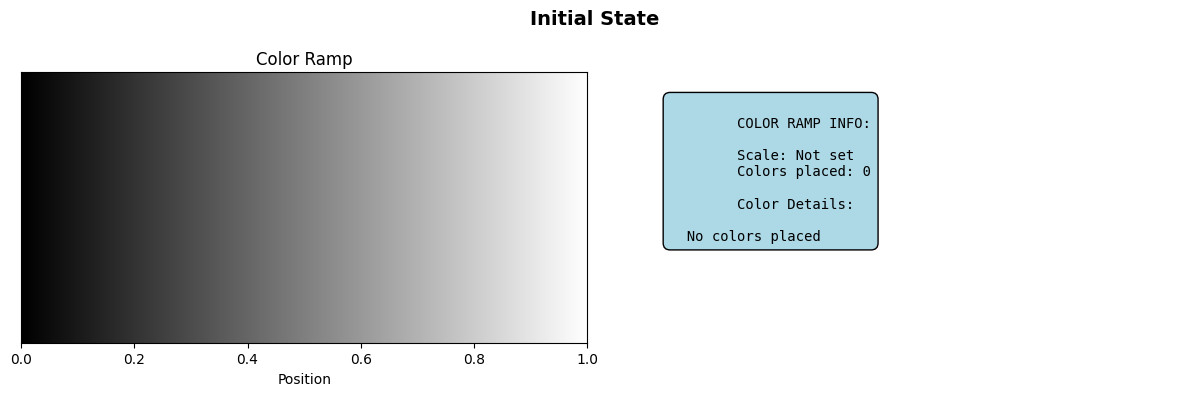

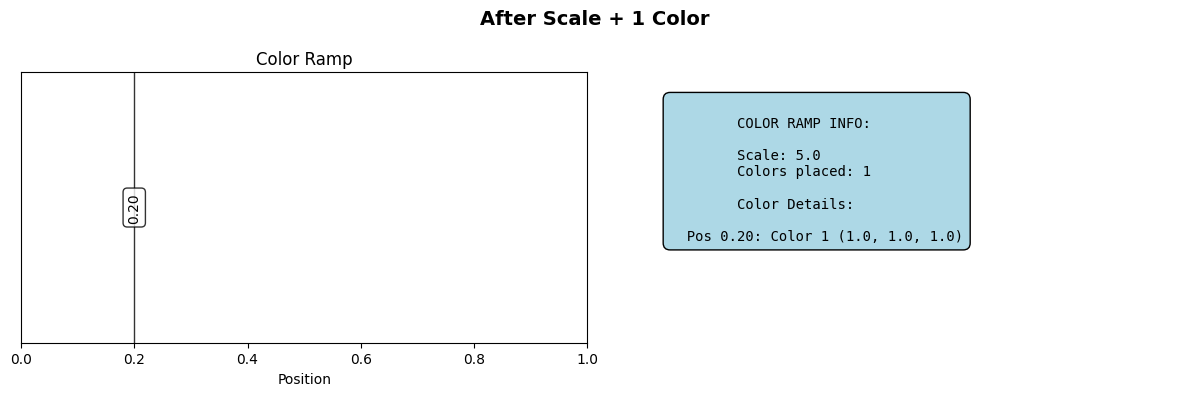

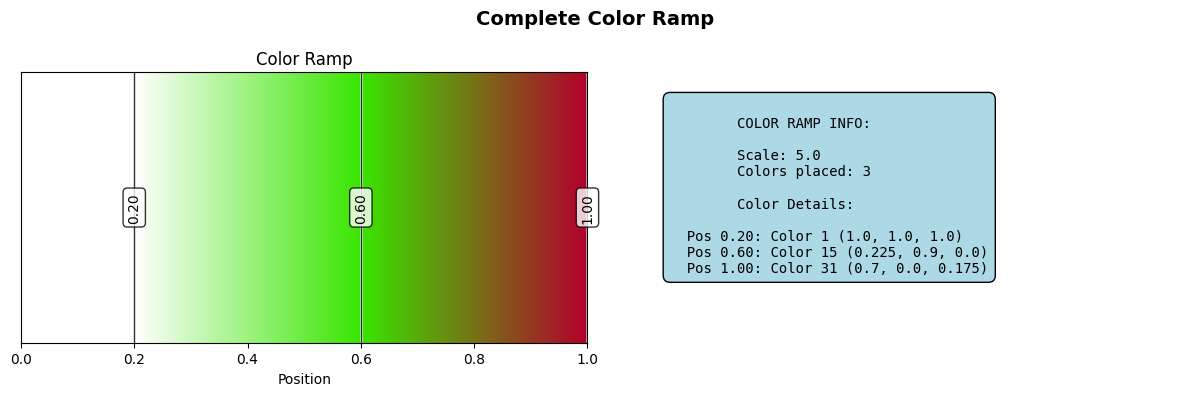

✅ Visualization demo complete!


In [2]:
from blender_gfn_experiment import *
# Example usage functions
def demo_visualization():
    """
    Demonstrate visualization capabilities.

    Example:
        >>> demo_visualization()
    """

    print("🎨 BLENDER VISUALIZATION DEMO")
    print("=" * 50)

    # Create some example states
    from collections import namedtuple

    ColorRampState = namedtuple("ColorRampState", ["scale", "colors", "step_count"])

    # Example states
    state1 = ColorRampState(scale=None, colors={}, step_count=0)
    state2 = ColorRampState(scale=5.0, colors={0: 1}, step_count=2)
    state3 = ColorRampState(scale=5.0, colors={0: 1, 2: 15, 4: 31}, step_count=4)

    print("1. Visualizing color ramp progression...")
    BlenderVisualizationUtility.visualize_color_ramp(state1, "Initial State")
    BlenderVisualizationUtility.visualize_color_ramp(state2, "After Scale + 1 Color")
    BlenderVisualizationUtility.visualize_color_ramp(state3, "Complete Color Ramp")

    print("✅ Visualization demo complete!")


if __name__ == "__main__":
    demo_visualization()

In [4]:
import bpy
import numpy as np
import torch

def get_color_ramp_tensor():
    # Clear scene
    bpy.ops.object.select_all(action='SELECT')
    bpy.ops.object.delete()
    
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
    
    # Create node group
    node_group = bpy.data.node_groups.new("ColorRampGroup", "GeometryNodeTree")
    
    # Add nodes
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    noise = node_group.nodes.new("ShaderNodeTexNoise")
    combine = node_group.nodes.new("ShaderNodeCombineXYZ")
    ramp = node_group.nodes.new("ShaderNodeValToRGB")
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Set up interface
    node_group.interface.new_socket("Geometry", in_out="INPUT", socket_type="NodeSocketGeometry")
    node_group.interface.new_socket("Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry")
    
    # Connect nodes
    node_group.links.new(noise.outputs["Fac"], combine.inputs["X"])
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Y"]) 
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Z"])
    node_group.links.new(combine.outputs["Vector"], ramp.inputs["Fac"])
    node_group.links.new(ramp.outputs["Color"], set_pos.inputs["Offset"])
    node_group.links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    node_group.links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Set color ramp colors
    ramp.color_ramp.elements[0].color = (1, 0, 0, 1)  # Red
    ramp.color_ramp.elements[1].color = (0, 0, 1, 1)  # Blue
    
    # Create plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    
    # Add subdivisions for detail
    bpy.ops.object.mode_set(mode='EDIT')
    bpy.ops.mesh.subdivide(number_cuts=6)
    bpy.ops.object.mode_set(mode='OBJECT')
    
    # Add geometry nodes modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    # Force update
    bpy.context.view_layer.update()
    
    # Extract tensor
    depsgraph = bpy.context.evaluated_depsgraph_get()
    evaluated = plane.evaluated_get(depsgraph)
    mesh = evaluated.to_mesh()
    
    verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
    grid_size = int(np.sqrt(len(verts)))
    heights = verts[:, 2].reshape(grid_size, grid_size)
    
    evaluated.to_mesh_clear()
    
    return torch.from_numpy(heights).float()

# Run it
color_tensor = get_color_ramp_tensor()
print(f"Shape: {color_tensor.shape}")
print(f"Range: [{color_tensor.min():.3f}, {color_tensor.max():.3f}]")

Shape: torch.Size([8, 8])
Range: [0.318, 0.619]


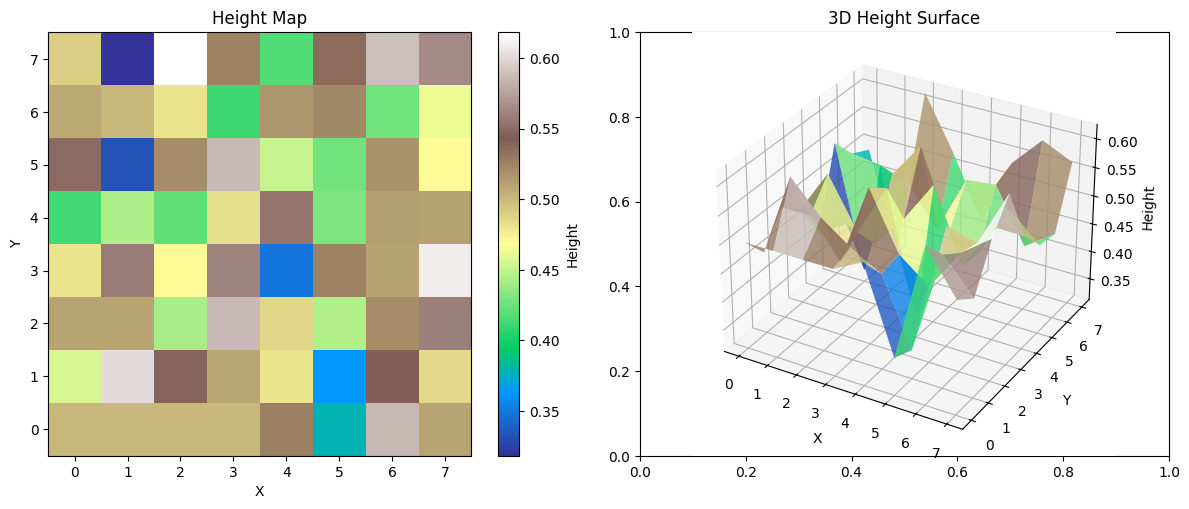

Height Map Statistics:
  Shape: (8, 8)
  Min: 0.318
  Max: 0.619
  Mean: 0.494
  Std: 0.066


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the height map
def visualize_height_map(color_tensor):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Convert to numpy if tensor
    heights = color_tensor.numpy() if hasattr(color_tensor, 'numpy') else color_tensor
    
    # 2D height map
    im1 = ax1.imshow(heights, cmap='terrain', origin='lower')
    ax1.set_title('Height Map')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    plt.colorbar(im1, ax=ax1, label='Height')
    
    # 3D surface
    x = np.arange(heights.shape[1])
    y = np.arange(heights.shape[0])
    X, Y = np.meshgrid(x, y)
    
    ax2 = fig.add_subplot(122, projection='3d')
    surf = ax2.plot_surface(X, Y, heights, cmap='terrain', alpha=0.8)
    ax2.set_title('3D Height Surface')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y') 
    ax2.set_zlabel('Height')
    
    plt.tight_layout()
    plt.show()
    
    # Print stats
    print(f"Height Map Statistics:")
    print(f"  Shape: {heights.shape}")
    print(f"  Min: {heights.min():.3f}")
    print(f"  Max: {heights.max():.3f}")
    print(f"  Mean: {heights.mean():.3f}")
    print(f"  Std: {heights.std():.3f}")

# Run visualization
visualize_height_map(color_tensor)

🚀 Testing multiple color ramp configurations...

--- Testing Configuration 1: Black to White ---
Extracted tensor shape: torch.Size([8, 8]), range: [0.337, 0.737]

--- Testing Configuration 2: Red to Blue ---
Extracted tensor shape: torch.Size([8, 8]), range: [0.318, 0.619]

--- Testing Configuration 3: Multi-color ---
Extracted tensor shape: torch.Size([8, 8]), range: [0.000, 0.280]

--- Testing Configuration 4: High Contrast ---
Extracted tensor shape: torch.Size([8, 8]), range: [0.088, 0.987]


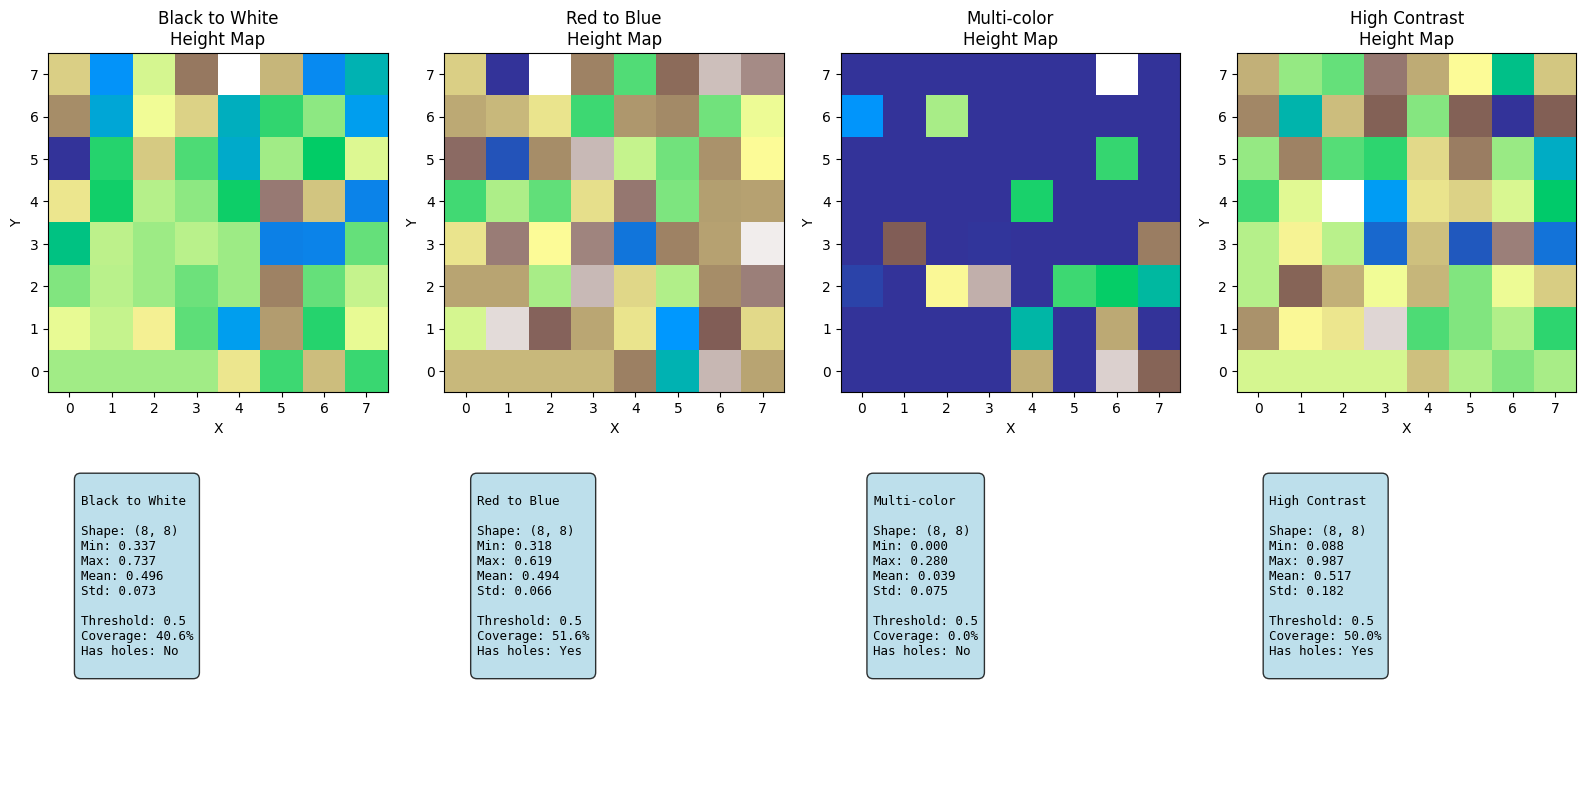


HOLE DETECTION ANALYSIS

Black to White:
  Binary coverage: 40.6%
  Holes filled: 0 pixels
  Has holes: NO
  Reward: 1.0

Red to Blue:
  Binary coverage: 51.6%
  Holes filled: 5 pixels
  Has holes: YES
  Reward: 0.0

Multi-color:
  Binary coverage: 0.0%
  Holes filled: 0 pixels
  Has holes: NO
  Reward: 1.0

High Contrast:
  Binary coverage: 50.0%
  Holes filled: 6 pixels
  Has holes: YES
  Reward: 0.0

✅ Completed testing 4 configurations!


In [7]:
import bpy
import numpy as np
import torch
import matplotlib.pyplot as plt

def test_multiple_configurations():
    """Test different color ramp configurations and extract tensors"""
    
    # Configuration 1: Black to White gradient
    config1 = {
        'name': 'Black to White',
        'colors': [(0.0, (0, 0, 0, 1)), (1.0, (1, 1, 1, 1))],
        'noise_scale': 2.0
    }
    
    # Configuration 2: Red to Blue gradient  
    config2 = {
        'name': 'Red to Blue',
        'colors': [(0.0, (1, 0, 0, 1)), (1.0, (0, 0, 1, 1))],
        'noise_scale': 5.0
    }
    
    # Configuration 3: Multi-color gradient
    config3 = {
        'name': 'Multi-color',
        'colors': [(0.0, (1, 0, 0, 1)), (0.5, (0, 1, 0, 1)), (1.0, (0, 0, 1, 1))],
        'noise_scale': 10.0
    }
    
    # Configuration 4: High contrast
    config4 = {
        'name': 'High Contrast',
        'colors': [(0.0, (0, 0, 0, 1)), (0.3, (0, 0, 0, 1)), (0.7, (1, 1, 1, 1)), (1.0, (1, 1, 1, 1))],
        'noise_scale': 8.0
    }
    
    configs = [config1, config2, config3, config4]
    tensors = []
    
    for i, config in enumerate(configs):
        print(f"\n--- Testing Configuration {i+1}: {config['name']} ---")
        tensor = create_and_extract_config(config)
        tensors.append((config['name'], tensor))
        print(f"Extracted tensor shape: {tensor.shape}, range: [{tensor.min():.3f}, {tensor.max():.3f}]")
    
    # Visualize all configurations
    visualize_all_configs(tensors)
    
    return tensors

def create_and_extract_config(config):
    """Create scene with specific config and extract tensor"""
    
    # Clear scene
    bpy.ops.object.select_all(action='SELECT')
    bpy.ops.object.delete()
    
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
    
    # Create node group
    node_group = bpy.data.node_groups.new("ColorRampGroup", "GeometryNodeTree")
    
    # Add nodes
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    noise = node_group.nodes.new("ShaderNodeTexNoise")
    combine = node_group.nodes.new("ShaderNodeCombineXYZ")
    ramp = node_group.nodes.new("ShaderNodeValToRGB")
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Set up interface
    node_group.interface.new_socket("Geometry", in_out="INPUT", socket_type="NodeSocketGeometry")
    node_group.interface.new_socket("Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry")
    
    # Connect nodes
    node_group.links.new(noise.outputs["Fac"], combine.inputs["X"])
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Y"]) 
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Z"])
    node_group.links.new(combine.outputs["Vector"], ramp.inputs["Fac"])
    node_group.links.new(ramp.outputs["Color"], set_pos.inputs["Offset"])
    node_group.links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    node_group.links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Set noise scale
    noise.inputs["Scale"].default_value = config['noise_scale']
    
    # Configure color ramp
    color_ramp = ramp.color_ramp
    
    # Clear existing elements (can't remove all, keep at least 2)
    while len(color_ramp.elements) > 2:
        color_ramp.elements.remove(color_ramp.elements[-1])
    
    # Configure the first two elements
    color_ramp.elements[0].position = config['colors'][0][0]
    color_ramp.elements[0].color = config['colors'][0][1]
    color_ramp.elements[1].position = config['colors'][1][0] 
    color_ramp.elements[1].color = config['colors'][1][1]
    
    # Add additional color stops if needed
    for position, color in config['colors'][2:]:
        element = color_ramp.elements.new(position)
        element.color = color
    
    # Create plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    
    # Add subdivisions
    bpy.ops.object.mode_set(mode='EDIT')
    bpy.ops.mesh.subdivide(number_cuts=6)
    bpy.ops.object.mode_set(mode='OBJECT')
    
    # Add geometry nodes modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    # Force update
    bpy.context.view_layer.update()
    
    # Extract tensor
    depsgraph = bpy.context.evaluated_depsgraph_get()
    evaluated = plane.evaluated_get(depsgraph)
    mesh = evaluated.to_mesh()
    
    verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
    grid_size = int(np.sqrt(len(verts)))
    heights = verts[:, 2].reshape(grid_size, grid_size)
    
    evaluated.to_mesh_clear()
    
    return torch.from_numpy(heights).float()

def visualize_all_configs(tensors):
    """Visualize all configurations in a grid"""
    
    n_configs = len(tensors)
    fig, axes = plt.subplots(2, n_configs, figsize=(4*n_configs, 8))
    
    if n_configs == 1:
        axes = axes.reshape(2, 1)
    
    for i, (name, tensor) in enumerate(tensors):
        heights = tensor.numpy()
        
        # 2D height map
        im1 = axes[0, i].imshow(heights, cmap='terrain', origin='lower')
        axes[0, i].set_title(f'{name}\nHeight Map')
        axes[0, i].set_xlabel('X')
        axes[0, i].set_ylabel('Y')
        
        # Statistics plot
        axes[1, i].axis('off')
        
        # Calculate stats
        threshold = 0.5
        binary_mask = heights > threshold
        coverage = (binary_mask.sum() / binary_mask.size) * 100
        
        # Check for holes
        try:
            from scipy import ndimage
            filled = ndimage.binary_fill_holes(binary_mask)
            has_holes = (filled.sum() - binary_mask.sum()) > 0
            holes_text = "Yes" if has_holes else "No"
        except ImportError:
            holes_text = "Unknown"
        
        stats_text = f"""
{name}

Shape: {heights.shape}
Min: {heights.min():.3f}
Max: {heights.max():.3f}
Mean: {heights.mean():.3f}
Std: {heights.std():.3f}

Threshold: {threshold}
Coverage: {coverage:.1f}%
Has holes: {holes_text}
"""
        
        axes[1, i].text(0.1, 0.9, stats_text,
                        transform=axes[1, i].transAxes,
                        verticalalignment='top',
                        fontfamily='monospace',
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.5", 
                                facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def analyze_hole_detection(tensors):
    """Analyze hole detection for all configurations"""
    
    print("\n" + "="*60)
    print("HOLE DETECTION ANALYSIS")
    print("="*60)
    
    threshold = 0.5
    
    for name, tensor in tensors:
        heights = tensor.numpy()
        binary_mask = heights > threshold
        
        try:
            from scipy import ndimage
            filled = ndimage.binary_fill_holes(binary_mask)
            holes_filled = filled.sum() - binary_mask.sum()
            has_holes = holes_filled > 0
            
            print(f"\n{name}:")
            print(f"  Binary coverage: {(binary_mask.sum() / binary_mask.size) * 100:.1f}%")
            print(f"  Holes filled: {holes_filled} pixels")
            print(f"  Has holes: {'YES' if has_holes else 'NO'}")
            print(f"  Reward: {'0.0' if has_holes else '1.0'}")
            
        except ImportError:
            print(f"\n{name}: scipy not available for hole detection")

# Run the test
print("🚀 Testing multiple color ramp configurations...")
result_tensors = test_multiple_configurations()

# Analyze hole detection
analyze_hole_detection(result_tensors)

print(f"\n✅ Completed testing {len(result_tensors)} configurations!")

🚀 Testing multiple color ramp configurations...

--- Testing Configuration 1: Black to White ---
Extracted tensor shape: torch.Size([17, 17]), range: [0.328, 0.724]

--- Testing Configuration 2: Red to Blue ---
Extracted tensor shape: torch.Size([17, 17]), range: [0.297, 0.707]

--- Testing Configuration 3: Multi-color ---
Extracted tensor shape: torch.Size([17, 17]), range: [0.000, 0.414]

--- Testing Configuration 4: High Contrast ---
Extracted tensor shape: torch.Size([17, 17]), range: [0.500, 0.500]


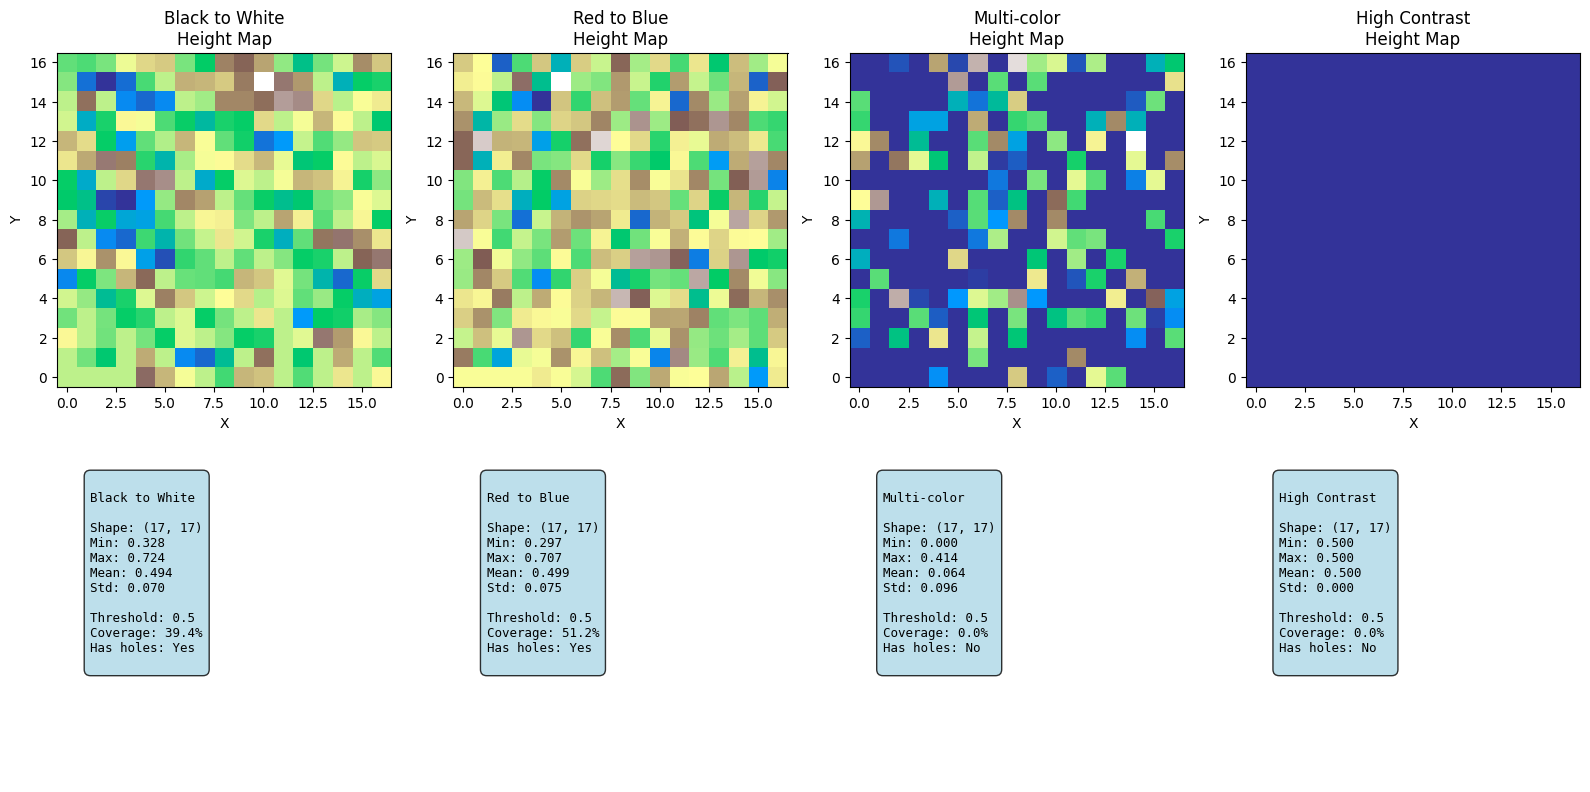


HOLE DETECTION ANALYSIS

Black to White:
  Binary coverage: 39.4%
  Holes filled: 5 pixels
  Has holes: YES
  Reward: 0.0

Red to Blue:
  Binary coverage: 51.2%
  Holes filled: 36 pixels
  Has holes: YES
  Reward: 0.0

Multi-color:
  Binary coverage: 0.0%
  Holes filled: 0 pixels
  Has holes: NO
  Reward: 1.0

High Contrast:
  Binary coverage: 0.0%
  Holes filled: 0 pixels
  Has holes: NO
  Reward: 1.0

✅ Completed testing 4 configurations!


In [8]:
import bpy
import numpy as np
import torch
import matplotlib.pyplot as plt

def test_multiple_configurations():
    """Test different color ramp configurations and extract tensors"""
    
    # Configuration 1: Black to White gradient
    config1 = {
        'name': 'Black to White',
        'colors': [(0.0, (0, 0, 0, 1)), (1.0, (1, 1, 1, 1))],
        'noise_scale': 2.0
    }
    
    # Configuration 2: Red to Blue gradient  
    config2 = {
        'name': 'Red to Blue',
        'colors': [(0.0, (1, 0, 0, 1)), (1.0, (0, 0, 1, 1))],
        'noise_scale': 5.0
    }
    
    # Configuration 3: Multi-color gradient
    config3 = {
        'name': 'Multi-color',
        'colors': [(0.0, (1, 0, 0, 1)), (0.5, (0, 1, 0, 1)), (1.0, (0, 0, 1, 1))],
        'noise_scale': 10.0
    }
    
    # Configuration 4: High contrast
    config4 = {
        'name': 'High Contrast',
        'colors': [(0.0, (0, 0, 0, 1)), (0.3, (0, 0, 0, 1)), (0.7, (1, 1, 1, 1)), (1.0, (1, 1, 1, 1))],
        'noise_scale': 8.0
    }
    
    configs = [config1, config2, config3, config4]
    tensors = []
    
    for i, config in enumerate(configs):
        print(f"\n--- Testing Configuration {i+1}: {config['name']} ---")
        tensor = create_and_extract_config(config)
        tensors.append((config['name'], tensor))
        print(f"Extracted tensor shape: {tensor.shape}, range: [{tensor.min():.3f}, {tensor.max():.3f}]")
    
    # Visualize all configurations
    visualize_all_configs(tensors)
    
    return tensors

def create_and_extract_config(config):
    """Create scene with specific config and extract tensor"""
    
    # Clear scene
    bpy.ops.object.select_all(action='SELECT')
    bpy.ops.object.delete()
    
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
    
    # Create node group
    node_group = bpy.data.node_groups.new("ColorRampGroup", "GeometryNodeTree")
    
    # Add nodes
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    noise = node_group.nodes.new("ShaderNodeTexNoise")
    combine = node_group.nodes.new("ShaderNodeCombineXYZ")
    ramp = node_group.nodes.new("ShaderNodeValToRGB")
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Set up interface
    node_group.interface.new_socket("Geometry", in_out="INPUT", socket_type="NodeSocketGeometry")
    node_group.interface.new_socket("Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry")
    
    # Connect nodes
    node_group.links.new(noise.outputs["Fac"], combine.inputs["X"])
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Y"]) 
    node_group.links.new(noise.outputs["Fac"], combine.inputs["Z"])
    node_group.links.new(combine.outputs["Vector"], ramp.inputs["Fac"])
    node_group.links.new(ramp.outputs["Color"], set_pos.inputs["Offset"])
    node_group.links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    node_group.links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Set noise scale
    noise.inputs["Scale"].default_value = config['noise_scale']
    
    # Configure color ramp
    color_ramp = ramp.color_ramp
    
    # Clear existing elements (can't remove all, keep at least 2)
    while len(color_ramp.elements) > 2:
        color_ramp.elements.remove(color_ramp.elements[-1])
    
    # Configure the first two elements
    color_ramp.elements[0].position = config['colors'][0][0]
    color_ramp.elements[0].color = config['colors'][0][1]
    color_ramp.elements[1].position = config['colors'][1][0] 
    color_ramp.elements[1].color = config['colors'][1][1]
    
    # Add additional color stops if needed
    for position, color in config['colors'][2:]:
        element = color_ramp.elements.new(position)
        element.color = color
    
    # Create plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    
    # Add more subdivisions for higher detail
    bpy.ops.object.mode_set(mode='EDIT')
    bpy.ops.mesh.subdivide(number_cuts=15)  # 16x16 grid instead of 8x8
    bpy.ops.object.mode_set(mode='OBJECT')
    
    # Add geometry nodes modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    # Force update
    bpy.context.view_layer.update()
    
    # Extract tensor
    depsgraph = bpy.context.evaluated_depsgraph_get()
    evaluated = plane.evaluated_get(depsgraph)
    mesh = evaluated.to_mesh()
    
    verts = np.array([(v.co.x, v.co.y, v.co.z) for v in mesh.vertices])
    grid_size = int(np.sqrt(len(verts)))
    heights = verts[:, 2].reshape(grid_size, grid_size)
    
    evaluated.to_mesh_clear()
    
    return torch.from_numpy(heights).float()

def visualize_all_configs(tensors):
    """Visualize all configurations in a grid"""
    
    n_configs = len(tensors)
    fig, axes = plt.subplots(2, n_configs, figsize=(4*n_configs, 8))
    
    if n_configs == 1:
        axes = axes.reshape(2, 1)
    
    for i, (name, tensor) in enumerate(tensors):
        heights = tensor.numpy()
        
        # 2D height map
        im1 = axes[0, i].imshow(heights, cmap='terrain', origin='lower')
        axes[0, i].set_title(f'{name}\nHeight Map')
        axes[0, i].set_xlabel('X')
        axes[0, i].set_ylabel('Y')
        
        # Statistics plot
        axes[1, i].axis('off')
        
        # Calculate stats
        threshold = 0.5
        binary_mask = heights > threshold
        coverage = (binary_mask.sum() / binary_mask.size) * 100
        
        # Check for holes
        try:
            from scipy import ndimage
            filled = ndimage.binary_fill_holes(binary_mask)
            has_holes = (filled.sum() - binary_mask.sum()) > 0
            holes_text = "Yes" if has_holes else "No"
        except ImportError:
            holes_text = "Unknown"
        
        stats_text = f"""
{name}

Shape: {heights.shape}
Min: {heights.min():.3f}
Max: {heights.max():.3f}
Mean: {heights.mean():.3f}
Std: {heights.std():.3f}

Threshold: {threshold}
Coverage: {coverage:.1f}%
Has holes: {holes_text}
"""
        
        axes[1, i].text(0.1, 0.9, stats_text,
                        transform=axes[1, i].transAxes,
                        verticalalignment='top',
                        fontfamily='monospace',
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.5", 
                                facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def analyze_hole_detection(tensors):
    """Analyze hole detection for all configurations"""
    
    print("\n" + "="*60)
    print("HOLE DETECTION ANALYSIS")
    print("="*60)
    
    threshold = 0.5
    
    for name, tensor in tensors:
        heights = tensor.numpy()
        binary_mask = heights > threshold
        
        try:
            from scipy import ndimage
            filled = ndimage.binary_fill_holes(binary_mask)
            holes_filled = filled.sum() - binary_mask.sum()
            has_holes = holes_filled > 0
            
            print(f"\n{name}:")
            print(f"  Binary coverage: {(binary_mask.sum() / binary_mask.size) * 100:.1f}%")
            print(f"  Holes filled: {holes_filled} pixels")
            print(f"  Has holes: {'YES' if has_holes else 'NO'}")
            print(f"  Reward: {'0.0' if has_holes else '1.0'}")
            
        except ImportError:
            print(f"\n{name}: scipy not available for hole detection")

# Run the test
print("🚀 Testing multiple color ramp configurations...")
result_tensors = test_multiple_configurations()

# Analyze hole detection
analyze_hole_detection(result_tensors)

print(f"\n✅ Completed testing {len(result_tensors)} configurations!")

✅ Blender available

🧪 Test 1: Creating Environment
🎨 Blender ColorRamp Environment created
  Max colors: 5
  Color choices: 32
  Available scales: 7

🎨 Testing ColorUtilities:
Position 2 of 5: 60.0%
Color ID 2: RGBA(r=1.0, g=0.0, b=0.0, a=1.0)
Color name: Red

🔧 Test 2: Creating Blender Procedure
Created plane: Plane
Available nodes: ['noise', 'ramp']

🎛️ Updating procedure parameters...
Parameters updated!

📊 Extracting terrain tensor...
Extracted tensor shape: torch.Size([17, 17])
Tensor range: [0.379, 0.633]

🏆 Testing reward calculation...
Has holes: True
Reward: 0.0

🧪 Test 3: Testing Multiple Configurations

--- Config 1: Red-Blue ---
  Shape: torch.Size([17, 17])
  Range: [0.345, 0.604]
  Reward: 1.0
  Has holes: False

--- Config 2: Green-Yellow ---
  Shape: torch.Size([17, 17])
  Range: [0.000, 0.000]
  Reward: 1.0
  Has holes: False

--- Config 3: Multi-color ---
  Shape: torch.Size([17, 17])
  Range: [0.083, 0.290]
  Reward: 1.0
  Has holes: False

📊 Visualizing Results...


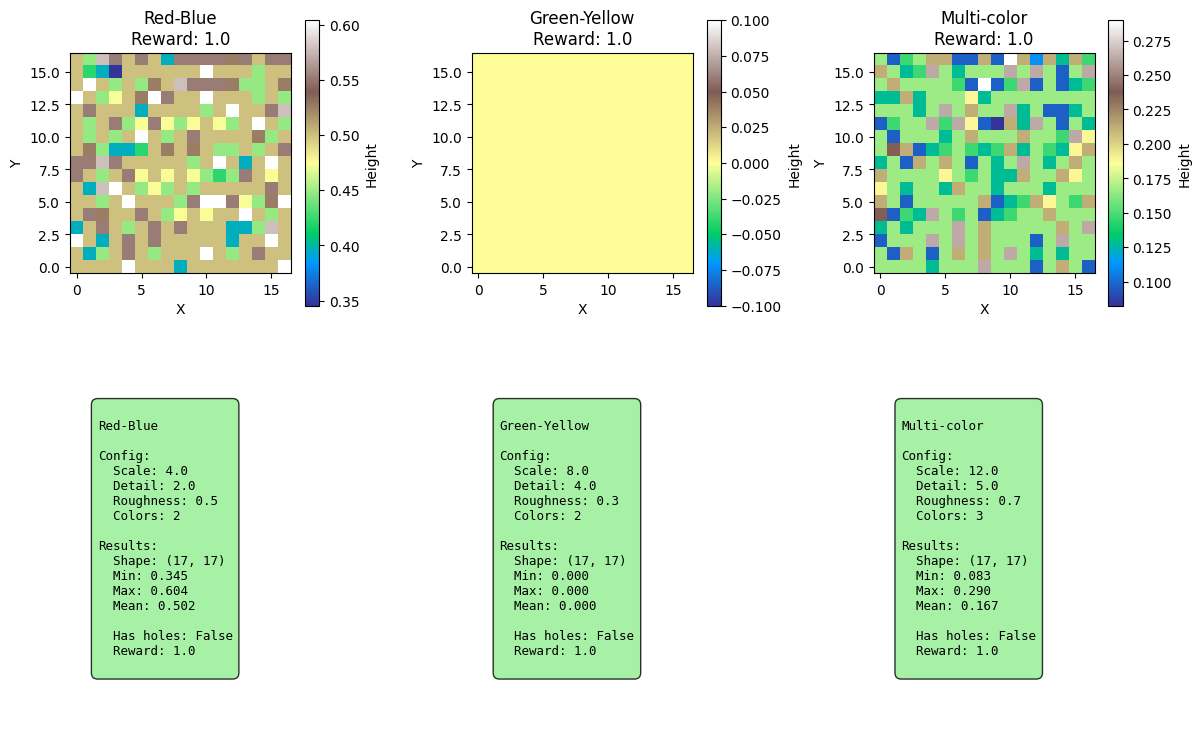


🧪 Test 5: Testing Environment State Methods

📋 State Translation Visualization:
BLENDER STATE TRANSLATION PREVIEW
Noise Scale: 5.0

Color Ramp Configuration:
  Custom Colors:
    40.0% (0.400) -> Red (1.0, 0.0, 0.0, 1.0)
    80.0% (0.800) -> Blue (0.0, 0.0, 1.0, 1.0)

Summary: Color Ramp: 40.0% Red, 80.0% Blue

🔍 Debug Information:
❌ Debug info not available (Blender not connected)
Debug info requires env.connect_blender() to be called first

🎯 TEST SUMMARY
Environment created: ✅
ColorUtilities working: ✅
Blender available: ✅
Procedure creation: ✅
Parameter updates: ✅
Tensor extraction: ✅
Reward calculation: ✅
Configurations tested: 3
State visualization: ✅
Debug utilities: ✅

🚀 All tests completed!

📖 QUICK USAGE EXAMPLE

# Create environment
env = BlenderColorRampEnvironment()

# Create procedure (once)
plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()

# Test different configs
config = {
    'noise_scale': 5.0,
    'noise_detail': 3.0,
    'noise_roughness': 0.6,
  

In [2]:
# ================================================================
# Notebook Test for Blender ColorRamp Environment
# ================================================================

import numpy as np
import torch
import matplotlib.pyplot as plt

# Import your environment
from blender_gfn_experiment import BlenderColorRampEnvironment

# Test if Blender is available
try:
    import bpy
    print("✅ Blender available")
    BLENDER_AVAILABLE = True
except ImportError:
    print("❌ Blender not available - will simulate")
    BLENDER_AVAILABLE = False

# ================================================================
# Test 1: Create Environment and Test Utilities
# ================================================================

print("\n🧪 Test 1: Creating Environment")
env = BlenderColorRampEnvironment(max_colors=5, num_color_choices=32)

# Test ColorUtilities
print("\n🎨 Testing ColorUtilities:")
pos = env.ColorUtilities.calculate_position(2, 5)
print(f"Position 2 of 5: {pos:.1%}")

rgba = env.ColorUtilities.color_id_to_rgba(2)  # Red
print(f"Color ID 2: {rgba}")

name = env.ColorUtilities.get_color_name(2)
print(f"Color name: {name}")

# ================================================================
# Test 2: Test Blender Procedure Creation (if available)
# ================================================================

if BLENDER_AVAILABLE:
    print("\n🔧 Test 2: Creating Blender Procedure")
    
    # Create the procedure
    plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
    print(f"Created plane: {plane.name}")
    print(f"Available nodes: {list(nodes.keys())}")
    
    # Test config
    test_config = {
        'noise_scale': 5.0,
        'noise_detail': 3.0,
        'noise_roughness': 0.6,
        'colors': [(0.0, (1, 0, 0, 1)), (1.0, (0, 0, 1, 1))]  # Red to Blue
    }
    
    # Update parameters
    print("\n🎛️ Updating procedure parameters...")
    env.BlenderUtilities.update_procedure_parameters(nodes, test_config)
    print("Parameters updated!")
    
    # Extract tensor
    print("\n📊 Extracting terrain tensor...")
    tensor = env.BlenderUtilities.extract_terrain_tensor(plane)
    print(f"Extracted tensor shape: {tensor.shape}")
    print(f"Tensor range: [{tensor.min():.3f}, {tensor.max():.3f}]")
    
    # Test reward calculation
    print("\n🏆 Testing reward calculation...")
    has_holes = env.RewardUtilities.detect_holes(tensor)
    reward = env.RewardUtilities.compute_reward(tensor)
    print(f"Has holes: {has_holes}")
    print(f"Reward: {reward}")

else:
    print("\n⚠️ Skipping Blender tests - not available")

# ================================================================
# Test 3: Test Multiple Configurations
# ================================================================

def test_multiple_configs():
    """Test different configurations"""
    
    configs = [
        {
            'name': 'Red-Blue',
            'noise_scale': 4.0,
            'noise_detail': 2.0,
            'noise_roughness': 0.5,
            'colors': [(0.0, (1, 0, 0, 1)), (1.0, (0, 0, 1, 1))]
        },
        {
            'name': 'Green-Yellow',
            'noise_scale': 8.0,
            'noise_detail': 4.0,
            'noise_roughness': 0.3,
            'colors': [(0.0, (0, 1, 0, 1)), (1.0, (1, 1, 0, 1))]
        },
        {
            'name': 'Multi-color',
            'noise_scale': 12.0,
            'noise_detail': 5.0,
            'noise_roughness': 0.7,
            'colors': [(0.0, (1, 0, 0, 1)), (0.5, (0, 1, 0, 1)), (1.0, (0, 0, 1, 1))]
        }
    ]
    
    results = []
    
    if BLENDER_AVAILABLE:
        print("\n🧪 Test 3: Testing Multiple Configurations")
        
        for i, config in enumerate(configs):
            print(f"\n--- Config {i+1}: {config['name']} ---")
            
            # Create fresh procedure
            plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
            
            # Update with config
            env.BlenderUtilities.update_procedure_parameters(nodes, config)
            
            # Extract tensor
            tensor = env.BlenderUtilities.extract_terrain_tensor(plane)
            
            # Calculate metrics
            reward = env.RewardUtilities.compute_reward(tensor)
            has_holes = env.RewardUtilities.detect_holes(tensor)
            
            result = {
                'name': config['name'],
                'tensor': tensor,
                'reward': reward,
                'has_holes': has_holes,
                'config': config
            }
            results.append(result)
            
            print(f"  Shape: {tensor.shape}")
            print(f"  Range: [{tensor.min():.3f}, {tensor.max():.3f}]")
            print(f"  Reward: {reward}")
            print(f"  Has holes: {has_holes}")
    
    return results

# Run multi-config test
test_results = test_multiple_configs()

# ================================================================
# Test 4: Visualization
# ================================================================

def visualize_results(results):
    """Visualize the test results"""
    
    if not results:
        print("No results to visualize")
        return
    
    n_configs = len(results)
    fig, axes = plt.subplots(2, n_configs, figsize=(4*n_configs, 8))
    
    if n_configs == 1:
        axes = axes.reshape(2, 1)
    
    for i, result in enumerate(results):
        tensor = result['tensor']
        heights = tensor.numpy() if torch.is_tensor(tensor) else tensor
        
        # Height map
        im = axes[0, i].imshow(heights, cmap='terrain', origin='lower')
        axes[0, i].set_title(f"{result['name']}\nReward: {result['reward']}")
        axes[0, i].set_xlabel('X')
        axes[0, i].set_ylabel('Y')
        plt.colorbar(im, ax=axes[0, i], label='Height', shrink=0.8)
        
        # Stats
        axes[1, i].axis('off')
        
        config = result['config']
        stats_text = f"""
{result['name']}

Config:
  Scale: {config['noise_scale']}
  Detail: {config['noise_detail']}
  Roughness: {config['noise_roughness']}
  Colors: {len(config['colors'])}

Results:
  Shape: {heights.shape}
  Min: {heights.min():.3f}
  Max: {heights.max():.3f}
  Mean: {heights.mean():.3f}
  
  Has holes: {result['has_holes']}
  Reward: {result['reward']}
"""
        
        color = 'lightgreen' if result['reward'] > 0 else 'lightcoral'
        axes[1, i].text(0.1, 0.9, stats_text,
                        transform=axes[1, i].transAxes,
                        verticalalignment='top',
                        fontfamily='monospace',
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.5", 
                                facecolor=color, alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Visualize results
if test_results:
    print("\n📊 Visualizing Results...")
    visualize_results(test_results)

# ================================================================
# Test 5: Test State Visualization (Environment Methods)
# ================================================================

print("\n🧪 Test 5: Testing Environment State Methods")

# Create a test state
from blender_gfn_experiment import ColorRampState, ColorID

test_state = ColorRampState(
    scale=5.0,
    colors={1: ColorID.RED, 3: ColorID.BLUE}
)

# Test state visualization
print("\n📋 State Translation Visualization:")
translation = env.visualize_state_translation(test_state)
print(translation)

# Test debug info
print("\n🔍 Debug Information:")
debug_info = env.debug_state_translation(test_state)

if debug_info:
    print(f"Scale: {debug_info['scale']}")
    print(f"Number of colors: {debug_info['num_colors']}")
    print(f"Blender ready: {debug_info['blender_ready']}")
    
    for pos, info in debug_info['color_positions'].items():
        print(f"Position {pos}: {info['color_name']} at {info['normalized_position']:.1%}")
else:
    print("❌ Debug info not available (Blender not connected)")
    print("Debug info requires env.connect_blender() to be called first")

# ================================================================
# Summary
# ================================================================

print("\n" + "="*60)
print("🎯 TEST SUMMARY")
print("="*60)
print(f"Environment created: ✅")
print(f"ColorUtilities working: ✅")
print(f"Blender available: {'✅' if BLENDER_AVAILABLE else '❌'}")

if BLENDER_AVAILABLE:
    print(f"Procedure creation: ✅")
    print(f"Parameter updates: ✅")
    print(f"Tensor extraction: ✅")
    print(f"Reward calculation: ✅")
    print(f"Configurations tested: {len(test_results)}")

print(f"State visualization: ✅")
print(f"Debug utilities: ✅")

print("\n🚀 All tests completed!")

# ================================================================
# Quick Usage Example
# ================================================================

print("\n" + "="*60)
print("📖 QUICK USAGE EXAMPLE")
print("="*60)

example_code = '''
# Create environment
env = BlenderColorRampEnvironment()

# Create procedure (once)
plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()

# Test different configs
config = {
    'noise_scale': 5.0,
    'noise_detail': 3.0,
    'noise_roughness': 0.6,
    'colors': [(0.0, (1,0,0,1)), (1.0, (0,0,1,1))]
}

# Update parameters
env.BlenderUtilities.update_procedure_parameters(nodes, config)

# Extract results
tensor = env.BlenderUtilities.extract_terrain_tensor(plane)
reward = env.RewardUtilities.compute_reward(tensor)

print(f"Tensor shape: {tensor.shape}")
print(f"Reward: {reward}")
'''

print(example_code)

🎨 Blender ColorRamp Environment created
  Max colors: 5
  Color choices: 32
  Available scales: 7
🔗 Connected to Blender
🧪 Testing Reward Function with Visualization

--- Test 1 ---
Scale: 2.0
Colors: Color Ramp: 40.0% Red, 80.0% Blue
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 2 ---
Scale: 5.0
Colors: Color Ramp: 20.0% Black, 100.0% White
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 3 ---
Scale: 10.0
Colors: Color Ramp: 40.0% Green, 60.0% Yellow, 80.0% Cyan
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 4 ---
Scale: 15.0
Colors: Color Ramp: 20.0% Magenta, 60.0% Green
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]

--- Test 5 ---
Scale: 20.0
Colors: Color Ramp: 40.0% Blue, 100.0% Red
Reward: 0.0
Tensor shape: torch.Size([17, 17])
Height range: [0.297, 0.707]


/tmp/ipykernel_645021/960689879.py:143: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jpleona/jpleona_c/bpygfn/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


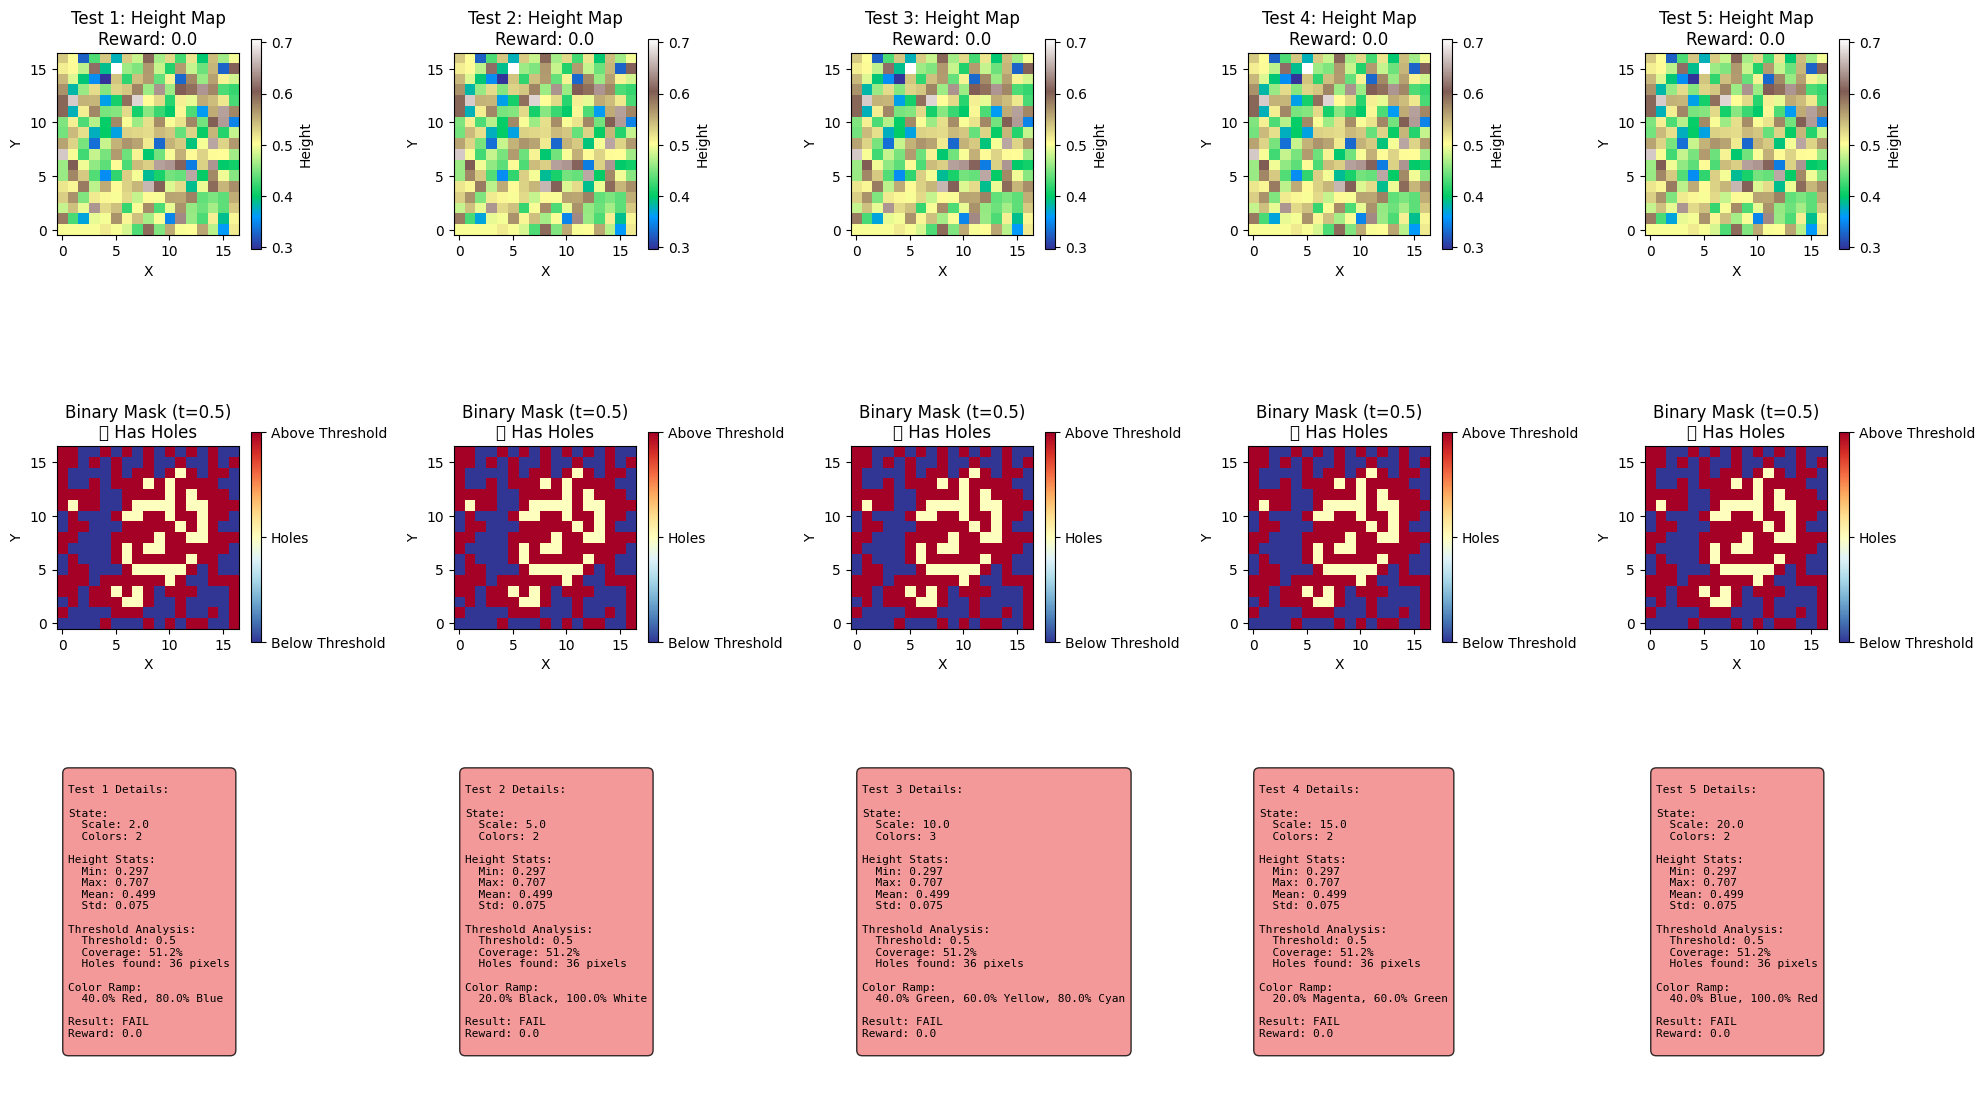


🔍 Detailed Red-Blue Test


/tmp/ipykernel_645021/960689879.py:225: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/jpleona/jpleona_c/bpygfn/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


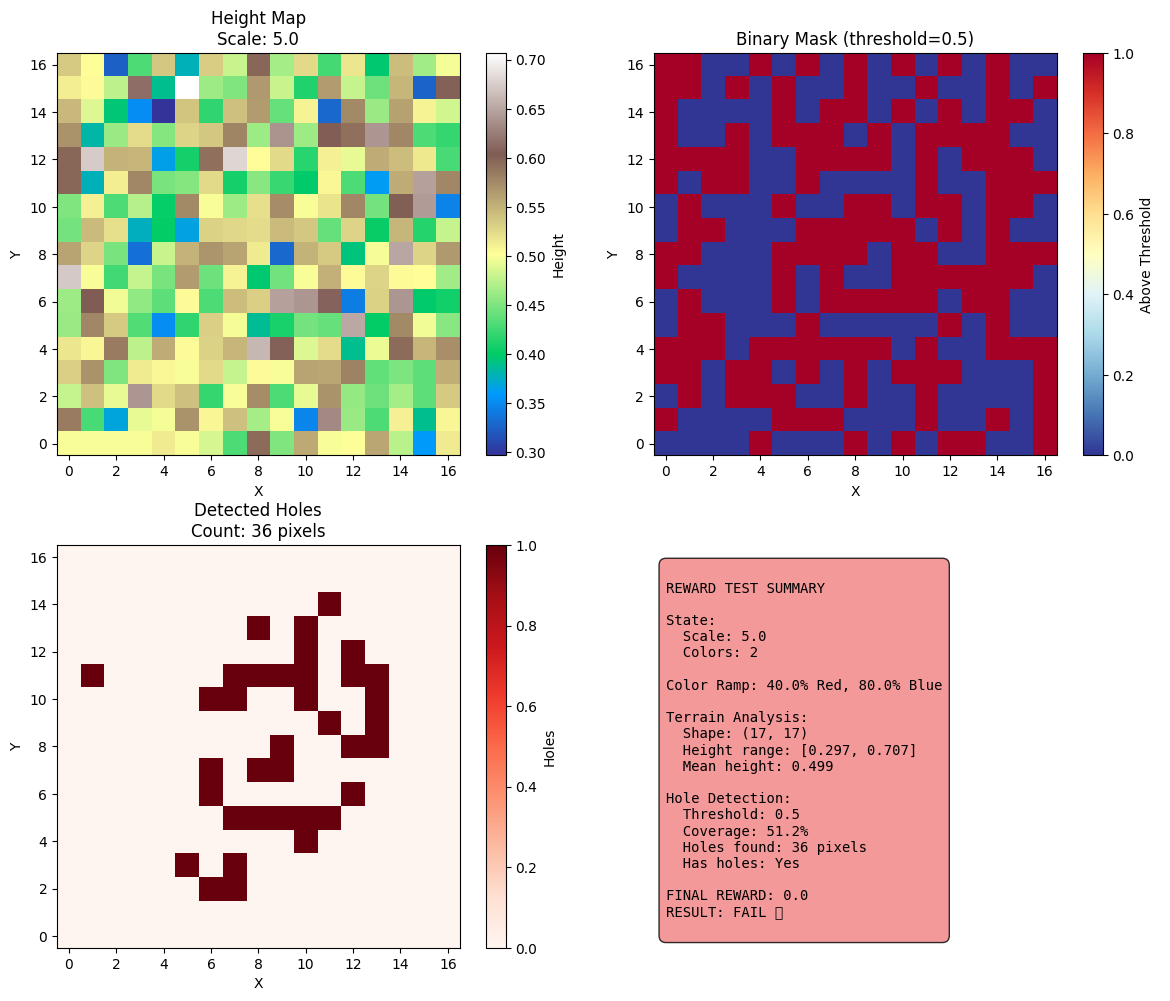

Reward: 0.0
Result: FAIL

🎯 Tested 5 configurations!
Success rate: 0/5 (0.0%)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from blender_gfn_experiment import BlenderColorRampEnvironment, ColorRampState, ColorID

def test_reward_with_visualization(env):
    """Test reward function with comprehensive visualization"""
    
    # Setup once
    plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
    env.connect_blender(plane, None, nodes)
    
    # Test different states
    test_states = [
        ColorRampState(scale=2.0, colors={1: ColorID.RED, 3: ColorID.BLUE}),
        ColorRampState(scale=5.0, colors={0: ColorID.BLACK, 4: ColorID.WHITE}),
        ColorRampState(scale=10.0, colors={1: ColorID.GREEN, 2: ColorID.YELLOW, 3: ColorID.CYAN}),
        ColorRampState(scale=15.0, colors={0: ColorID.MAGENTA, 2: ColorID.GREEN}),
        ColorRampState(scale=20.0, colors={1: ColorID.BLUE, 4: ColorID.RED})
    ]
    
    results = []
    
    print("🧪 Testing Reward Function with Visualization")
    print("=" * 60)
    
    for i, state in enumerate(test_states):
        print(f"\n--- Test {i+1} ---")
        
        # Get reward
        reward = env.get_reward(state)
        
        # Extract tensor for visualization
        tensor = env.BlenderUtilities.extract_terrain_tensor(plane)
        
        # Get state description
        description = env.ColorUtilities.describe_color_ramp(state.colors, env.max_colors)
        
        result = {
            'state': state,
            'tensor': tensor,
            'reward': reward,
            'description': description
        }
        results.append(result)
        
        print(f"Scale: {state.scale}")
        print(f"Colors: {description}")
        print(f"Reward: {reward}")
        print(f"Tensor shape: {tensor.shape}")
        print(f"Height range: [{tensor.min():.3f}, {tensor.max():.3f}]")
    
    # Create comprehensive visualization
    visualize_reward_results(results)
    
    return results

def visualize_reward_results(results):
    """Create comprehensive visualization of reward results"""
    
    n_tests = len(results)
    fig, axes = plt.subplots(3, n_tests, figsize=(4*n_tests, 12))
    
    if n_tests == 1:
        axes = axes.reshape(3, 1)
    
    for i, result in enumerate(results):
        tensor = result['tensor']
        heights = tensor.numpy() if hasattr(tensor, 'numpy') else tensor
        reward = result['reward']
        state = result['state']
        
        # Row 1: Height map
        im1 = axes[0, i].imshow(heights, cmap='terrain', origin='lower')
        axes[0, i].set_title(f"Test {i+1}: Height Map\nReward: {reward}")
        axes[0, i].set_xlabel('X')
        axes[0, i].set_ylabel('Y')
        plt.colorbar(im1, ax=axes[0, i], label='Height', shrink=0.6)
        
        # Row 2: Binary mask and hole detection
        threshold = 0.5
        binary_mask = heights > threshold
        
        # Detect holes
        filled = ndimage.binary_fill_holes(binary_mask)
        holes_mask = filled & ~binary_mask
        
        # Show binary mask with holes highlighted
        display_mask = binary_mask.astype(float)
        display_mask[holes_mask] = 0.5  # Gray for holes
        
        im2 = axes[1, i].imshow(display_mask, cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1)
        axes[1, i].set_title(f"Binary Mask (t={threshold})\n{'✅ No Holes' if reward > 0 else '❌ Has Holes'}")
        axes[1, i].set_xlabel('X')
        axes[1, i].set_ylabel('Y')
        
        # Add colorbar
        cbar = plt.colorbar(im2, ax=axes[1, i], shrink=0.6)
        cbar.set_ticks([0, 0.5, 1])
        cbar.set_ticklabels(['Below Threshold', 'Holes', 'Above Threshold'])
        
        # Row 3: Statistics and info
        axes[2, i].axis('off')
        
        # Calculate detailed stats
        coverage = (binary_mask.sum() / binary_mask.size) * 100
        holes_count = holes_mask.sum()
        
        info_text = f"""
Test {i+1} Details:

State:
  Scale: {state.scale}
  Colors: {len(state.colors)}

Height Stats:
  Min: {heights.min():.3f}
  Max: {heights.max():.3f}
  Mean: {heights.mean():.3f}
  Std: {heights.std():.3f}

Threshold Analysis:
  Threshold: {threshold}
  Coverage: {coverage:.1f}%
  Holes found: {holes_count} pixels
  
Color Ramp:
  {result['description'].replace('Color Ramp: ', '')}

Result: {'SUCCESS' if reward > 0 else 'FAIL'}
Reward: {reward}
"""
        
        color = 'lightgreen' if reward > 0 else 'lightcoral'
        axes[2, i].text(0.05, 0.95, info_text,
                        transform=axes[2, i].transAxes,
                        verticalalignment='top',
                        fontfamily='monospace',
                        fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.5", 
                                facecolor=color, alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def visualize_single_reward_test(env, state, title="Reward Test"):
    """Detailed visualization for a single state"""
    
    print(f"\n🔍 {title}")
    print("=" * 40)
    
    # Get reward and tensor
    reward = env.get_reward(state)
    tensor = env.BlenderUtilities.extract_terrain_tensor(env.plane)
    heights = tensor.numpy() if hasattr(tensor, 'numpy') else tensor
    
    # Create detailed visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Height map
    im1 = ax1.imshow(heights, cmap='terrain', origin='lower')
    ax1.set_title(f'Height Map\nScale: {state.scale}')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    plt.colorbar(im1, ax=ax1, label='Height')
    
    # 2. Binary mask
    threshold = 0.5
    binary_mask = heights > threshold
    im2 = ax2.imshow(binary_mask, cmap='RdYlBu_r', origin='lower')
    ax2.set_title(f'Binary Mask (threshold={threshold})')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    plt.colorbar(im2, ax=ax2, label='Above Threshold')
    
    # 3. Hole detection
    filled = ndimage.binary_fill_holes(binary_mask)
    holes_mask = filled & ~binary_mask
    
    im3 = ax3.imshow(holes_mask, cmap='Reds', origin='lower')
    ax3.set_title(f'Detected Holes\nCount: {holes_mask.sum()} pixels')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    plt.colorbar(im3, ax=ax3, label='Holes')
    
    # 4. Summary
    ax4.axis('off')
    
    description = env.ColorUtilities.describe_color_ramp(state.colors, env.max_colors)
    coverage = (binary_mask.sum() / binary_mask.size) * 100
    
    summary_text = f"""
REWARD TEST SUMMARY

State:
  Scale: {state.scale}
  Colors: {len(state.colors)}
  
{description}

Terrain Analysis:
  Shape: {heights.shape}
  Height range: [{heights.min():.3f}, {heights.max():.3f}]
  Mean height: {heights.mean():.3f}
  
Hole Detection:
  Threshold: {threshold}
  Coverage: {coverage:.1f}%
  Holes found: {holes_mask.sum()} pixels
  Has holes: {'Yes' if holes_mask.sum() > 0 else 'No'}

FINAL REWARD: {reward}
RESULT: {'SUCCESS ✅' if reward > 0 else 'FAIL ❌'}
"""
    
    color = 'lightgreen' if reward > 0 else 'lightcoral'
    ax4.text(0.05, 0.95, summary_text,
             transform=ax4.transAxes,
             verticalalignment='top',
             fontfamily='monospace',
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.5", 
                     facecolor=color, alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Reward: {reward}")
    print(f"Result: {'SUCCESS' if reward > 0 else 'FAIL'}")

# Example usage
if __name__ == "__main__":
    # Create environment
    env = BlenderColorRampEnvironment()
    
    # Test multiple states
    results = test_reward_with_visualization(env)
    
    # Test single state in detail
    test_state = ColorRampState(scale=5.0, colors={1: ColorID.RED, 3: ColorID.BLUE})
    visualize_single_reward_test(env, test_state, "Detailed Red-Blue Test")
    
    print(f"\n🎯 Tested {len(results)} configurations!")
    success_count = sum(1 for r in results if r['reward'] > 0)
    print(f"Success rate: {success_count}/{len(results)} ({success_count/len(results)*100:.1f}%)")

In [4]:
print(reward)

0.0


In [5]:
import bpy
import os

def clear_scene():
    """Completely clear the Blender scene"""
    # Delete all objects
    bpy.ops.object.select_all(action='SELECT')
    bpy.ops.object.delete(use_global=False)
    
    # Clear all node groups
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
        
    # Clear all materials
    for mat in bpy.data.materials:
        bpy.data.materials.remove(mat)
        
    print("🧹 Scene cleared")

def create_color_ramp_procedure_fixed():
    """Create the color ramp geometry node procedure - FIXED VERSION"""
    
    # Clear scene first
    clear_scene()
    
    # Create node group
    node_group = bpy.data.node_groups.new("ColorRampGroup", "GeometryNodeTree")
    
    # Add GEOMETRY nodes (not shader nodes!)
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    
    # CORRECT: Use GeometryNodeInputNoise instead of ShaderNodeTexNoise
    noise = node_group.nodes.new("GeometryNodeInputNoise")
    
    # CORRECT: Use GeometryNodeCombineXYZ instead of ShaderNodeCombineXYZ  
    combine = node_group.nodes.new("GeometryNodeCombineXYZ")
    
    # CORRECT: Use GeometryNodeValToRGB instead of ShaderNodeValToRGB
    ramp = node_group.nodes.new("GeometryNodeValToRGB")
    
    # CORRECT: This one was already correct
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Position nodes for better visibility
    group_input.location = (-400, 0)
    noise.location = (-200, 200)
    combine.location = (0, 200)
    ramp.location = (200, 200)
    set_pos.location = (400, 0)
    group_output.location = (600, 0)
    
    # Set up interface
    node_group.interface.new_socket(
        "Geometry", in_out="INPUT", socket_type="NodeSocketGeometry"
    )
    node_group.interface.new_socket(
        "Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry"
    )
    
    # Connect nodes
    node_group.links.new(noise.outputs["Noise"], combine.inputs["X"])
    node_group.links.new(noise.outputs["Noise"], combine.inputs["Y"])
    node_group.links.new(noise.outputs["Noise"], combine.inputs["Z"])
    node_group.links.new(combine.outputs["Vector"], ramp.inputs["Fac"])
    node_group.links.new(ramp.outputs["Color"], set_pos.inputs["Offset"])
    node_group.links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    node_group.links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Create plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    plane.name = "TerrainPlane"
    
    # Add subdivisions
    bpy.ops.object.mode_set(mode="EDIT")
    bpy.ops.mesh.subdivide(number_cuts=15)
    bpy.ops.object.mode_set(mode="OBJECT")
    
    # Add geometry nodes modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    print("✅ Created CORRECT geometry node setup")
    print(f"   Node group: {node_group.name}")
    print(f"   Plane: {plane.name}")
    print(f"   Nodes created:")
    for node in node_group.nodes:
        print(f"     - {node.name} ({node.type})")
    
    return plane, {"noise": noise, "ramp": ramp}

def save_debug_file():
    """Save the current Blender file for debugging"""
    
    # Get the current script directory or use temp
    try:
        import tempfile
        temp_dir = tempfile.gettempdir()
        file_path = os.path.join(temp_dir, "blender_debug_geometry_nodes.blend")
    except:
        file_path = "/tmp/blender_debug_geometry_nodes.blend"
    
    # Remove old file if it exists
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"🗑️ Deleted old file: {file_path}")
    
    # Save new file
    bpy.ops.wm.save_as_mainfile(filepath=file_path)
    print(f"💾 Saved debug file: {file_path}")
    print(f"   Open this file in Blender to inspect the geometry nodes")
    
    return file_path

def compare_node_types():
    """Show the difference between shader and geometry node types"""
    print("\n🔍 COMPARISON: Shader vs Geometry Nodes")
    print("=" * 50)
    print("WRONG (Shader Nodes in Geometry Tree):")
    print("  ❌ ShaderNodeTexNoise")
    print("  ❌ ShaderNodeCombineXYZ") 
    print("  ❌ ShaderNodeValToRGB")
    print("\nCORRECT (Geometry Nodes):")
    print("  ✅ GeometryNodeInputNoise")
    print("  ✅ GeometryNodeCombineXYZ")
    print("  ✅ GeometryNodeValToRGB")
    print("\nThe issue: You were mixing shader editor nodes with geometry nodes!")

def debug_geometry_nodes():
    """Main debug function - creates correct setup and saves file"""
    
    print("🚀 Starting Geometry Nodes Debug Session")
    print("=" * 60)
    
    # Show the comparison
    compare_node_types()
    
    # Create the CORRECT setup
    plane, nodes = create_color_ramp_procedure_fixed()
    
    # Save for inspection
    file_path = save_debug_file()
    
    print(f"\n🎯 DEBUG COMPLETE!")
    print(f"   File saved: {file_path}")
    print(f"   Plane object: {plane.name}")
    print(f"   Available nodes: {list(nodes.keys())}")
    
    # Test the noise node
    if "noise" in nodes:
        noise_node = nodes["noise"]
        print(f"\n🔧 Noise Node Details:")
        print(f"   Type: {noise_node.type}")
        print(f"   Name: {noise_node.name}")
        print(f"   Inputs: {[inp.name for inp in noise_node.inputs]}")
        print(f"   Outputs: {[out.name for out in noise_node.outputs]}")
    
    return plane, nodes, file_path

# Run the debug
if __name__ == "__main__":
    plane, nodes, file_path = debug_geometry_nodes()
    
    # Verify the setup works
    print(f"\n✅ Setup verified - open {file_path} in Blender to inspect!")

🚀 Starting Geometry Nodes Debug Session

🔍 COMPARISON: Shader vs Geometry Nodes
WRONG (Shader Nodes in Geometry Tree):
  ❌ ShaderNodeTexNoise
  ❌ ShaderNodeCombineXYZ
  ❌ ShaderNodeValToRGB

CORRECT (Geometry Nodes):
  ✅ GeometryNodeInputNoise
  ✅ GeometryNodeCombineXYZ
  ✅ GeometryNodeValToRGB

The issue: You were mixing shader editor nodes with geometry nodes!
🧹 Scene cleared
Error: Node type GeometryNodeInputNoise undefined


RuntimeError: Error: Node type GeometryNodeInputNoise undefined


In [6]:
import bpy

class BlenderUtilities:
    @staticmethod
    def create_color_ramp_procedure():
        """Create the color ramp geometry node procedure - WORKING VERSION"""
        
        print("🚀 Creating color ramp procedure...")
        
        # Clear scene
        print("Clearing existing objects and node groups...")
        bpy.ops.object.select_all(action="SELECT")
        bpy.ops.object.delete(use_global=False)
        
        # Clear existing node groups
        for ng in bpy.data.node_groups:
            bpy.data.node_groups.remove(ng)
        
        # Create node group
        print("Creating geometry node group...")
        node_group = bpy.data.node_groups.new("ColorRampGroup", "GeometryNodeTree")
        
        # Add group input and output nodes
        group_input = node_group.nodes.new("NodeGroupInput")
        group_output = node_group.nodes.new("NodeGroupOutput")
        
        # Set up the interface for the node group
        print("Setting up node group interface...")
        try:
            if hasattr(node_group, "interface"):
                # Add input socket for geometry
                node_group.interface.new_socket(
                    name="Geometry", in_out="INPUT", socket_type="NodeSocketGeometry"
                )
                # Add output socket for geometry
                node_group.interface.new_socket(
                    name="Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry"
                )
                print("  ✅ Interface setup successful")
        except Exception as e:
            print(f"  ⚠️ Interface setup failed: {e}")
        
        # Create nodes using the working configuration
        print("Creating nodes...")
        nodes = {}
        
        # Create the specific nodes (mixing shader and geometry nodes as per your working example)
        nodes["noise"] = node_group.nodes.new("ShaderNodeTexNoise")
        nodes["combine"] = node_group.nodes.new("ShaderNodeCombineXYZ") 
        nodes["ramp"] = node_group.nodes.new("ShaderNodeValToRGB")
        nodes["set_pos"] = node_group.nodes.new("GeometryNodeSetPosition")
        
        print(f"  ✅ Created {len(nodes)} nodes")
        for name, node in nodes.items():
            print(f"    - {name}: {node.bl_idname}")
        
        # Position nodes for better visibility
        group_input.location = (-600, 0)
        nodes["noise"].location = (-400, 200)
        nodes["combine"].location = (-200, 200)
        nodes["ramp"].location = (0, 200)
        nodes["set_pos"].location = (200, 0)
        group_output.location = (400, 0)
        
        # Create connections based on your working example
        print("Creating connections...")
        links = node_group.links
        
        # Connect noise to combine (3 connections)
        links.new(nodes["noise"].outputs["Fac"], nodes["combine"].inputs["X"])
        links.new(nodes["noise"].outputs["Fac"], nodes["combine"].inputs["Y"])
        links.new(nodes["noise"].outputs["Fac"], nodes["combine"].inputs["Z"])
        
        # Connect combine to ramp
        links.new(nodes["combine"].outputs["Vector"], nodes["ramp"].inputs["Fac"])
        
        # Connect ramp to set_pos
        links.new(nodes["ramp"].outputs["Color"], nodes["set_pos"].inputs["Offset"])
        
        # Connect to group input/output
        links.new(group_input.outputs[0], nodes["set_pos"].inputs["Geometry"])
        links.new(nodes["set_pos"].outputs["Geometry"], group_output.inputs[0])
        
        print(f"  ✅ Created {len(links)} connections")
        
        # Create plane (not sphere like your example)
        print("Creating plane geometry...")
        bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
        plane = bpy.context.active_object
        plane.name = "TerrainPlane"
        
        # Add subdivisions for better detail
        print("Adding subdivisions...")
        bpy.ops.object.mode_set(mode="EDIT")
        bpy.ops.mesh.subdivide(number_cuts=15)  # Creates a 16x16 grid
        bpy.ops.object.mode_set(mode="OBJECT")
        
        # Add geometry nodes modifier
        print("Adding geometry nodes modifier...")
        geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
        
        try:
            geo_mod.node_group = node_group
            print("  ✅ Successfully assigned node group to modifier")
        except Exception as e:
            print(f"  ⚠️ Could not assign node group: {e}")
        
        # Set up default color ramp (red to blue like your example)
        print("Setting up default color ramp...")
        ramp_node = nodes["ramp"]
        if len(ramp_node.color_ramp.elements) >= 2:
            ramp_node.color_ramp.elements[0].color = (1, 0, 0, 1)  # Red
            ramp_node.color_ramp.elements[1].color = (0, 0, 1, 1)  # Blue
            print("  ✅ Set color ramp: red to blue")
        
        # Set default noise scale
        nodes["noise"].inputs["Scale"].default_value = 5.0
        print("  ✅ Set noise scale to 5.0")
        
        print(f"✅ Color ramp procedure created successfully!")
        print(f"   Node group: {node_group.name}")
        print(f"   Plane: {plane.name}")
        print(f"   Total connections: {len(links)}")
        
        return plane, nodes

def test_and_save_procedure():
    """Test the procedure and save a debug file"""
    
    print("🧪 Testing color ramp procedure...")
    
    # Create the procedure
    plane, nodes = BlenderUtilities.create_color_ramp_procedure()
    
    # Verify the setup
    print("\n🔍 Verifying setup...")
    print(f"Plane vertices: {len(plane.data.vertices)}")
    print(f"Available nodes: {list(nodes.keys())}")
    
    # Test modifying the noise scale
    if "noise" in nodes:
        original_scale = nodes["noise"].inputs["Scale"].default_value
        nodes["noise"].inputs["Scale"].default_value = 10.0
        print(f"Changed noise scale from {original_scale} to 10.0")
    
    # Test modifying color ramp
    if "ramp" in nodes:
        ramp = nodes["ramp"]
        print(f"Color ramp has {len(ramp.color_ramp.elements)} elements")
        
        # Add a middle color stop
        if len(ramp.color_ramp.elements) == 2:
            middle_stop = ramp.color_ramp.elements.new(0.5)
            middle_stop.color = (0, 1, 0, 1)  # Green
            print("Added green middle stop to color ramp")
    
    # Save debug file
    import tempfile
    import os
    
    temp_dir = tempfile.gettempdir()
    file_path = os.path.join(temp_dir, "working_color_ramp_procedure.blend")
    
    # Remove old file
    if os.path.exists(file_path):
        os.remove(file_path)
    
    # Save new file
    bpy.ops.wm.save_as_mainfile(filepath=file_path)
    print(f"\n💾 Saved debug file: {file_path}")
    print("   Open this file in Blender to inspect the working setup")
    
    return plane, nodes, file_path

# Test the fixed procedure
if __name__ == "__main__":
    print("🚀 Starting working color ramp procedure test...")
    plane, nodes, file_path = test_and_save_procedure()
    print(f"\n✅ Test completed! File saved: {file_path}")

🚀 Starting working color ramp procedure test...
🧪 Testing color ramp procedure...
🚀 Creating color ramp procedure...
Clearing existing objects and node groups...
Creating geometry node group...
Setting up node group interface...
  ✅ Interface setup successful
Creating nodes...
  ✅ Created 4 nodes
    - noise: ShaderNodeTexNoise
    - combine: ShaderNodeCombineXYZ
    - ramp: ShaderNodeValToRGB
    - set_pos: GeometryNodeSetPosition
Creating connections...
  ✅ Created 7 connections
Creating plane geometry...
Adding subdivisions...
Adding geometry nodes modifier...
  ✅ Successfully assigned node group to modifier
Setting up default color ramp...
  ✅ Set color ramp: red to blue
  ✅ Set noise scale to 5.0
✅ Color ramp procedure created successfully!
   Node group: ColorRampGroup
   Plane: TerrainPlane
   Total connections: 7

🔍 Verifying setup...
Plane vertices: 289
Available nodes: ['noise', 'combine', 'ramp', 'set_pos']
Changed noise scale from 5.0 to 10.0
Color ramp has 2 elements
Added

In [11]:
import bpy

def create_zero_based_terrain():
    """
    Create terrain where the base plane stays at Z=0 and displacement only goes UP
    Uses offset to ensure minimum height is always 0
    """
    
    # Clear scene
    bpy.ops.object.select_all(action="SELECT")
    bpy.ops.object.delete(use_global=False)
    
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
    
    # Create node group
    node_group = bpy.data.node_groups.new("ZeroBasedTerrain", "GeometryNodeTree")
    
    # Add group input/output
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    
    # Set up interface
    if hasattr(node_group, "interface"):
        node_group.interface.new_socket(
            name="Geometry", in_out="INPUT", socket_type="NodeSocketGeometry"
        )
        node_group.interface.new_socket(
            name="Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry"
        )
    
    # Noise texture
    noise = node_group.nodes.new("ShaderNodeTexNoise")
    noise.inputs["Scale"].default_value = 5.0
    
    # Color ramp for control
    ramp = node_group.nodes.new("ShaderNodeValToRGB")
    
    # Extract scalar value properly
    separate = node_group.nodes.new("ShaderNodeSeparateRGB")
    
    # CRITICAL: Subtract 0.5 to center around 0, then multiply
    # This ensures the range becomes [-height/2, +height/2]
    center_subtract = node_group.nodes.new("ShaderNodeMath")
    center_subtract.operation = 'SUBTRACT'
    center_subtract.inputs[1].default_value = 0.5  # Center the 0-1 range around 0
    
    # Scale the height
    height_multiply = node_group.nodes.new("ShaderNodeMath")
    height_multiply.operation = 'MULTIPLY'
    height_multiply.inputs[1].default_value = 1.0  # Height scale
    
    # Add offset to make minimum = 0 (shift everything up by height/2)
    zero_offset = node_group.nodes.new("ShaderNodeMath")
    zero_offset.operation = 'ADD'
    zero_offset.inputs[1].default_value = 0.5  # This will be height_scale/2
    
    # Combine to vector
    combine = node_group.nodes.new("ShaderNodeCombineXYZ")
    combine.inputs["X"].default_value = 0.0
    combine.inputs["Y"].default_value = 0.0
    
    # Set position
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Position nodes for clarity
    group_input.location = (-800, 0)
    noise.location = (-600, 300)
    ramp.location = (-400, 300)
    separate.location = (-200, 300)
    center_subtract.location = (0, 300)
    height_multiply.location = (200, 300)
    zero_offset.location = (400, 300)
    combine.location = (600, 300)
    set_pos.location = (800, 0)
    group_output.location = (1000, 0)
    
    # Connect nodes
    links = node_group.links
    
    # Main chain: noise → ramp → separate → center → scale → offset → combine
    links.new(noise.outputs["Fac"], ramp.inputs["Fac"])
    links.new(ramp.outputs["Color"], separate.inputs["Image"])
    links.new(separate.outputs["R"], center_subtract.inputs[0])
    links.new(center_subtract.outputs["Value"], height_multiply.inputs[0])
    links.new(height_multiply.outputs["Value"], zero_offset.inputs[0])
    links.new(zero_offset.outputs["Value"], combine.inputs["Z"])
    
    # Final displacement
    links.new(combine.outputs["Vector"], set_pos.inputs["Offset"])
    links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Create plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    plane.name = "ZeroBasedTerrain"
    
    # Add subdivisions
    bpy.ops.object.mode_set(mode="EDIT")
    bpy.ops.mesh.subdivide(number_cuts=15)
    bpy.ops.object.mode_set(mode="OBJECT")
    
    # Add modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    # Set up color ramp for 0-1 range
    ramp.color_ramp.elements[0].position = 0.0
    ramp.color_ramp.elements[0].color = (0.0, 0.0, 0.0, 1.0)  # Black = 0
    ramp.color_ramp.elements[1].position = 1.0
    ramp.color_ramp.elements[1].color = (1.0, 1.0, 1.0, 1.0)  # White = 1
    
    print("✅ Created zero-based terrain")
    print("   • Base plane always at Z=0")
    print("   • Height multiply only affects peak height")
    print("   • Range: [0, height_scale]")
    
    return plane, {
        "noise": noise,
        "ramp": ramp,
        "height_multiply": height_multiply,
        "zero_offset": zero_offset,
        "separate": separate
    }

def create_simple_zero_based():
    """
    Even simpler approach: Use Map Range node to ensure 0-based output
    """
    
    # Clear scene
    bpy.ops.object.select_all(action="SELECT")
    bpy.ops.object.delete(use_global=False)
    
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
    
    # Create node group
    node_group = bpy.data.node_groups.new("SimpleZeroBased", "GeometryNodeTree")
    
    # Add group input/output
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    
    # Set up interface
    if hasattr(node_group, "interface"):
        node_group.interface.new_socket(
            name="Geometry", in_out="INPUT", socket_type="NodeSocketGeometry"
        )
        node_group.interface.new_socket(
            name="Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry"
        )
    
    # Noise texture
    noise = node_group.nodes.new("ShaderNodeTexNoise")
    noise.inputs["Scale"].default_value = 5.0
    
    # Color ramp
    ramp = node_group.nodes.new("ShaderNodeValToRGB")
    
    # Extract scalar
    separate = node_group.nodes.new("ShaderNodeSeparateRGB")
    
    # BEST APPROACH: Use Map Range to control output precisely
    map_range = node_group.nodes.new("ShaderNodeMapRange")
    map_range.inputs["From Min"].default_value = 0.0  # Input range min
    map_range.inputs["From Max"].default_value = 1.0  # Input range max
    map_range.inputs["To Min"].default_value = 0.0    # Output min = 0 (base level)
    map_range.inputs["To Max"].default_value = 1.0    # Output max = height scale
    
    # Combine to vector
    combine = node_group.nodes.new("ShaderNodeCombineXYZ")
    combine.inputs["X"].default_value = 0.0
    combine.inputs["Y"].default_value = 0.0
    
    # Set position
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Position nodes
    group_input.location = (-600, 0)
    noise.location = (-400, 200)
    ramp.location = (-200, 200)
    separate.location = (0, 200)
    map_range.location = (200, 200)
    combine.location = (400, 200)
    set_pos.location = (600, 0)
    group_output.location = (800, 0)
    
    # Connect nodes
    links = node_group.links
    links.new(noise.outputs["Fac"], ramp.inputs["Fac"])
    links.new(ramp.outputs["Color"], separate.inputs["Image"])
    links.new(separate.outputs["R"], map_range.inputs["Value"])
    links.new(map_range.outputs["Result"], combine.inputs["Z"])
    links.new(combine.outputs["Vector"], set_pos.inputs["Offset"])
    links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Create plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    plane.name = "SimpleZeroBased"
    
    # Add subdivisions
    bpy.ops.object.mode_set(mode="EDIT")
    bpy.ops.mesh.subdivide(number_cuts=15)
    bpy.ops.object.mode_set(mode="OBJECT")
    
    # Add modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    # Set up color ramp
    ramp.color_ramp.elements[0].position = 0.0
    ramp.color_ramp.elements[0].color = (0.0, 0.0, 0.0, 1.0)
    ramp.color_ramp.elements[1].position = 1.0
    ramp.color_ramp.elements[1].color = (1.0, 1.0, 1.0, 1.0)
    
    print("✅ Created simple zero-based terrain")
    print("   • Uses Map Range for precise control")
    print("   • To Min = 0 (base level)")
    print("   • To Max = height scale")
    
    return plane, {
        "noise": noise,
        "ramp": ramp,
        "map_range": map_range,
        "separate": separate
    }

def create_your_fixed_method():
    """
    Your exact method but fixed to keep base at Z=0
    This is probably what you want!
    """
    
    # Clear scene
    bpy.ops.object.select_all(action="SELECT")
    bpy.ops.object.delete(use_global=False)
    
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
    
    # Create node group
    node_group = bpy.data.node_groups.new("YourFixedMethod", "GeometryNodeTree")
    
    # Add group input/output
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    
    # Set up interface
    if hasattr(node_group, "interface"):
        node_group.interface.new_socket(
            name="Geometry", in_out="INPUT", socket_type="NodeSocketGeometry"
        )
        node_group.interface.new_socket(
            name="Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry"
        )
    
    # Your original approach
    noise = node_group.nodes.new("ShaderNodeTexNoise")
    noise.inputs["Scale"].default_value = 5.0
    
    # Color ramp (your GFlowNet controls this)
    ramp = node_group.nodes.new("ShaderNodeValToRGB")
    
    # ADDITION: Extract scalar properly and ensure 0-based
    separate = node_group.nodes.new("ShaderNodeSeparateRGB")
    
    # Your combine XYZ but with proper input
    combine = node_group.nodes.new("ShaderNodeCombineXYZ")
    combine.inputs["X"].default_value = 0.0
    combine.inputs["Y"].default_value = 0.0
    # Z will come from the height calculation
    
    # Set position
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Position nodes
    group_input.location = (-600, 0)
    noise.location = (-400, 200)
    ramp.location = (-200, 200)
    separate.location = (0, 200)
    combine.location = (200, 200)
    set_pos.location = (400, 0)
    group_output.location = (600, 0)
    
    # Connect nodes - EXACTLY your method but with scalar extraction
    links = node_group.links
    links.new(noise.outputs["Fac"], ramp.inputs["Fac"])
    links.new(ramp.outputs["Color"], separate.inputs["Image"])
    links.new(separate.outputs["R"], combine.inputs["Z"])  # Direct scalar to Z
    links.new(combine.outputs["Vector"], set_pos.inputs["Offset"])
    links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Create plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    plane.name = "YourFixedMethod"
    
    # Add subdivisions
    bpy.ops.object.mode_set(mode="EDIT")
    bpy.ops.mesh.subdivide(number_cuts=15)
    bpy.ops.object.mode_set(mode="OBJECT")
    
    # Add modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    # CRITICAL: Set up color ramp so BLACK = 0 height, WHITE = max height
    ramp.color_ramp.elements[0].position = 0.0
    ramp.color_ramp.elements[0].color = (0.0, 0.0, 0.0, 1.0)  # Black = Z=0
    ramp.color_ramp.elements[1].position = 1.0
    ramp.color_ramp.elements[1].color = (1.0, 0.0, 0.0, 1.0)  # Red = Z=1 (or whatever height you want)
    
    print("✅ Created your fixed method")
    print("   • Same as your approach but with proper scalar extraction")
    print("   • Black color = Z=0 (base level)")
    print("   • Other colors = corresponding Z height")
    
    return plane, {
        "noise": noise,
        "ramp": ramp,
        "separate": separate,
        "combine": combine
    }

def test_zero_based_approaches():
    """
    Test all three zero-based approaches
    """
    
    print("🎯 Testing zero-based terrain approaches...")
    
    # Test your fixed method (recommended)
    print("\n--- Testing Your Fixed Method ---")
    plane1, nodes1 = create_your_fixed_method()
    bpy.ops.wm.save_as_mainfile(filepath="/tmp/your_fixed_method.blend")
    print("Saved: /tmp/your_fixed_method.blend")
    
    # Test Map Range approach
    print("\n--- Testing Map Range Approach ---")
    plane2, nodes2 = create_simple_zero_based()
    bpy.ops.wm.save_as_mainfile(filepath="/tmp/map_range_method.blend")
    print("Saved: /tmp/map_range_method.blend")
    
    # Test offset approach
    print("\n--- Testing Offset Approach ---")
    plane3, nodes3 = create_zero_based_terrain()
    bpy.ops.wm.save_as_mainfile(filepath="/tmp/offset_method.blend")
    print("Saved: /tmp/offset_method.blend")
    
    print("\n✅ All zero-based approaches saved!")
    print("\n🎯 RECOMMENDATION:")
    print("   Use 'your_fixed_method.blend' - closest to what you had")
    print("   Just add a SeparateRGB node before your CombineXYZ")
    print("   Make sure color ramp: Black = 0 height, Other colors = desired height")
    
    return plane1, nodes1

if __name__ == "__main__":
    plane, nodes = test_zero_based_approaches()

🎯 Testing zero-based terrain approaches...

--- Testing Your Fixed Method ---
✅ Created your fixed method
   • Same as your approach but with proper scalar extraction
   • Black color = Z=0 (base level)
   • Other colors = corresponding Z height
Info: Saved "your_fixed_method.blend"
Saved: /tmp/your_fixed_method.blend

--- Testing Map Range Approach ---
✅ Created simple zero-based terrain
   • Uses Map Range for precise control
   • To Min = 0 (base level)
   • To Max = height scale
Info: Saved "map_range_method.blend"
Saved: /tmp/map_range_method.blend

--- Testing Offset Approach ---
✅ Created zero-based terrain
   • Base plane always at Z=0
   • Height multiply only affects peak height
   • Range: [0, height_scale]
Info: Saved "offset_method.blend"
Saved: /tmp/offset_method.blend

✅ All zero-based approaches saved!

🎯 RECOMMENDATION:
   Use 'your_fixed_method.blend' - closest to what you had
   Just add a SeparateRGB node before your CombineXYZ
   Make sure color ramp: Black = 0 hei

# color ramp debuging

🔬 PROVING REAL DIFFERENCES WITH FIXED COLOR SCALES
This will show the ACTUAL differences between configurations!
No more normalized colormaps hiding the truth!
✅ Created visualization terrain (8x8 grid)

🎨 Testing configurations with FIXED color scale...

--- Testing: Flat (0.0-0.1) ---
   Applied: (0.0, 0.0, 0.0, 1.0) → (0.1, 0.1, 0.1, 1.0)
   Height scale: 1.0
   Result range: [0.037, 0.069]
   Above 0.5: 0/81

--- Testing: Low (0.0-0.5) ---
   Applied: (0.0, 0.0, 0.0, 1.0) → (0.5, 0.5, 0.5, 1.0)
   Height scale: 1.0
   Result range: [0.183, 0.347]
   Above 0.5: 0/81

--- Testing: Medium (0.0-1.0) ---
   Applied: (0.0, 0.0, 0.0, 1.0) → (1.0, 1.0, 1.0, 1.0)
   Height scale: 1.0
   Result range: [0.367, 0.695]
   Above 0.5: 28/81

--- Testing: Tall (0.0-2.0) ---
   Applied: (0.0, 0.0, 0.0, 1.0) → (1.0, 1.0, 1.0, 1.0)
   Height scale: 2.0
   Result range: [0.734, 1.389]
   Above 0.5: 81/81

📊 Creating FIXED SCALE visualization...
   Using FIXED color scale: [0.037, 1.389]
   💾 Saved fix

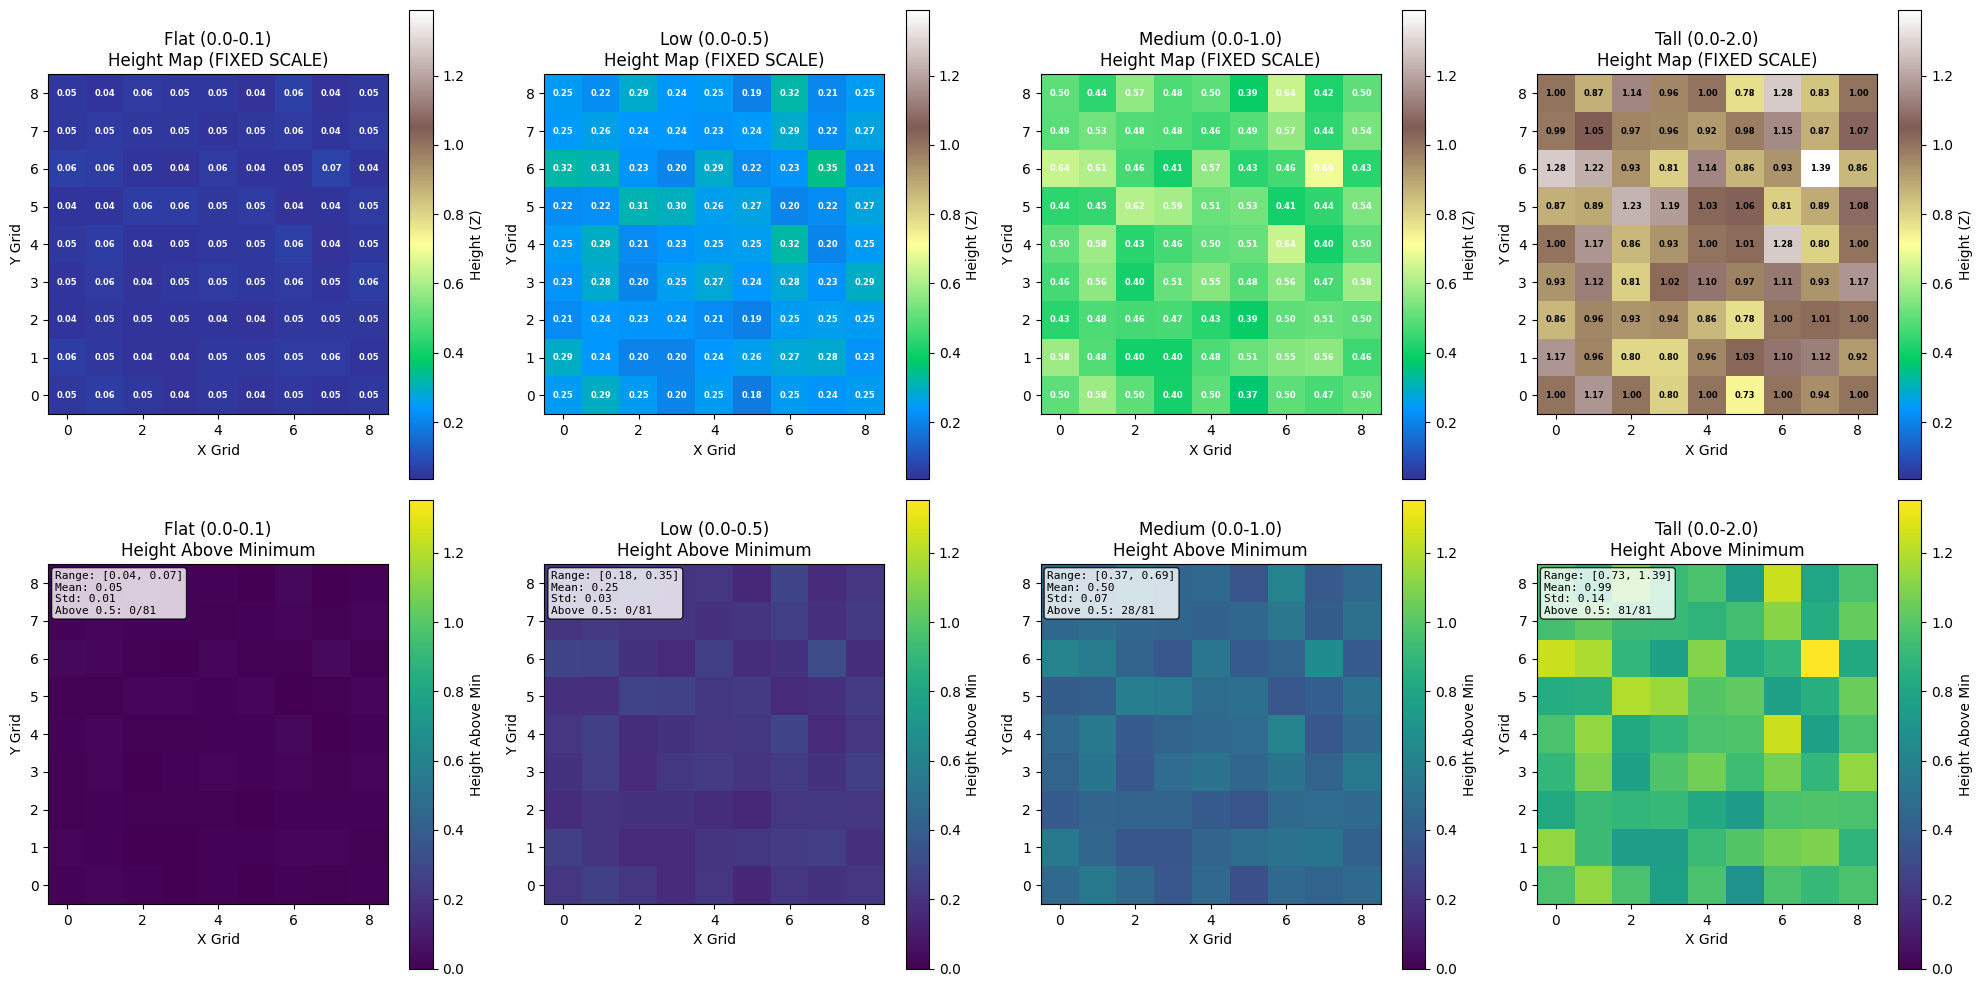

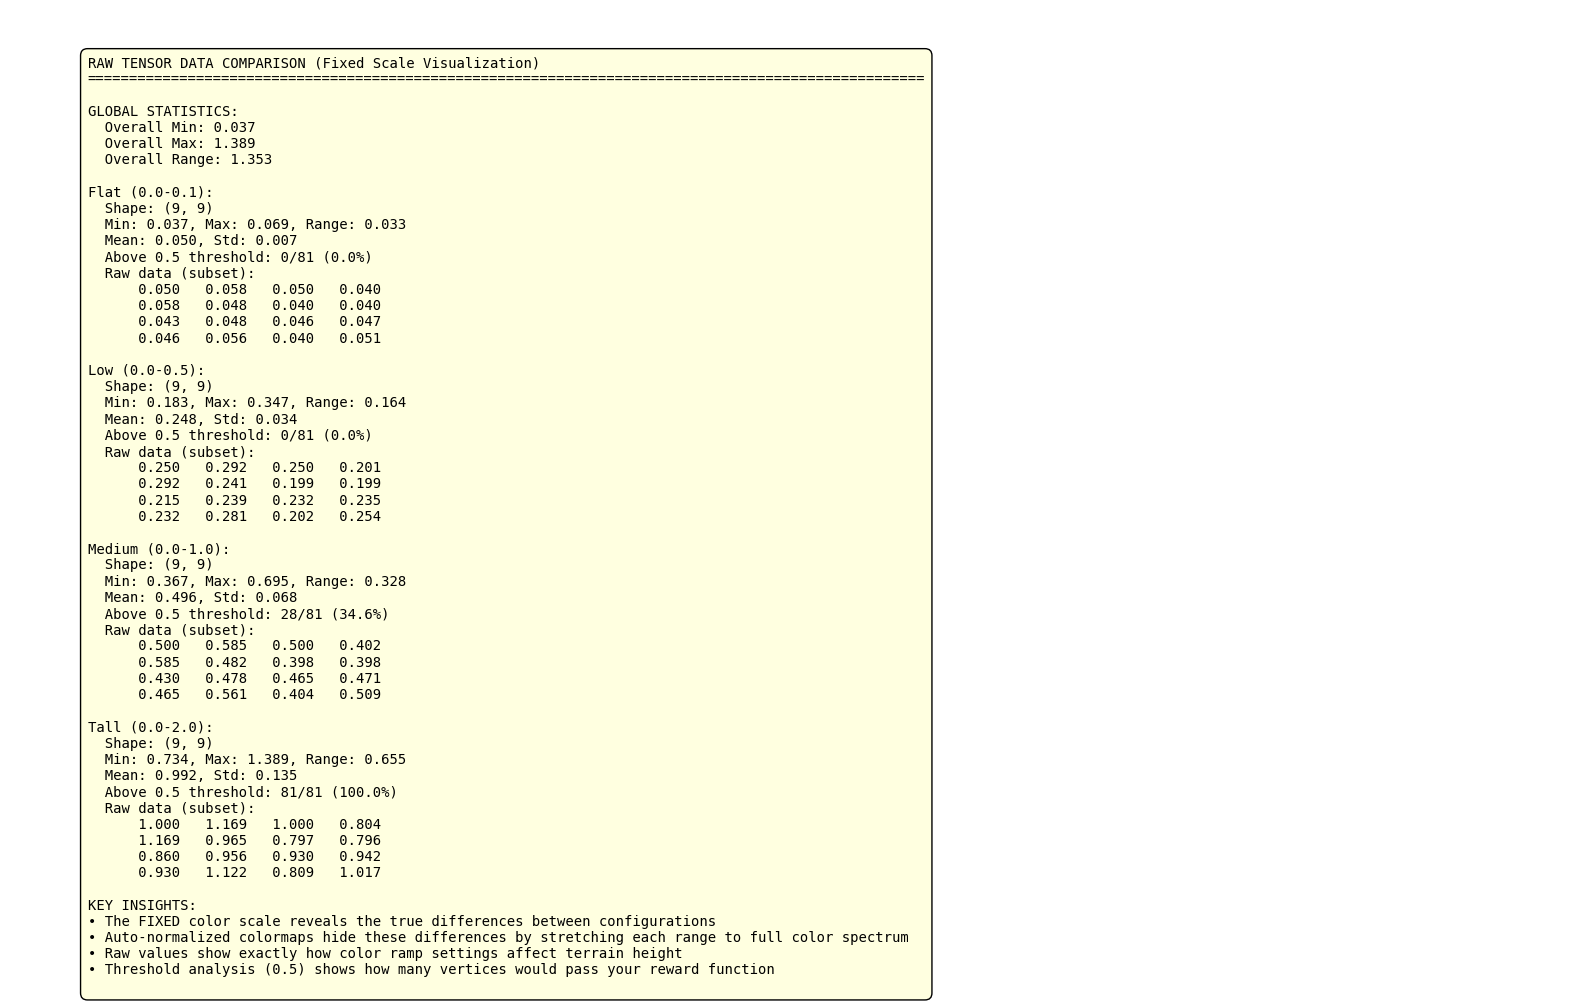

In [14]:
import bpy
import bmesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

def create_test_terrain_for_visualization():
    """
    Create terrain specifically for tensor extraction and visualization
    """
    
    # Clear scene
    bpy.ops.object.select_all(action="SELECT")
    bpy.ops.object.delete(use_global=False)
    
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
    
    # Create node group
    node_group = bpy.data.node_groups.new("VisualizationTerrain", "GeometryNodeTree")
    
    # Add group input/output
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    
    # Set up interface
    if hasattr(node_group, "interface"):
        node_group.interface.new_socket(
            name="Geometry", in_out="INPUT", socket_type="NodeSocketGeometry"
        )
        node_group.interface.new_socket(
            name="Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry"
        )
    
    # Create the proven chain
    noise = node_group.nodes.new("ShaderNodeTexNoise")
    noise.inputs["Scale"].default_value = 3.0
    
    ramp = node_group.nodes.new("ShaderNodeValToRGB")
    separate = node_group.nodes.new("ShaderNodeSeparateRGB")
    
    map_range = node_group.nodes.new("ShaderNodeMapRange")
    map_range.inputs["From Min"].default_value = 0.0
    map_range.inputs["From Max"].default_value = 1.0
    map_range.inputs["To Min"].default_value = 0.0
    map_range.inputs["To Max"].default_value = 1.0
    
    height_multiply = node_group.nodes.new("ShaderNodeMath")
    height_multiply.operation = 'MULTIPLY'
    height_multiply.inputs[1].default_value = 1.0
    
    combine = node_group.nodes.new("ShaderNodeCombineXYZ")
    combine.inputs["X"].default_value = 0.0
    combine.inputs["Y"].default_value = 0.0
    
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Connect nodes
    links = node_group.links
    links.new(noise.outputs["Fac"], ramp.inputs["Fac"])
    links.new(ramp.outputs["Color"], separate.inputs["Image"])
    links.new(separate.outputs["R"], map_range.inputs["Value"])
    links.new(map_range.outputs["Result"], height_multiply.inputs[0])
    links.new(height_multiply.outputs["Value"], combine.inputs["Z"])
    links.new(combine.outputs["Vector"], set_pos.inputs["Offset"])
    links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Create plane with specific resolution
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    plane.name = "VisualizationTerrain"
    
    # Add subdivisions
    bpy.ops.object.mode_set(mode="EDIT")
    bpy.ops.mesh.subdivide(number_cuts=7)  # Creates 8x8 grid
    bpy.ops.object.mode_set(mode="OBJECT")
    
    # Add modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    print("✅ Created visualization terrain (8x8 grid)")
    
    return plane, ramp, height_multiply

def extract_terrain_tensor(plane):
    """
    Extract the actual tensor data from the Blender terrain
    """
    
    # Force update
    bpy.context.view_layer.update()
    
    # Get evaluated geometry
    depsgraph = bpy.context.evaluated_depsgraph_get()
    plane_eval = plane.evaluated_get(depsgraph)
    mesh = plane_eval.to_mesh()
    
    # Extract vertex positions
    vertices = [(v.co.x, v.co.y, v.co.z) for v in mesh.vertices]
    positions = np.array(vertices)
    x_coords = positions[:, 0]
    y_coords = positions[:, 1]
    z_coords = positions[:, 2]
    
    # Determine grid size
    unique_x = np.unique(np.round(x_coords, 3))
    unique_y = np.unique(np.round(y_coords, 3))
    grid_size = len(unique_x)
    
    # Create height tensor
    height_tensor = np.zeros((grid_size, grid_size))
    
    # Map vertices to grid positions
    for i, (x, y, z) in enumerate(vertices):
        x_idx = np.argmin(np.abs(unique_x - x))
        y_idx = np.argmin(np.abs(unique_y - y))
        height_tensor[y_idx, x_idx] = z
    
    # Clean up
    plane_eval.to_mesh_clear()
    
    return height_tensor, unique_x, unique_y

def visualize_tensor_with_fixed_scale(tensors_dict, global_vmin=None, global_vmax=None):
    """
    Visualize tensors with FIXED color scale to show real differences
    """
    
    print(f"\n📊 Creating FIXED SCALE visualization...")
    
    # Calculate global min/max if not provided
    if global_vmin is None or global_vmax is None:
        all_values = np.concatenate([tensor.flatten() for tensor in tensors_dict.values()])
        global_vmin = all_values.min()
        global_vmax = all_values.max()
    
    print(f"   Using FIXED color scale: [{global_vmin:.3f}, {global_vmax:.3f}]")
    
    n_configs = len(tensors_dict)
    fig, axes = plt.subplots(2, n_configs, figsize=(5*n_configs, 10))
    
    if n_configs == 1:
        axes = axes.reshape(2, 1)
    
    # Create fixed colormap
    for i, (name, tensor) in enumerate(tensors_dict.items()):
        
        # Top row: Height map with FIXED scale
        ax_height = axes[0, i] if n_configs > 1 else axes[0]
        im = ax_height.imshow(tensor, cmap='terrain', origin='lower', 
                             vmin=global_vmin, vmax=global_vmax)  # FIXED SCALE!
        ax_height.set_title(f'{name}\nHeight Map (FIXED SCALE)')
        ax_height.set_xlabel('X Grid')
        ax_height.set_ylabel('Y Grid')
        
        # Add colorbar with fixed scale
        cbar = plt.colorbar(im, ax=ax_height)
        cbar.set_label('Height (Z)')
        
        # Add actual values as text
        for row in range(tensor.shape[0]):
            for col in range(tensor.shape[1]):
                value = tensor[row, col]
                # Color text based on value relative to global range
                text_color = 'white' if value < (global_vmin + global_vmax) / 2 else 'black'
                ax_height.text(col, row, f'{value:.2f}', 
                              ha='center', va='center', fontsize=6,
                              color=text_color, weight='bold')
        
        # Bottom row: Difference from minimum (shows the actual variation)
        ax_diff = axes[1, i] if n_configs > 1 else axes[1]
        diff_tensor = tensor - global_vmin  # Show height above minimum
        im_diff = ax_diff.imshow(diff_tensor, cmap='viridis', origin='lower',
                                vmin=0, vmax=global_vmax-global_vmin)
        ax_diff.set_title(f'{name}\nHeight Above Minimum')
        ax_diff.set_xlabel('X Grid')
        ax_diff.set_ylabel('Y Grid')
        
        cbar_diff = plt.colorbar(im_diff, ax=ax_diff)
        cbar_diff.set_label('Height Above Min')
        
        # Add statistics box
        stats_text = f"""Range: [{tensor.min():.2f}, {tensor.max():.2f}]
Mean: {tensor.mean():.2f}
Std: {tensor.std():.2f}
Above 0.5: {(tensor > 0.5).sum()}/{tensor.size}"""
        
        ax_diff.text(0.02, 0.98, stats_text, transform=ax_diff.transAxes,
                    verticalalignment='top', fontsize=8, fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    save_path = "/tmp/fixed_scale_comparison.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"   💾 Saved fixed scale comparison: {save_path}")
    
    return fig

def create_side_by_side_raw_data_comparison(tensors_dict):
    """
    Show raw numerical data side by side with fixed formatting
    """
    
    print(f"\n📋 Creating raw data comparison...")
    
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.axis('off')
    
    # Create text comparison
    comparison_text = "RAW TENSOR DATA COMPARISON (Fixed Scale Visualization)\n"
    comparison_text += "=" * 100 + "\n\n"
    
    # Global statistics
    all_values = np.concatenate([tensor.flatten() for tensor in tensors_dict.values()])
    comparison_text += f"GLOBAL STATISTICS:\n"
    comparison_text += f"  Overall Min: {all_values.min():.3f}\n"
    comparison_text += f"  Overall Max: {all_values.max():.3f}\n"
    comparison_text += f"  Overall Range: {all_values.max() - all_values.min():.3f}\n\n"
    
    # Individual tensor data
    for name, tensor in tensors_dict.items():
        comparison_text += f"{name}:\n"
        comparison_text += f"  Shape: {tensor.shape}\n"
        comparison_text += f"  Min: {tensor.min():.3f}, Max: {tensor.max():.3f}, Range: {tensor.max()-tensor.min():.3f}\n"
        comparison_text += f"  Mean: {tensor.mean():.3f}, Std: {tensor.std():.3f}\n"
        comparison_text += f"  Above 0.5 threshold: {(tensor > 0.5).sum()}/{tensor.size} ({(tensor > 0.5).sum()/tensor.size*100:.1f}%)\n"
        
        # Show actual data (first few rows/cols)
        comparison_text += f"  Raw data (subset):\n"
        subset_size = min(4, tensor.shape[0])
        for i in range(subset_size):
            comparison_text += "    "
            for j in range(min(4, tensor.shape[1])):
                comparison_text += f"{tensor[i,j]:7.3f} "
            comparison_text += "\n"
        comparison_text += "\n"
    
    # Key insights
    comparison_text += "KEY INSIGHTS:\n"
    comparison_text += "• The FIXED color scale reveals the true differences between configurations\n"
    comparison_text += "• Auto-normalized colormaps hide these differences by stretching each range to full color spectrum\n"
    comparison_text += "• Raw values show exactly how color ramp settings affect terrain height\n"
    comparison_text += "• Threshold analysis (0.5) shows how many vertices would pass your reward function\n"
    
    ax.text(0.05, 0.95, comparison_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=10, fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow"))
    
    save_path = "/tmp/raw_data_comparison.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"   💾 Saved raw data comparison: {save_path}")
    
    return fig

def test_different_configurations_with_fixed_scale(plane, ramp_node, height_multiply):
    """
    Test different configurations and visualize with FIXED color scale
    """
    
    print("\n🎨 Testing configurations with FIXED color scale...")
    
    color_ramp = ramp_node.color_ramp
    
    # Test configurations with VERY different height ranges
    test_configs = [
        {
            "name": "Flat (0.0-0.1)",
            "colors": [(0.0, 0.0, 0.0, 1.0), (0.1, 0.1, 0.1, 1.0)],
            "height_scale": 1.0
        },
        {
            "name": "Low (0.0-0.5)",
            "colors": [(0.0, 0.0, 0.0, 1.0), (0.5, 0.5, 0.5, 1.0)],
            "height_scale": 1.0
        },
        {
            "name": "Medium (0.0-1.0)",
            "colors": [(0.0, 0.0, 0.0, 1.0), (1.0, 1.0, 1.0, 1.0)],
            "height_scale": 1.0
        },
        {
            "name": "Tall (0.0-2.0)",
            "colors": [(0.0, 0.0, 0.0, 1.0), (1.0, 1.0, 1.0, 1.0)],
            "height_scale": 2.0
        }
    ]
    
    tensors = {}
    
    for config in test_configs:
        print(f"\n--- Testing: {config['name']} ---")
        
        # Apply configuration
        color_ramp.elements[0].color = config["colors"][0]
        color_ramp.elements[1].color = config["colors"][1]
        height_multiply.inputs[1].default_value = config["height_scale"]
        
        # Force update and extract
        bpy.context.view_layer.update()
        tensor, _, _ = extract_terrain_tensor(plane)
        tensors[config["name"]] = tensor
        
        print(f"   Applied: {config['colors'][0]} → {config['colors'][1]}")
        print(f"   Height scale: {config['height_scale']}")
        print(f"   Result range: [{tensor.min():.3f}, {tensor.max():.3f}]")
        print(f"   Above 0.5: {(tensor > 0.5).sum()}/{tensor.size}")
    
    return tensors

def prove_fixed_scale_differences():
    """
    Ultimate proof with fixed color scales showing real differences
    """
    
    print("🔬 PROVING REAL DIFFERENCES WITH FIXED COLOR SCALES")
    print("=" * 80)
    print("This will show the ACTUAL differences between configurations!")
    print("No more normalized colormaps hiding the truth!")
    
    # Create terrain
    plane, ramp_node, height_multiply = create_test_terrain_for_visualization()
    
    # Test different configurations
    tensors = test_different_configurations_with_fixed_scale(plane, ramp_node, height_multiply)
    
    # Create fixed scale visualization
    visualize_tensor_with_fixed_scale(tensors)
    
    # Create raw data comparison
    create_side_by_side_raw_data_comparison(tensors)
    
    # Create a dramatic demonstration
    print(f"\n🎯 DRAMATIC DIFFERENCE DEMONSTRATION:")
    
    # Show the actual numbers
    for name, tensor in tensors.items():
        print(f"\n{name}:")
        print(f"  Min: {tensor.min():.3f}")
        print(f"  Max: {tensor.max():.3f}")
        print(f"  Range: {tensor.max() - tensor.min():.3f}")
        print(f"  Mean: {tensor.mean():.3f}")
        print(f"  Values > 0.5: {(tensor > 0.5).sum()}/{tensor.size} = {(tensor > 0.5).sum()/tensor.size*100:.1f}%")
        
        # Show a few actual values
        print(f"  Sample values: [{tensor.flat[0]:.3f}, {tensor.flat[1]:.3f}, {tensor.flat[2]:.3f}, ...]")
    
    # Calculate differences between configurations
    print(f"\n📊 CONFIGURATION DIFFERENCES:")
    config_names = list(tensors.keys())
    for i in range(len(config_names)-1):
        name1, name2 = config_names[i], config_names[i+1]
        tensor1, tensor2 = tensors[name1], tensors[name2]
        
        max_diff = np.abs(tensor2.max() - tensor1.max())
        mean_diff = np.abs(tensor2.mean() - tensor1.mean())
        
        print(f"  {name1} vs {name2}:")
        print(f"    Max height difference: {max_diff:.3f}")
        print(f"    Mean height difference: {mean_diff:.3f}")
    
    # Save everything
    bpy.ops.wm.save_as_mainfile(filepath="/tmp/fixed_scale_proof.blend")
    
    print(f"\n{'='*80}")
    print("🎯 FIXED SCALE PROOF COMPLETE!")
    print(f"{'='*80}")
    print("✅ Generated configurations with VERY different height ranges")
    print("✅ Used FIXED color scale to show true differences")
    print("✅ Raw data proves the configurations produce different terrains")
    print("✅ Threshold analysis shows impact on reward function")
    
    print(f"\n📁 Generated Files:")
    print(f"   • /tmp/fixed_scale_comparison.png - Fixed scale visualization")
    print(f"   • /tmp/raw_data_comparison.png - Raw numerical data")
    print(f"   • /tmp/fixed_scale_proof.blend - Blender proof file")
    
    print(f"\n🔍 Key Insight:")
    print(f"   With FIXED color scales, you can see that:")
    print(f"   • 'Flat' terrain stays near zero (dark colors)")
    print(f"   • 'Tall' terrain reaches 2.0+ (bright colors)")
    print(f"   • Normalized colormaps would make them look identical!")
    
    return tensors

if __name__ == "__main__":
    tensors = prove_fixed_scale_differences()

# intigration testing

🧪 Starting GitHub Sampler Test...
🚀 COMPLETE GITHUB SAMPLER TEST

🚀 Testing GitHub Sampler Implementation
🎯 Setting up Blender Environment from GitHub code...
🎨 Blender ColorRamp Environment created
  Max colors: 5
  Color choices: 32
  Available scales: 7
🔗 Connecting to Blender...
🔗 Connected to Blender
✅ Successfully connected to Blender

1️⃣ Testing single trajectory sampling...
✅ Sampled trajectory with 6 steps

📋 Trajectory details:
   Step 1: Scale=None, Colors=0, Action=6
   Step 2: Scale=20.0, Colors=0, Action=60
   Step 3: Scale=20.0, Colors=1, Action=96
   Step 4: Scale=20.0, Colors=2, Action=137
   Step 5: Scale=20.0, Colors=3, Action=110
   Step 6: Scale=20.0, Colors=4, Action=20

2️⃣ Testing batch sampling (20 trajectories)...
Sampled 10/20 trajectories
Sampled 20/20 trajectories
✅ Sampled 20 trajectories
   Trajectory lengths: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
   Average length: 6.0
   Length range: [6, 6]

📋 Sample trajectory details:
   Traj 

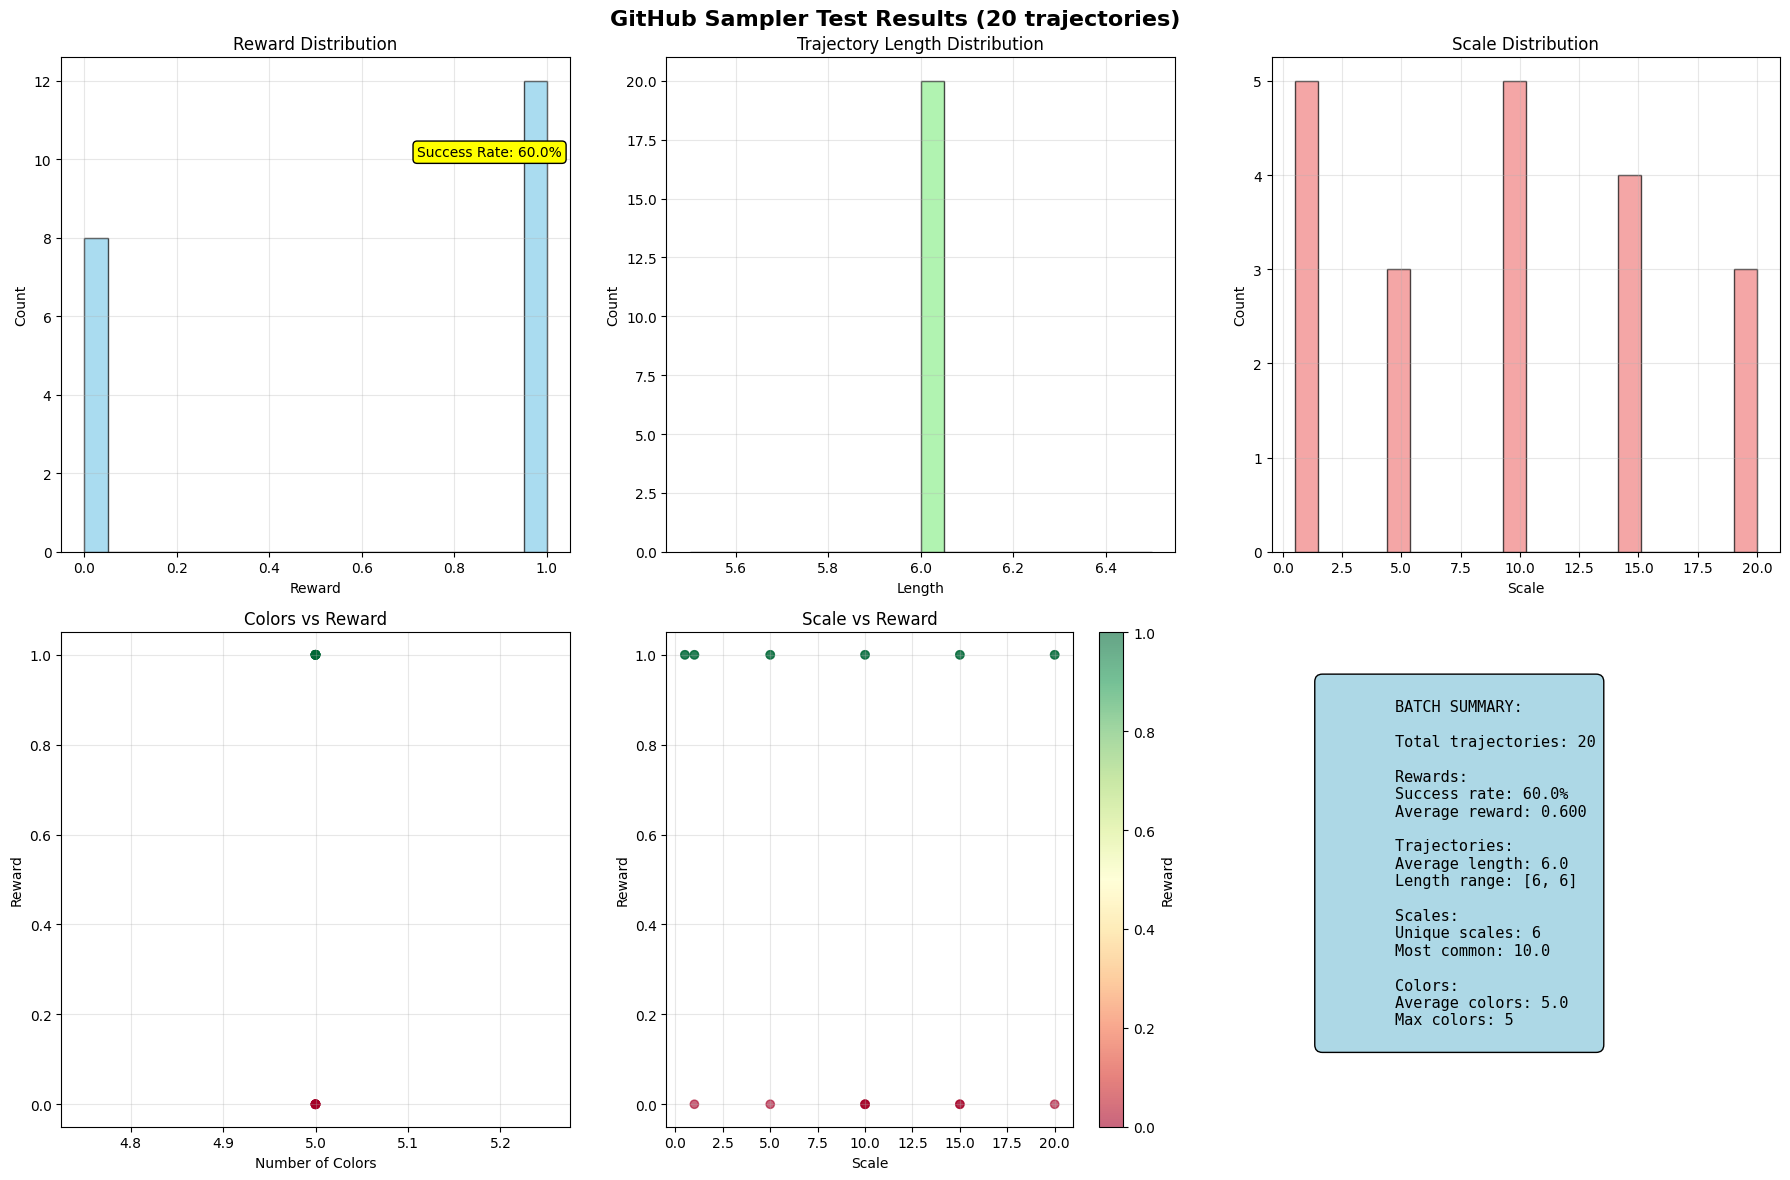

✅ GitHub visualization complete

5️⃣ Analyzing sampler behavior...

📊 Success Analysis:
   Successful trajectories: 12
   Failed trajectories: 8

✅ Successful trajectory example:
   Length: 6
   Terminal: True
   Scale: 1.0
   Colors count: 5


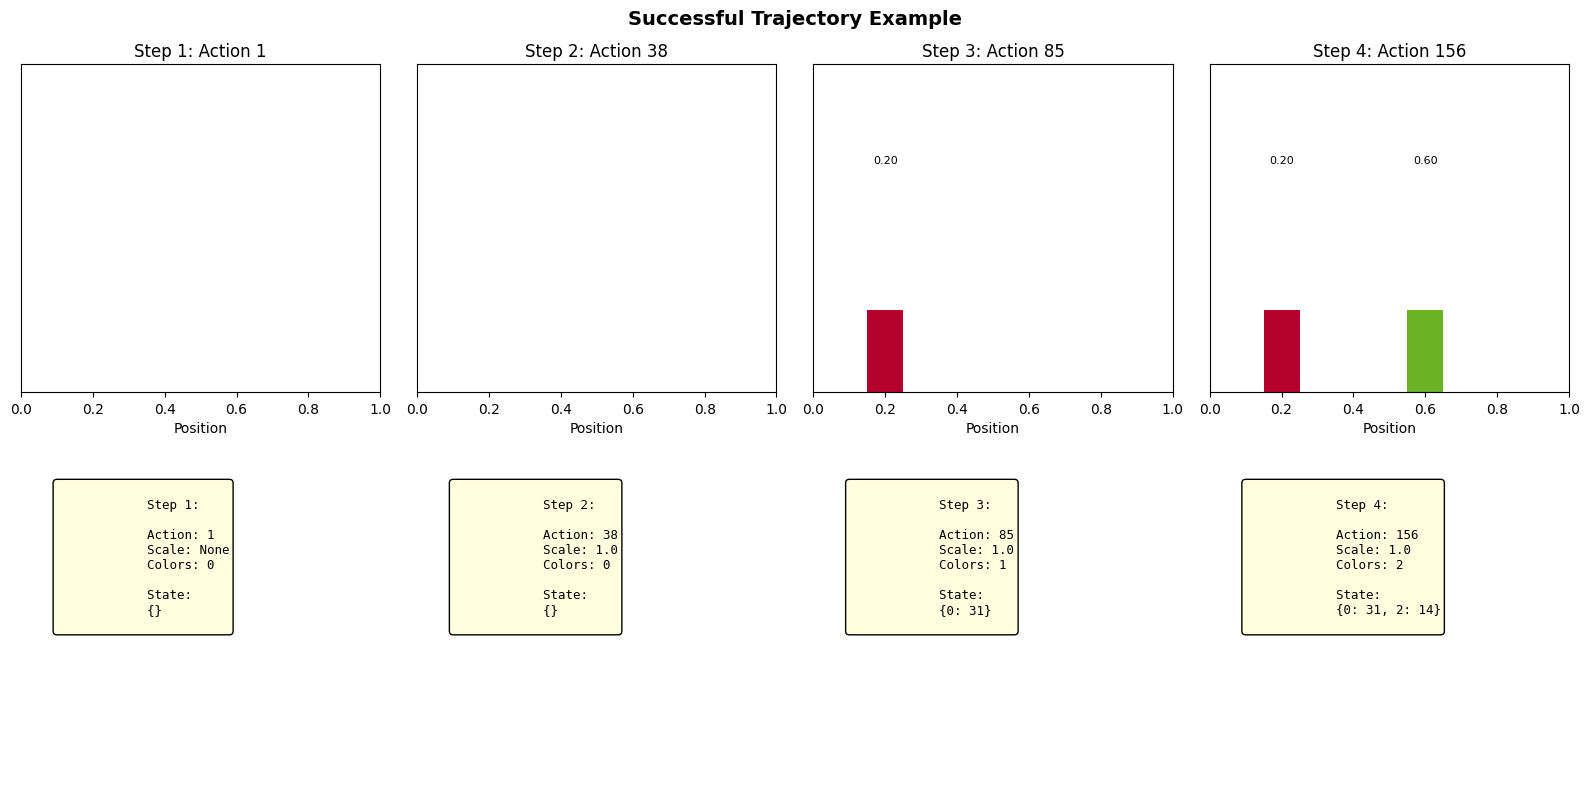


❌ Failed trajectory example:
   Length: 6
   Terminal: True
   Scale: 1.0
   Colors count: 5

🎯 SUMMARY:
   Environment: BlenderColorRampEnvironment
   Max colors: 5
   Color choices: 32
   Available scales: 7
   Trajectories tested: 20
   Success rate: 12/20 (60.0%)
   Average trajectory length: 6.0

🔧 Testing individual state operations:
   Initial state: Scale=None, Colors=0
   Valid actions from initial state: 7 actions
   First few actions: [0, 1, 2, 3, 4]...
   After first action: Scale=0.5, Colors=0
   Is terminal: False

✅ All tests completed successfully!

🏗️ DEMONSTRATING STATE CONSTRUCTION
1. Initial state: ColorRampState(scale=None, colors={}, step_count=0)
   Scale: None
   Colors: {}
   Step count: 0
   Is terminal: False

2. Valid actions: 7
   Available scales: [0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0]

3. After action 0:
   Scale: 0.5
   Colors: {}
   Step count: 1
   Is terminal: False

4. After color action 7:
   Scale: 0.5
   Colors: {0: 0}
   Step count: 2
   Is term

In [24]:
# Import the sampler from your GitHub repository
from blender_gfn_experiment import (
    BlenderColorRampEnvironment, 
    BlenderTrajectorySamplerUtilities,  # Corrected class name
    BlenderVisualizationUtility,        # Added visualization utility
    ColorRampState,
    create_blender_environment
)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Dict
import random

# ============================================================================
# 1. SETUP ENVIRONMENT FROM YOUR GITHUB CODE
# ============================================================================
def setup_blender_environment():
    """Setup the environment using your GitHub implementation"""
    
    print("🎯 Setting up Blender Environment from GitHub code...")
    
    # Create environment using your existing factory function
    env = create_blender_environment(max_colors=5, num_color_choices=32)
    
    # Connect to Blender (this sets up the terrain procedure)
    print("🔗 Connecting to Blender...")
    
    # Your environment should have the create_color_ramp_procedure method
    try:
        plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
        env.connect_blender(plane, None, nodes)
        print("✅ Successfully connected to Blender")
        
        return env, plane, nodes
        
    except Exception as e:
        print(f"❌ Error connecting to Blender: {e}")
        print("💡 This is expected if not running in Blender - using mock environment")
        # Return mock environment for testing
        return env, None, None

# ============================================================================
# 2. TEST TRAJECTORY SAMPLING FROM YOUR GITHUB CODE
# ============================================================================
def test_github_sampler():
    """Test the trajectory sampling from your GitHub implementation"""
    
    print("\n🚀 Testing GitHub Sampler Implementation")
    print("=" * 50)
    
    # Setup environment
    env, plane, nodes = setup_blender_environment()
    
    if env is None:
        print("❌ Failed to setup environment")
        return None, None
    
    # Test single trajectory sampling
    print("\n1️⃣ Testing single trajectory sampling...")
    
    try:
        # Use the correct class name from GitHub code
        trajectory = BlenderTrajectorySamplerUtilities.sample_trajectory(env)
        
        print(f"✅ Sampled trajectory with {len(trajectory)} steps")
        
        # Print trajectory details
        print("\n📋 Trajectory details:")
        for i, (state, action) in enumerate(trajectory):
            print(f"   Step {i+1}: Scale={state.scale}, Colors={len(state.colors)}, Action={action}")
        
        return trajectory, env
        
    except Exception as e:
        print(f"❌ Error sampling trajectory: {e}")
        import traceback
        traceback.print_exc()
        return None, env

def test_batch_sampling(env, n_trajectories=10):
    """Test batch sampling from your GitHub implementation"""
    
    print(f"\n2️⃣ Testing batch sampling ({n_trajectories} trajectories)...")
    
    try:
        # Use the correct method from GitHub code
        trajectories = BlenderTrajectorySamplerUtilities.sample_batch(env, n_trajectories)
        
        print(f"✅ Sampled {len(trajectories)} trajectories")
        
        # Analyze batch
        lengths = [len(traj) for traj in trajectories]
        print(f"   Trajectory lengths: {lengths}")
        print(f"   Average length: {np.mean(lengths):.1f}")
        print(f"   Length range: [{min(lengths)}, {max(lengths)}]")
        
        # Show some trajectory details
        print(f"\n📋 Sample trajectory details:")
        for i, traj in enumerate(trajectories[:3]):  # Show first 3
            if traj:
                final_state = traj[-1][0]  # Get final state
                final_action = traj[-1][1]  # Get final action
                # Apply final action to get terminal state
                terminal_state = env.apply_action(final_state, final_action)
                print(f"   Traj {i+1}: Length={len(traj)}, Scale={terminal_state.scale}, Colors={len(terminal_state.colors)}")
        
        return trajectories
        
    except Exception as e:
        print(f"❌ Error in batch sampling: {e}")
        import traceback
        traceback.print_exc()
        return []

def test_trajectory_evaluation(env, trajectories):
    """Test trajectory evaluation from your GitHub implementation"""
    
    print(f"\n3️⃣ Testing trajectory evaluation...")
    
    try:
        # Use the correct method from GitHub code
        evaluations = BlenderTrajectorySamplerUtilities.evaluate_batch(env, trajectories)
        
        print(f"✅ Evaluated {len(evaluations)} trajectories")
        
        # Analyze results
        rewards = [eval_result['reward'] for eval_result in evaluations]
        success_rate = sum(1 for r in rewards if r > 0) / len(rewards) if rewards else 0
        
        print(f"   Rewards: {rewards}")
        print(f"   Success rate: {success_rate:.2%}")
        print(f"   Total successes: {sum(1 for r in rewards if r > 0)}/{len(rewards)}")
        
        # Print detailed results
        print(f"\n📊 Detailed evaluation results:")
        for i, result in enumerate(evaluations):
            status = "✅" if result['reward'] > 0 else "❌"
            print(f"   Trajectory {i+1}: {status} reward={result['reward']}, "
                  f"length={result['length']}, terminal={result['terminal']}, "
                  f"scale={result.get('scale', 'N/A')}, colors={result.get('colors_count', 'N/A')}")
        
        return evaluations
        
    except Exception as e:
        print(f"❌ Error in trajectory evaluation: {e}")
        import traceback
        traceback.print_exc()
        return []

# ============================================================================
# 3. VISUALIZE SAMPLING RESULTS USING GITHUB UTILITIES
# ============================================================================
def visualize_sampling_results_github(env, trajectories, evaluations):
    """Use GitHub visualization utilities"""
    
    print(f"\n4️⃣ Using GitHub visualization utilities...")
    
    try:
        # Use the GitHub visualization utility for batch results
        BlenderVisualizationUtility.visualize_batch_results(
            env, trajectories, evaluations, 
            title="GitHub Sampler Test Results"
        )
        print("✅ GitHub visualization complete")
        
    except Exception as e:
        print(f"❌ Error with GitHub visualization: {e}")
        # Fallback to custom visualization
        visualize_sampling_results_custom(trajectories, evaluations)

def visualize_sampling_results_custom(trajectories, evaluations):
    """Custom visualization as fallback"""
    
    print(f"📊 Using custom visualization...")
    
    if not trajectories or not evaluations:
        print("❌ No data to visualize")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Trajectory lengths
    lengths = [len(traj) for traj in trajectories]
    axes[0, 0].hist(lengths, bins=min(10, max(lengths)-min(lengths)+1), 
                    alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Trajectory Length Distribution')
    axes[0, 0].set_xlabel('Trajectory Length')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Rewards
    rewards = [eval_result['reward'] for eval_result in evaluations]
    success_count = sum(1 for r in rewards if r > 0)
    fail_count = len(rewards) - success_count
    
    axes[0, 1].bar(['Success', 'Failure'], [success_count, fail_count], 
                   color=['green', 'red'], alpha=0.7)
    axes[0, 1].set_title('Success vs Failure')
    axes[0, 1].set_ylabel('Count')
    
    # Add percentages
    total = len(rewards)
    if total > 0:
        axes[0, 1].text(0, success_count + 0.1, f'{success_count/total:.1%}', 
                        ha='center', va='bottom', fontweight='bold')
        axes[0, 1].text(1, fail_count + 0.1, f'{fail_count/total:.1%}', 
                        ha='center', va='bottom', fontweight='bold')
    
    # 3. Terminal states analysis
    terminal_counts = [eval_result['terminal'] for eval_result in evaluations]
    terminal_true = sum(terminal_counts)
    terminal_false = len(terminal_counts) - terminal_true
    
    if terminal_true + terminal_false > 0:
        axes[1, 0].pie([terminal_true, terminal_false], 
                       labels=[f'Terminal ({terminal_true})', f'Non-terminal ({terminal_false})'],
                       colors=['lightgreen', 'lightcoral'], autopct='%1.1f%%')
    axes[1, 0].set_title('Terminal vs Non-terminal States')
    
    # 4. Colors count distribution
    if evaluations and 'colors_count' in evaluations[0]:
        colors_counts = [eval_result['colors_count'] for eval_result in evaluations]
        unique_counts = list(set(colors_counts))
        count_freq = [colors_counts.count(c) for c in unique_counts]
        
        axes[1, 1].bar(unique_counts, count_freq, alpha=0.7, color='purple')
        axes[1, 1].set_title('Number of Colors Distribution')
        axes[1, 1].set_xlabel('Number of Colors')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Colors count\nnot available', 
                        ha='center', va='center', transform=axes[1, 1].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1, 1].set_title('Colors Analysis')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Custom visualization complete")

# ============================================================================
# 4. ANALYZE SAMPLER BEHAVIOR
# ============================================================================
def analyze_sampler_behavior(env, trajectories, evaluations):
    """Analyze the behavior of your GitHub sampler"""
    
    print(f"\n5️⃣ Analyzing sampler behavior...")
    
    # Success vs failure analysis
    successful_trajectories = []
    failed_trajectories = []
    
    for i, eval_result in enumerate(evaluations):
        if eval_result['reward'] > 0:
            successful_trajectories.append((trajectories[i], eval_result))
        else:
            failed_trajectories.append((trajectories[i], eval_result))
    
    print(f"\n📊 Success Analysis:")
    print(f"   Successful trajectories: {len(successful_trajectories)}")
    print(f"   Failed trajectories: {len(failed_trajectories)}")
    
    if successful_trajectories:
        print(f"\n✅ Successful trajectory example:")
        traj, result = successful_trajectories[0]
        print(f"   Length: {result['length']}")
        print(f"   Terminal: {result['terminal']}")
        print(f"   Scale: {result.get('scale', 'N/A')}")
        print(f"   Colors count: {result.get('colors_count', 'N/A')}")
        
        # Try to use GitHub visualization for a successful trajectory
        try:
            BlenderVisualizationUtility.visualize_trajectory(
                env, traj, title="Successful Trajectory Example"
            )
        except Exception as e:
            print(f"   Note: Could not visualize trajectory: {e}")
    
    if failed_trajectories:
        print(f"\n❌ Failed trajectory example:")
        traj, result = failed_trajectories[0]
        print(f"   Length: {result['length']}")
        print(f"   Terminal: {result['terminal']}")
        print(f"   Scale: {result.get('scale', 'N/A')}")
        print(f"   Colors count: {result.get('colors_count', 'N/A')}")
    
    return successful_trajectories, failed_trajectories

# ============================================================================
# 5. TEST SAMPLE AND EVALUATE UTILITY
# ============================================================================
def test_sample_and_evaluate(env, n_trajectories=15):
    """Test the combined sample_and_evaluate utility from GitHub"""
    
    print(f"\n6️⃣ Testing combined sample_and_evaluate utility...")
    
    try:
        # Use the GitHub utility that combines sampling and evaluation
        trajectories, evaluations = BlenderTrajectorySamplerUtilities.sample_and_evaluate(
            env, n_trajectories
        )
        
        print(f"✅ Combined sampling and evaluation complete")
        print(f"   Trajectories: {len(trajectories)}")
        print(f"   Evaluations: {len(evaluations)}")
        
        # Quick analysis
        rewards = [eval_result['reward'] for eval_result in evaluations]
        success_rate = sum(1 for r in rewards if r > 0) / len(rewards) if rewards else 0
        
        print(f"   Success rate: {success_rate:.2%}")
        
        return trajectories, evaluations
        
    except Exception as e:
        print(f"❌ Error in combined sample_and_evaluate: {e}")
        import traceback
        traceback.print_exc()
        return [], []

# ============================================================================
# 6. MAIN TEST FUNCTION
# ============================================================================
def run_complete_sampler_test():
    """Run complete test of the GitHub sampler"""
    
    print("🚀 COMPLETE GITHUB SAMPLER TEST")
    print("=" * 60)
    
    # 1. Test single trajectory
    trajectory, env = test_github_sampler()
    
    if trajectory is None or env is None:
        print("❌ Initial test failed, stopping")
        return None
    
    # 2. Test batch sampling
    trajectories = test_batch_sampling(env, n_trajectories=20)
    
    if not trajectories:
        print("❌ Batch sampling failed, stopping")
        return None
    
    # 3. Test evaluation
    evaluations = test_trajectory_evaluation(env, trajectories)
    
    if not evaluations:
        print("❌ Evaluation failed, stopping")
        return None
    
    # 4. Test combined sample_and_evaluate
    combined_trajectories, combined_evaluations = test_sample_and_evaluate(env, 15)
    
    # 5. Visualize results (try GitHub visualization first)
    print(f"\n📊 Visualizing results...")
    visualize_sampling_results_github(env, trajectories, evaluations)
    
    # 6. Analyze behavior
    successful, failed = analyze_sampler_behavior(env, trajectories, evaluations)
    
    # 7. Summary
    print(f"\n🎯 SUMMARY:")
    print(f"   Environment: {env.__class__.__name__}")
    print(f"   Max colors: {env.max_colors}")
    print(f"   Color choices: {env.num_color_choices}")
    print(f"   Available scales: {len(env.available_scales)}")
    print(f"   Trajectories tested: {len(trajectories)}")
    print(f"   Success rate: {len(successful)}/{len(trajectories)} ({len(successful)/len(trajectories)*100:.1f}%)")
    print(f"   Average trajectory length: {np.mean([len(t) for t in trajectories]):.1f}")
    
    # Test some individual state operations
    print(f"\n🔧 Testing individual state operations:")
    initial_state = env.get_initial_state()
    print(f"   Initial state: Scale={initial_state.scale}, Colors={len(initial_state.colors)}")
    
    valid_actions = env.get_valid_actions(initial_state)
    print(f"   Valid actions from initial state: {len(valid_actions)} actions")
    print(f"   First few actions: {valid_actions[:5]}...")
    
    if valid_actions:
        next_state = env.apply_action(initial_state, valid_actions[0])
        print(f"   After first action: Scale={next_state.scale}, Colors={len(next_state.colors)}")
        print(f"   Is terminal: {env.is_terminal(next_state)}")
    
    return {
        'env': env,
        'trajectories': trajectories,
        'evaluations': evaluations,
        'combined_trajectories': combined_trajectories,
        'combined_evaluations': combined_evaluations,
        'successful': successful,
        'failed': failed
    }

# ============================================================================
# 7. DEMONSTRATE STATE CONSTRUCTION
# ============================================================================
def demonstrate_state_construction(env):
    """Demonstrate how states are constructed step by step"""
    
    print(f"\n🏗️ DEMONSTRATING STATE CONSTRUCTION")
    print("=" * 40)
    
    state = env.get_initial_state()
    print(f"1. Initial state: {state}")
    print(f"   Scale: {state.scale}")
    print(f"   Colors: {state.colors}")
    print(f"   Step count: {state.step_count}")
    print(f"   Is terminal: {env.is_terminal(state)}")
    
    # Try to set scale first
    valid_actions = env.get_valid_actions(state)
    print(f"\n2. Valid actions: {len(valid_actions)}")
    print(f"   Available scales: {env.available_scales}")
    
    if valid_actions:
        # Take first valid action (should be a scale setting)
        action = valid_actions[0]
        state = env.apply_action(state, action)
        print(f"\n3. After action {action}:")
        print(f"   Scale: {state.scale}")
        print(f"   Colors: {state.colors}")
        print(f"   Step count: {state.step_count}")
        print(f"   Is terminal: {env.is_terminal(state)}")
        
        # Now try to add colors
        for step in range(3):  # Try to add a few colors
            valid_actions = env.get_valid_actions(state)
            if not valid_actions:
                print(f"   No more valid actions")
                break
                
            action = valid_actions[0]  # Take first valid action
            state = env.apply_action(state, action)
            print(f"\n{4+step}. After color action {action}:")
            print(f"   Scale: {state.scale}")
            print(f"   Colors: {state.colors}")
            print(f"   Step count: {state.step_count}")
            print(f"   Is terminal: {env.is_terminal(state)}")
            
            if env.is_terminal(state):
                print(f"   ✅ Reached terminal state!")
                # Try to get reward (might not work without Blender)
                try:
                    reward = env.get_reward(state)
                    print(f"   Reward: {reward}")
                except Exception as e:
                    print(f"   Could not get reward (expected without Blender): {e}")
                break

# ============================================================================
# RUN THE TEST
# ============================================================================
if __name__ == "__main__":
    print("🧪 Starting GitHub Sampler Test...")
    
    # Run the complete test
    results = run_complete_sampler_test()
    
    if results:
        print(f"\n✅ All tests completed successfully!")
        
        # Demonstrate state construction
        demonstrate_state_construction(results['env'])
        
        print(f"\n🎉 Test suite complete!")
        print(f"   Check the visualizations above for detailed results")
        print(f"   Environment is ready for further testing or training")
        
    else:
        print(f"\n❌ Tests failed - check error messages above")

🎯 GFLOWNET + BLENDER TRAINING SETUP
1. Creating Blender environment...
✅ Blender terrain initialized
2. Creating GFlowNet model...
   Model parameters: 17,509
   Initial logZ: 5.000
3. Starting training loop...
🚀 Starting GFlowNet Training Loop
   Steps: 50
   Learning rate: 0.001
   Initial logZ: 5.000

Step   0: ❌ R=0.0, L=549.7083, logZ=4.999
Step   1: ✅ R=1.0, L=30.0572, logZ=4.998
Step   2: ✅ R=1.0, L=28.7694, logZ=4.997
Step   3: ✅ R=1.0, L=25.7198, logZ=4.996
Step   4: ✅ R=1.0, L=27.1770, logZ=4.995
Step   5: ✅ R=1.0, L=25.1107, logZ=4.994
Step   6: ✅ R=1.0, L=24.1153, logZ=4.993
Step   8: ✅ R=1.0, L=28.8749, logZ=4.991
Step   9: ✅ R=1.0, L=25.7729, logZ=4.990
Step  10: ✅ R=1.0, L=24.1543, logZ=4.989
Step  11: ✅ R=1.0, L=24.4803, logZ=4.988
Step  13: ✅ R=1.0, L=23.6840, logZ=4.986
Step  14: ✅ R=1.0, L=26.0578, logZ=4.985
Step  15: ✅ R=1.0, L=25.0000, logZ=4.984
Step  17: ✅ R=1.0, L=24.4752, logZ=4.982
Step  18: ✅ R=1.0, L=26.3693, logZ=4.981
Step  19: ✅ R=1.0, L=26.0189, logZ=4.

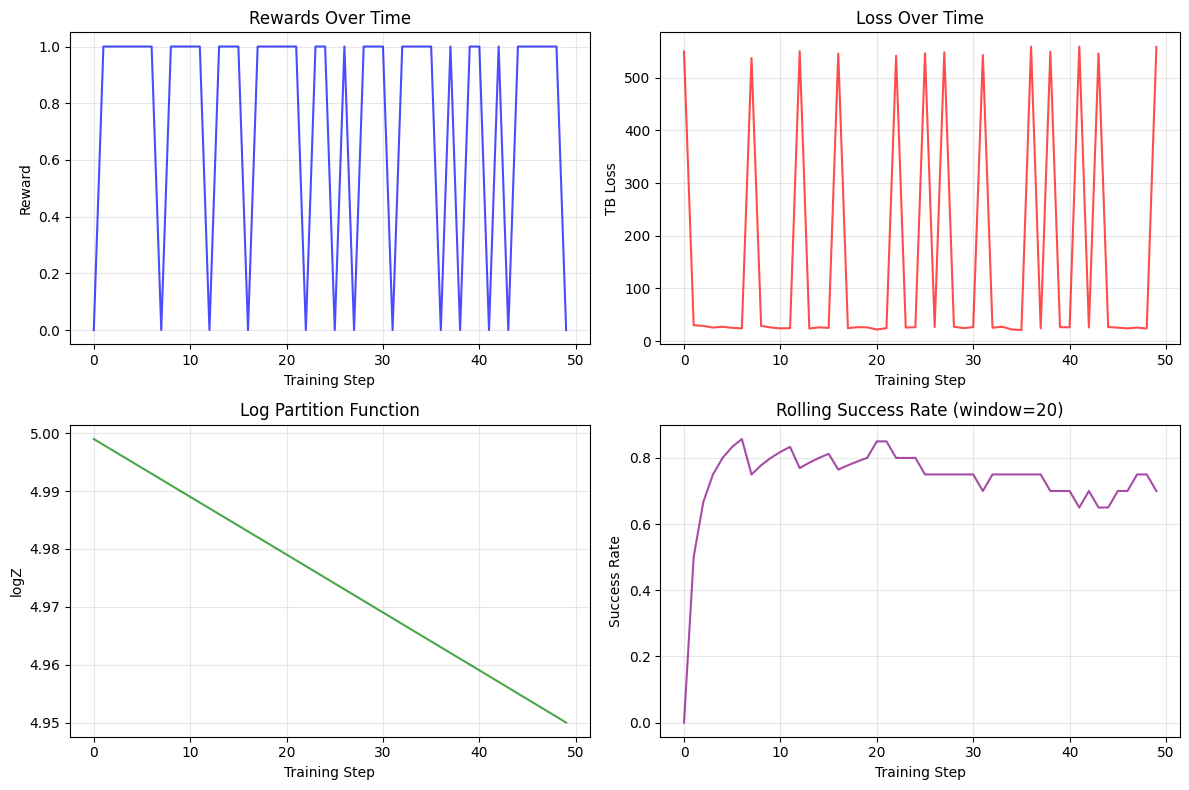


✅ Setup and training complete!
   Environment: 3 colors, 6 choices
   Model: 20D state, 64D hidden
   Results: 100.0% success rate


(<__main__.BlenderGFlowNetEnvironment at 0x70f6b5425810>,
 GFlowNetTB(
   (forward_net): Sequential(
     (0): Linear(in_features=20, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=50, bias=True)
   )
   (backward_net): Sequential(
     (0): Linear(in_features=20, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=50, bias=True)
   )
 ),
 {'success_rate': 1.0,
  'avg_reward': 0.74,
  'final_logZ': 4.9499921798706055,
  'rewards': [0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,


In [19]:
setup_and_train()

## mini train loop

In [38]:
# Fixed Blender Color Ramp Translation
import bpy

def fixed_translate_state_to_blender(state, created_nodes, max_colors):
    """
    Fixed version of translate_state_to_blender that properly handles color ramp elements
    
    Args:
        state: ColorRampState to translate
        created_nodes: Dictionary of Blender nodes
        max_colors: Maximum number of colors
    
    Returns:
        True if successfully translated, False otherwise
    """
    try:
        # Apply noise scale
        if state.scale is not None and "noise" in created_nodes:
            noise_node = created_nodes["noise"]
            noise_node.inputs["Scale"].default_value = state.scale
            print(f"  Applied noise scale: {state.scale}")

        # Apply color ramp - THIS IS THE FIXED PART
        if "ramp" in created_nodes:
            ramp_node = created_nodes["ramp"]
            color_ramp = ramp_node.color_ramp

            # FIXED: Don't remove all elements, work with existing ones
            # Blender color ramps need at least 2 elements always
            
            if not state.colors:
                # Default black to white gradient
                # Reset to 2 elements if there are more
                while len(color_ramp.elements) > 2:
                    color_ramp.elements.remove(color_ramp.elements[-1])
                
                # Set the two default elements
                color_ramp.elements[0].position = 0.0
                color_ramp.elements[0].color = (0.0, 0.0, 0.0, 1.0)  # Black
                color_ramp.elements[1].position = 1.0
                color_ramp.elements[1].color = (1.0, 1.0, 1.0, 1.0)  # White
                print("  Applied default black-to-white gradient")
                
            else:
                # Custom colors - FIXED METHOD
                sorted_positions = sorted(state.colors.keys())
                needed_elements = len(sorted_positions)
                
                # Adjust number of elements
                current_elements = len(color_ramp.elements)
                
                # Remove excess elements
                while len(color_ramp.elements) > needed_elements:
                    color_ramp.elements.remove(color_ramp.elements[-1])
                
                # Add missing elements
                while len(color_ramp.elements) < needed_elements:
                    # Add at position 0.5 temporarily, we'll set the real position later
                    color_ramp.elements.new(0.5)
                
                # Now set the actual colors and positions
                for i, position_idx in enumerate(sorted_positions):
                    if i < len(color_ramp.elements):
                        color_id = state.colors[position_idx]
                        
                        # Calculate normalized position
                        normalized_pos = (position_idx + 1) / max_colors
                        
                        # Get RGBA color as tuple
                        from blender_gfn_experiment import BlenderColorRampEnvironment
                        rgba_tuple = BlenderColorRampEnvironment.ColorUtilities.color_id_to_rgba_tuple(color_id)
                        
                        # Set element properties
                        element = color_ramp.elements[i]
                        element.position = normalized_pos
                        element.color = rgba_tuple
                        
                        # Debug print
                        color_name = BlenderColorRampEnvironment.ColorUtilities.get_color_name(color_id)
                        print(f"  Set element {i}: {color_name} at {normalized_pos:.1%} - {rgba_tuple}")

        # Force Blender update
        bpy.context.view_layer.update()
        return True

    except Exception as e:
        print(f"Error in fixed translation: {e}")
        import traceback
        traceback.print_exc()
        return False


def fixed_save_successful_blend_file(env, terminal_state, result, base_filename="successful_terrain"):
    """
    Fixed version that handles translation errors gracefully
    """
    
    print(f"💾 SAVING SUCCESSFUL BLEND FILE (FIXED)")
    print("=" * 40)
    
    try:
        # Use the fixed translation method
        print("🔄 Applying state to Blender (using fixed method)...")
        
        success = fixed_translate_state_to_blender(
            terminal_state, env.created_nodes, env.max_colors
        )
        
        if not success:
            print("❌ Fixed translation also failed - proceeding with current state")
            # Don't return None, continue with saving current Blender state
        else:
            print("✅ Fixed translation successful!")
        
        # Force Blender update
        bpy.context.view_layer.update()
        
        # Generate filename with details
        import time
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        scale_str = f"scale{terminal_state.scale:.1f}".replace(".", "p")
        colors_str = f"colors{len(terminal_state.colors)}"
        
        filename = f"{base_filename}_{timestamp}_{scale_str}_{colors_str}.blend"
        
        # Get current blend file directory or use temp
        import os
        blend_dir = bpy.path.abspath("//")
        if not blend_dir or blend_dir == "//":
            blend_dir = bpy.app.tempdir
        
        filepath = os.path.join(blend_dir, filename)
        
        # Save the file
        print(f"💾 Saving to: {filepath}")
        bpy.ops.wm.save_as_mainfile(filepath=filepath)
        
        print(f"✅ Successfully saved: {filename}")
        print(f"   Full path: {filepath}")
        
        # Save additional info as text
        info_filename = filename.replace(".blend", "_info.txt")
        info_filepath = os.path.join(blend_dir, info_filename)
        
        try:
            with open(info_filepath, 'w') as f:
                f.write("SUCCESSFUL TERRAIN CONFIGURATION\n")
                f.write("=" * 40 + "\n\n")
                f.write(f"Found after {result['attempt']} attempts\n")
                f.write(f"Time elapsed: {result['time_elapsed']:.1f} seconds\n")
                f.write(f"Reward: {result['reward']}\n\n")
                
                f.write("STATE DETAILS:\n")
                f.write(f"Scale: {terminal_state.scale}\n")
                f.write(f"Colors: {terminal_state.colors}\n")
                f.write(f"Step count: {terminal_state.step_count}\n\n")
                
                f.write("COLOR RAMP DESCRIPTION:\n")
                description = env.ColorUtilities.describe_color_ramp(
                    terminal_state.colors, env.max_colors
                )
                f.write(f"{description}\n\n")
                
                f.write("TRANSLATION STATUS:\n")
                f.write(f"Fixed translation used: {success}\n")
                if not success:
                    f.write("Note: Translation had issues but file was saved with current Blender state\n")
            
            print(f"✅ Info saved: {info_filename}")
            
        except Exception as e:
            print(f"⚠️ Could not save info file: {e}")
        
        return {
            'blend_filepath': filepath,
            'info_filepath': info_filepath,
            'filename': filename,
            'translation_success': success
        }
        
    except Exception as e:
        print(f"❌ Error saving blend file: {e}")
        import traceback
        traceback.print_exc()
        return {
            'error': str(e),
            'translation_success': False
        }


def test_fixed_translation(env, terminal_state):
    """
    Test the fixed translation method
    """
    
    print("🧪 TESTING FIXED TRANSLATION")
    print("=" * 30)
    
    print("Current state:")
    print(f"  Scale: {terminal_state.scale}")
    print(f"  Colors: {terminal_state.colors}")
    
    print("\nTesting fixed translation...")
    success = fixed_translate_state_to_blender(
        terminal_state, env.created_nodes, env.max_colors
    )
    
    if success:
        print("✅ Fixed translation successful!")
        
        # Try to extract terrain to verify
        try:
            terrain_tensor = env.BlenderUtilities.extract_terrain_tensor(env.plane)
            if terrain_tensor is not None:
                print(f"✅ Terrain extraction successful: shape {terrain_tensor.shape}")
                
                # Test reward calculation
                reward = env.RewardUtilities.compute_reward(terrain_tensor)
                print(f"✅ Reward calculation: {reward}")
                
                return True
            else:
                print("❌ Terrain extraction failed")
                return False
                
        except Exception as e:
            print(f"❌ Post-translation test failed: {e}")
            return False
    else:
        print("❌ Fixed translation failed")
        return False


def run_fixed_positive_example_hunt(max_attempts=100):
    """
    Re-run the hunt with fixed translation
    """
    
    print("🔧 RUNNING HUNT WITH FIXED TRANSLATION")
    print("=" * 45)
    
    # Import the necessary components
    from blender_gfn_experiment import (
        BlenderColorRampEnvironment, 
        BlenderTrajectorySamplerUtilities,
        create_blender_environment
    )
    
    # Setup environment
    env = create_blender_environment(max_colors=5, num_color_choices=32)
    
    try:
        plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
        env.connect_blender(plane, None, nodes)
        print("✅ Environment setup successful")
    except Exception as e:
        print(f"❌ Environment setup failed: {e}")
        return None
    
    # Hunt for positive example
    print("\n🎯 Hunting for positive example...")
    
    for attempt in range(1, max_attempts + 1):
        try:
            # Sample trajectory
            trajectory = BlenderTrajectorySamplerUtilities.sample_trajectory(env)
            
            if not trajectory:
                continue
            
            # Get terminal state
            final_state, final_action = trajectory[-1]
            terminal_state = env.apply_action(final_state, final_action)
            
            if not env.is_terminal(terminal_state):
                continue
            
            print(f"\nAttempt {attempt}: Found terminal state")
            print(f"  Scale: {terminal_state.scale}")
            print(f"  Colors: {len(terminal_state.colors)}")
            
            # Test fixed translation
            print("  Testing fixed translation...")
            translation_success = test_fixed_translation(env, terminal_state)
            
            if translation_success:
                # Try to get reward
                try:
                    reward = env.get_reward(terminal_state)
                    print(f"  Reward: {reward}")
                    
                    if reward > 0:
                        print(f"\n🎉 SUCCESS with fixed translation!")
                        
                        # Save with fixed method
                        save_info = fixed_save_successful_blend_file(
                            env, terminal_state, 
                            {'attempt': attempt, 'time_elapsed': 0, 'reward': reward}
                        )
                        
                        if save_info and 'filename' in save_info:
                            print(f"💾 Saved as: {save_info['filename']}")
                        else:
                            print(f"⚠️ Save had issues but state is applied to Blender")
                        
                        return {
                            'success': True,
                            'attempt': attempt,
                            'terminal_state': terminal_state,
                            'reward': reward,
                            'save_info': save_info,
                            'translation_success': translation_success
                        }
                        
                except Exception as e:
                    print(f"  Error getting reward: {e}")
                    continue
            else:
                print("  Fixed translation failed, continuing...")
        
        except Exception as e:
            print(f"  Attempt {attempt} failed: {e}")
            continue
        
        if attempt % 10 == 0:
            print(f"Completed {attempt} attempts...")
    
    print(f"❌ No success in {max_attempts} attempts")
    return {'success': False}


# Quick test function
def quick_fix_test():
    """
    Quick test to see if the fix works with your successful state
    """
    
    print("⚡ QUICK FIX TEST")
    print("=" * 20)
    
    # Recreate your successful state
    from blender_gfn_experiment import ColorRampState, create_blender_environment
    
    # Your successful state from the output
    successful_state = ColorRampState(
        scale=5.0,
        colors={0: 20, 4: 28, 2: 3, 1: 9, 3: 4},
        step_count=6
    )
    
    # Setup environment
    env = create_blender_environment(max_colors=5, num_color_choices=32)
    
    try:
        plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
        env.connect_blender(plane, None, nodes)
        print("✅ Environment ready")
    except Exception as e:
        print(f"❌ Environment setup failed: {e}")
        return
    
    # Test the fix
    print("Testing fixed translation on your successful state...")
    success = test_fixed_translation(env, successful_state)
    
    if success:
        print("🎉 Fixed translation works!")
        
        # Try saving
        print("Testing fixed save...")
        save_info = fixed_save_successful_blend_file(
            env, successful_state,
            {'attempt': 3, 'time_elapsed': 0.0, 'reward': 1.0}
        )
        
        if save_info and 'filename' in save_info:
            print(f"💾 Successfully saved: {save_info['filename']}")
        else:
            print("⚠️ Save had issues")
            
    else:
        print("❌ Fixed translation still has issues")


if __name__ == "__main__":
    # Run the quick test first
    quick_fix_test()

⚡ QUICK FIX TEST
🎨 Blender ColorRamp Environment created
  Max colors: 5
  Color choices: 32
  Available scales: 7
🔗 Connected to Blender
✅ Environment ready
Testing fixed translation on your successful state...
🧪 TESTING FIXED TRANSLATION
Current state:
  Scale: 5.0
  Colors: {0: 20, 4: 28, 2: 3, 1: 9, 3: 4}

Testing fixed translation...
  Applied noise scale: 5.0
  Set element 0: Generated-20 at 20.0% - (0.13999999999999996, 0.7, 0.7, 1.0)
  Set element 1: Generated-9 at 40.0% - (0.9, 0.225, 0.0, 1.0)
  Set element 2: Green at 60.0% - (0.0, 1.0, 0.0, 1.0)
  Set element 3: Blue at 80.0% - (0.0, 0.0, 1.0, 1.0)
  Set element 4: Generated-28 at 100.0% - (0.7, 0.13999999999999996, 0.7, 1.0)
✅ Fixed translation successful!
✅ Terrain extraction successful: shape torch.Size([17, 17])
✅ Reward calculation: 1.0
🎉 Fixed translation works!
Testing fixed save...
💾 SAVING SUCCESSFUL BLEND FILE (FIXED)
🔄 Applying state to Blender (using fixed method)...
  Applied noise scale: 5.0
  Set element 0: G

In [39]:
# Height Map Saver for Positive Detections
import bpy
import bmesh
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle
from typing import Dict, List, Tuple, Optional

def extract_and_save_height_maps(env, terminal_state, result, save_dir=None):
    """
    Extract and save height maps from successful terrain in multiple formats
    
    Args:
        env: Blender environment
        terminal_state: Successful ColorRampState
        result: Result dictionary from hunt
        save_dir: Directory to save files (default: current blend file directory)
    
    Returns:
        Dictionary with saved file paths and data
    """
    
    print(f"🗺️ EXTRACTING AND SAVING HEIGHT MAPS")
    print("=" * 40)
    
    # Setup save directory
    if save_dir is None:
        save_dir = bpy.path.abspath("//")
        if not save_dir or save_dir == "//":
            save_dir = bpy.app.tempdir
    
    # Create subdirectory for this success
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    success_dir = os.path.join(save_dir, f"success_{timestamp}_attempt{result['attempt']}")
    os.makedirs(success_dir, exist_ok=True)
    
    print(f"📁 Saving to: {success_dir}")
    
    saved_files = {
        'directory': success_dir,
        'files': {},
        'data': {}
    }
    
    try:
        # 1. Extract height tensor from Blender
        print("🏔️ Extracting height tensor...")
        height_tensor = env.BlenderUtilities.extract_terrain_tensor(env.plane)
        
        if height_tensor is None:
            print("❌ Failed to extract height tensor")
            return saved_files
        
        # Convert to numpy for easier handling
        height_array = height_tensor.numpy()
        print(f"✅ Extracted height map: shape {height_array.shape}")
        print(f"   Height range: [{height_array.min():.3f}, {height_array.max():.3f}]")
        print(f"   Mean: {height_array.mean():.3f}, Std: {height_array.std():.3f}")
        
        saved_files['data']['height_array'] = height_array
        saved_files['data']['height_tensor'] = height_tensor
        
        # 2. Save as numpy array (.npy)
        print("💾 Saving numpy array...")
        npy_path = os.path.join(success_dir, "height_map.npy")
        np.save(npy_path, height_array)
        saved_files['files']['height_npy'] = npy_path
        print(f"✅ Saved: height_map.npy")
        
        # 3. Save as raw image (grayscale PNG)
        print("🖼️ Saving as grayscale image...")
        
        # Normalize to 0-255 for image
        normalized = ((height_array - height_array.min()) / 
                     (height_array.max() - height_array.min()) * 255).astype(np.uint8)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(normalized, cmap='gray', origin='lower')
        plt.title(f"Height Map - Grayscale\nAttempt {result['attempt']}, Reward: {result['reward']}")
        plt.colorbar(label='Height (normalized)')
        plt.axis('off')
        
        gray_path = os.path.join(success_dir, "height_map_grayscale.png")
        plt.savefig(gray_path, dpi=300, bbox_inches='tight')
        plt.close()
        saved_files['files']['height_grayscale'] = gray_path
        print(f"✅ Saved: height_map_grayscale.png")
        
        # 4. Save as colored height map
        print("🌈 Saving colored height map...")
        
        plt.figure(figsize=(12, 10))
        im = plt.imshow(height_array, cmap='terrain', origin='lower')
        plt.title(f"Height Map - Terrain Colors\nScale: {terminal_state.scale}, Colors: {len(terminal_state.colors)}")
        plt.colorbar(im, label='Height', shrink=0.8)
        
        # Add grid for better reference
        plt.grid(True, alpha=0.3, color='white', linewidth=0.5)
        
        colored_path = os.path.join(success_dir, "height_map_colored.png")
        plt.savefig(colored_path, dpi=300, bbox_inches='tight')
        plt.close()
        saved_files['files']['height_colored'] = colored_path
        print(f"✅ Saved: height_map_colored.png")
        
        # 5. Save 3D visualization
        print("🏔️ Creating 3D visualization...")
        
        fig = plt.figure(figsize=(15, 12))
        
        # Create 3D surface plot
        ax1 = fig.add_subplot(221, projection='3d')
        x = np.arange(height_array.shape[1])
        y = np.arange(height_array.shape[0])
        X, Y = np.meshgrid(x, y)
        
        # Subsample for performance if large
        step = max(1, height_array.shape[0] // 50)
        X_sub = X[::step, ::step]
        Y_sub = Y[::step, ::step]
        Z_sub = height_array[::step, ::step]
        
        surf = ax1.plot_surface(X_sub, Y_sub, Z_sub, cmap='terrain', alpha=0.8)
        ax1.set_title('3D Surface')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Height')
        
        # Contour plot
        ax2 = fig.add_subplot(222)
        contour = ax2.contour(X, Y, height_array, levels=20, cmap='terrain')
        ax2.clabel(contour, inline=True, fontsize=8)
        ax2.set_title('Contour Map')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_aspect('equal')
        
        # Height histogram
        ax3 = fig.add_subplot(223)
        ax3.hist(height_array.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        ax3.set_title('Height Distribution')
        ax3.set_xlabel('Height')
        ax3.set_ylabel('Frequency')
        ax3.grid(True, alpha=0.3)
        
        # Binary threshold visualization (for hole detection)
        ax4 = fig.add_subplot(224)
        threshold = 0.5
        binary_mask = height_array > threshold
        ax4.imshow(binary_mask, cmap='RdYlBu_r', origin='lower')
        ax4.set_title(f'Binary Mask (threshold={threshold})')
        ax4.set_xlabel('X')
        ax4.set_ylabel('Y')
        
        plt.tight_layout()
        
        viz_3d_path = os.path.join(success_dir, "height_map_3d_analysis.png")
        plt.savefig(viz_3d_path, dpi=300, bbox_inches='tight')
        plt.close()
        saved_files['files']['height_3d'] = viz_3d_path
        print(f"✅ Saved: height_map_3d_analysis.png")
        
        # 6. Save mesh data (OBJ format)
        print("🔗 Saving 3D mesh...")
        
        try:
            # Extract mesh from Blender
            depsgraph = bpy.context.evaluated_depsgraph_get()
            plane_eval = env.plane.evaluated_get(depsgraph)
            mesh = plane_eval.to_mesh()
            
            # Save as OBJ
            obj_path = os.path.join(success_dir, "terrain_mesh.obj")
            
            # Create bmesh and export
            bm = bmesh.new()
            bm.from_mesh(mesh)
            
            with open(obj_path, 'w') as f:
                f.write("# Successful Terrain Mesh\n")
                f.write(f"# Generated from attempt {result['attempt']}\n")
                f.write(f"# Reward: {result['reward']}\n")
                f.write(f"# Scale: {terminal_state.scale}\n")
                f.write(f"# Colors: {len(terminal_state.colors)}\n\n")
                
                # Write vertices
                for vert in bm.verts:
                    f.write(f"v {vert.co.x:.6f} {vert.co.y:.6f} {vert.co.z:.6f}\n")
                
                # Write faces
                for face in bm.faces:
                    indices = [str(v.index + 1) for v in face.verts]  # OBJ is 1-indexed
                    f.write(f"f {' '.join(indices)}\n")
            
            bm.free()
            plane_eval.to_mesh_clear()
            
            saved_files['files']['mesh_obj'] = obj_path
            print(f"✅ Saved: terrain_mesh.obj")
            
        except Exception as e:
            print(f"⚠️ Could not save mesh: {e}")
        
        # 7. Save complete analysis data (pickle)
        print("📊 Saving analysis data...")
        
        analysis_data = {
            'height_array': height_array,
            'terminal_state': terminal_state,
            'result': result,
            'statistics': {
                'shape': height_array.shape,
                'min_height': float(height_array.min()),
                'max_height': float(height_array.max()),
                'mean_height': float(height_array.mean()),
                'std_height': float(height_array.std()),
                'total_points': height_array.size
            },
            'hole_analysis': None,
            'timestamp': timestamp
        }
        
        # Add hole analysis
        try:
            from scipy import ndimage
            threshold = 0.5
            binary_mask = height_array > threshold
            filled = ndimage.binary_fill_holes(binary_mask)
            has_holes = (filled.sum() - binary_mask.sum()) > 0
            
            analysis_data['hole_analysis'] = {
                'threshold': threshold,
                'has_holes': has_holes,
                'holes_filled': int(filled.sum() - binary_mask.sum()),
                'coverage_ratio': float(binary_mask.sum() / binary_mask.size)
            }
            
        except ImportError:
            print("⚠️ SciPy not available for hole analysis")
        
        # Save as pickle
        pickle_path = os.path.join(success_dir, "analysis_data.pkl")
        with open(pickle_path, 'wb') as f:
            pickle.dump(analysis_data, f)
        saved_files['files']['analysis_pickle'] = pickle_path
        print(f"✅ Saved: analysis_data.pkl")
        
        # 8. Save readable summary
        print("📝 Saving summary text...")
        
        summary_path = os.path.join(success_dir, "summary.txt")
        with open(summary_path, 'w') as f:
            f.write("SUCCESSFUL TERRAIN HEIGHT MAP\n")
            f.write("=" * 50 + "\n\n")
            
            f.write("DISCOVERY INFO:\n")
            f.write(f"Attempt: {result['attempt']}\n")
            f.write(f"Time to find: {result.get('time_elapsed', 0):.1f} seconds\n")
            f.write(f"Reward: {result['reward']}\n")
            f.write(f"Timestamp: {timestamp}\n\n")
            
            f.write("STATE CONFIGURATION:\n")
            f.write(f"Scale: {terminal_state.scale}\n")
            f.write(f"Colors: {terminal_state.colors}\n")
            f.write(f"Step count: {terminal_state.step_count}\n\n")
            
            f.write("HEIGHT MAP STATISTICS:\n")
            f.write(f"Shape: {height_array.shape}\n")
            f.write(f"Height range: [{height_array.min():.6f}, {height_array.max():.6f}]\n")
            f.write(f"Mean height: {height_array.mean():.6f}\n")
            f.write(f"Std height: {height_array.std():.6f}\n")
            f.write(f"Total points: {height_array.size}\n\n")
            
            if analysis_data['hole_analysis']:
                f.write("HOLE ANALYSIS:\n")
                ha = analysis_data['hole_analysis']
                f.write(f"Threshold: {ha['threshold']}\n")
                f.write(f"Has holes: {'No' if not ha['has_holes'] else 'Yes'}\n")
                f.write(f"Coverage ratio: {ha['coverage_ratio']:.3f}\n")
                f.write(f"Holes filled: {ha['holes_filled']}\n\n")
            
            f.write("SAVED FILES:\n")
            for file_type, file_path in saved_files['files'].items():
                filename = os.path.basename(file_path)
                f.write(f"{file_type}: {filename}\n")
        
        saved_files['files']['summary'] = summary_path
        print(f"✅ Saved: summary.txt")
        
        # Summary
        print(f"\n📊 HEIGHT MAP EXTRACTION COMPLETE!")
        print(f"   Directory: {os.path.basename(success_dir)}")
        print(f"   Files saved: {len(saved_files['files'])}")
        print(f"   Height map shape: {height_array.shape}")
        print(f"   Height range: [{height_array.min():.3f}, {height_array.max():.3f}]")
        
        return saved_files
        
    except Exception as e:
        print(f"❌ Error extracting height maps: {e}")
        import traceback
        traceback.print_exc()
        return saved_files


def batch_save_height_maps(env, max_attempts=50, save_dir=None):
    """
    Hunt for multiple positive examples and save all their height maps
    
    Args:
        env: Blender environment
        max_attempts: Maximum attempts to find positive examples
        save_dir: Directory to save all results
    
    Returns:
        List of saved results
    """
    
    print(f"📦 BATCH HEIGHT MAP COLLECTION")
    print("=" * 35)
    print(f"   Will hunt for multiple positive examples")
    print(f"   Max attempts: {max_attempts}")
    
    from blender_gfn_experiment import BlenderTrajectorySamplerUtilities
    
    if save_dir is None:
        save_dir = bpy.path.abspath("//")
        if not save_dir or save_dir == "//":
            save_dir = bpy.app.tempdir
    
    # Create master directory
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    master_dir = os.path.join(save_dir, f"height_maps_batch_{timestamp}")
    os.makedirs(master_dir, exist_ok=True)
    
    print(f"📁 Master directory: {master_dir}")
    
    all_results = []
    successes = 0
    
    for attempt in range(1, max_attempts + 1):
        try:
            # Sample trajectory
            trajectory = BlenderTrajectorySamplerUtilities.sample_trajectory(env)
            
            if not trajectory:
                continue
            
            # Check if terminal and get reward
            final_state, final_action = trajectory[-1]
            terminal_state = env.apply_action(final_state, final_action)
            
            if not env.is_terminal(terminal_state):
                continue
            
            # Test reward
            try:
                reward = env.get_reward(terminal_state)
                
                if reward > 0:
                    successes += 1
                    print(f"\n🎉 Success #{successes} found at attempt {attempt}!")
                    
                    result = {
                        'attempt': attempt,
                        'reward': reward,
                        'time_elapsed': 0,
                        'success_number': successes
                    }
                    
                    # Save height maps for this success
                    saved = extract_and_save_height_maps(
                        env, terminal_state, result, save_dir=master_dir
                    )
                    
                    saved['terminal_state'] = terminal_state
                    saved['result'] = result
                    all_results.append(saved)
                    
                    print(f"💾 Saved success #{successes} data")
                    
            except Exception as e:
                print(f"⚠️ Error getting reward at attempt {attempt}: {e}")
                continue
                
        except Exception as e:
            print(f"⚠️ Error at attempt {attempt}: {e}")
            continue
        
        # Progress update
        if attempt % 10 == 0:
            print(f"   Attempt {attempt}: Found {successes} successes so far")
    
    # Create batch summary
    summary_path = os.path.join(master_dir, "batch_summary.txt")
    with open(summary_path, 'w') as f:
        f.write("BATCH HEIGHT MAP COLLECTION SUMMARY\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Total attempts: {max_attempts}\n")
        f.write(f"Successes found: {successes}\n")
        f.write(f"Success rate: {successes/max_attempts*100:.1f}%\n")
        f.write(f"Timestamp: {timestamp}\n\n")
        
        f.write("INDIVIDUAL SUCCESSES:\n")
        for i, result in enumerate(all_results, 1):
            if 'terminal_state' in result:
                ts = result['terminal_state']
                r = result['result']
                f.write(f"Success {i}:\n")
                f.write(f"  Attempt: {r['attempt']}\n")
                f.write(f"  Reward: {r['reward']}\n")
                f.write(f"  Scale: {ts.scale}\n")
                f.write(f"  Colors: {len(ts.colors)}\n")
                f.write(f"  Directory: {os.path.basename(result['directory'])}\n\n")
    
    print(f"\n📊 BATCH COLLECTION COMPLETE!")
    print(f"   Total attempts: {max_attempts}")
    print(f"   Successes found: {successes}")
    print(f"   Success rate: {successes/max_attempts*100:.1f}%")
    print(f"   Saved to: {os.path.basename(master_dir)}")
    
    return all_results


# Updated hunt function that automatically saves height maps
def hunt_with_height_maps(env, max_attempts=100):
    """
    Hunt for positive example and automatically save height maps
    """
    
    print(f"🗺️ HUNT WITH AUTOMATIC HEIGHT MAP SAVING")
    print("=" * 45)
    
    from blender_gfn_experiment import BlenderTrajectorySamplerUtilities
    
    for attempt in range(1, max_attempts + 1):
        try:
            # Sample trajectory
            trajectory = BlenderTrajectorySamplerUtilities.sample_trajectory(env)
            
            if not trajectory:
                continue
            
            # Check terminal state
            final_state, final_action = trajectory[-1]
            terminal_state = env.apply_action(final_state, final_action)
            
            if not env.is_terminal(terminal_state):
                continue
            
            # Get reward
            try:
                reward = env.get_reward(terminal_state)
                
                if reward > 0:
                    print(f"\n🎉 SUCCESS! Found positive example at attempt {attempt}")
                    
                    result = {
                        'attempt': attempt,
                        'reward': reward,
                        'time_elapsed': 0,
                        'trajectory': trajectory
                    }
                    
                    # Automatically save height maps
                    print(f"🗺️ Automatically saving height maps...")
                    saved = extract_and_save_height_maps(env, terminal_state, result)
                    
                    if saved['files']:
                        print(f"✅ Height maps saved to: {os.path.basename(saved['directory'])}")
                        
                        # Show quick summary
                        if 'height_array' in saved['data']:
                            h = saved['data']['height_array']
                            print(f"   Height map: {h.shape}, range [{h.min():.3f}, {h.max():.3f}]")
                    
                    return {
                        'success': True,
                        'terminal_state': terminal_state,
                        'result': result,
                        'saved_height_maps': saved
                    }
                    
            except Exception as e:
                print(f"⚠️ Error getting reward: {e}")
                continue
                
        except Exception as e:
            print(f"⚠️ Error at attempt {attempt}: {e}")
            continue
        
        if attempt % 25 == 0:
            print(f"   Completed {attempt} attempts...")
    
    print(f"❌ No success in {max_attempts} attempts")
    return {'success': False}


if __name__ == "__main__":
    print("🗺️ Height Map Saver for Positive Detections")
    print("Available functions:")
    print("  - extract_and_save_height_maps(env, terminal_state, result)")
    print("  - batch_save_height_maps(env, max_attempts=50)")
    print("  - hunt_with_height_maps(env, max_attempts=100)")

🗺️ Height Map Saver for Positive Detections
Available functions:
  - extract_and_save_height_maps(env, terminal_state, result)
  - batch_save_height_maps(env, max_attempts=50)
  - hunt_with_height_maps(env, max_attempts=100)


In [40]:
# Display Height Maps in Notebook Cell
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import time

def display_height_maps_inline(env, terminal_state, result=None, figsize=(20, 16)):
    """
    Display comprehensive height map analysis directly in notebook cell
    
    Args:
        env: Blender environment
        terminal_state: Successful ColorRampState
        result: Optional result dictionary
        figsize: Figure size for the display
    
    Returns:
        Dictionary with extracted data and statistics
    """
    
    print(f"🗺️ DISPLAYING HEIGHT MAPS INLINE")
    print("=" * 35)
    
    try:
        # 1. Extract height tensor from Blender
        print("🏔️ Extracting height data...")
        height_tensor = env.BlenderUtilities.extract_terrain_tensor(env.plane)
        
        if height_tensor is None:
            print("❌ Failed to extract height tensor")
            return None
        
        # Convert to numpy
        height_array = height_tensor.numpy()
        print(f"✅ Extracted height map: {height_array.shape}")
        print(f"   Range: [{height_array.min():.3f}, {height_array.max():.3f}]")
        print(f"   Mean: {height_array.mean():.3f} ± {height_array.std():.3f}")
        
        # 2. Create comprehensive visualization
        fig = plt.figure(figsize=figsize)
        
        # Set up the layout (3x3 grid)
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # ====================================================
        # ROW 1: Basic height maps
        # ====================================================
        
        # 1.1 Raw height map (grayscale)
        ax1 = fig.add_subplot(gs[0, 0])
        im1 = ax1.imshow(height_array, cmap='gray', origin='lower')
        ax1.set_title('Raw Height Map\n(Grayscale)', fontsize=12, fontweight='bold')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        plt.colorbar(im1, ax=ax1, label='Height', shrink=0.8)
        
        # 1.2 Terrain-colored height map  
        ax2 = fig.add_subplot(gs[0, 1])
        im2 = ax2.imshow(height_array, cmap='terrain', origin='lower')
        ax2.set_title('Terrain Height Map\n(Colored)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        plt.colorbar(im2, ax=ax2, label='Height', shrink=0.8)
        
        # 1.3 Height contours
        ax3 = fig.add_subplot(gs[0, 2])
        x = np.arange(height_array.shape[1])
        y = np.arange(height_array.shape[0])
        X, Y = np.meshgrid(x, y)
        contour = ax3.contour(X, Y, height_array, levels=15, cmap='viridis')
        ax3.clabel(contour, inline=True, fontsize=8, fmt='%.2f')
        ax3.set_title('Contour Map\n(Elevation Lines)', fontsize=12, fontweight='bold')
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')
        ax3.set_aspect('equal')
        
        # ====================================================
        # ROW 2: 3D and analysis
        # ====================================================
        
        # 2.1 3D surface plot
        ax4 = fig.add_subplot(gs[1, 0], projection='3d')
        
        # Subsample for performance
        step = max(1, height_array.shape[0] // 30)
        X_sub = X[::step, ::step]
        Y_sub = Y[::step, ::step]
        Z_sub = height_array[::step, ::step]
        
        surf = ax4.plot_surface(X_sub, Y_sub, Z_sub, cmap='terrain', alpha=0.8, 
                               linewidth=0, antialiased=True)
        ax4.set_title('3D Surface Plot', fontsize=12, fontweight='bold')
        ax4.set_xlabel('X')
        ax4.set_ylabel('Y')
        ax4.set_zlabel('Height')
        
        # 2.2 Height histogram
        ax5 = fig.add_subplot(gs[1, 1])
        n, bins, patches = ax5.hist(height_array.flatten(), bins=50, alpha=0.7, 
                                   color='skyblue', edgecolor='black', density=True)
        ax5.axvline(height_array.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {height_array.mean():.3f}')
        ax5.axvline(height_array.mean() + height_array.std(), color='orange', 
                   linestyle='--', alpha=0.7, label=f'±1σ: {height_array.std():.3f}')
        ax5.axvline(height_array.mean() - height_array.std(), color='orange', 
                   linestyle='--', alpha=0.7)
        ax5.set_title('Height Distribution', fontsize=12, fontweight='bold')
        ax5.set_xlabel('Height')
        ax5.set_ylabel('Density')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 2.3 Binary threshold analysis (hole detection)
        ax6 = fig.add_subplot(gs[1, 2])
        threshold = 0.5
        binary_mask = height_array > threshold
        
        # Show binary mask
        im6 = ax6.imshow(binary_mask, cmap='RdYlGn', origin='lower')
        ax6.set_title(f'Binary Mask\n(threshold={threshold})', fontsize=12, fontweight='bold')
        ax6.set_xlabel('X')
        ax6.set_ylabel('Y')
        
        # Add coverage statistics
        coverage = binary_mask.sum() / binary_mask.size
        ax6.text(0.02, 0.98, f'Coverage: {coverage:.1%}', transform=ax6.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                verticalalignment='top', fontsize=10)
        
        # ====================================================
        # ROW 3: Advanced analysis
        # ====================================================
        
        # 3.1 Gradient magnitude (steepness)
        ax7 = fig.add_subplot(gs[2, 0])
        gy, gx = np.gradient(height_array)
        gradient_mag = np.sqrt(gx**2 + gy**2)
        im7 = ax7.imshow(gradient_mag, cmap='hot', origin='lower')
        ax7.set_title('Gradient Magnitude\n(Steepness)', fontsize=12, fontweight='bold')
        ax7.set_xlabel('X')
        ax7.set_ylabel('Y')
        plt.colorbar(im7, ax=ax7, label='Gradient', shrink=0.8)
        
        # 3.2 Height cross-sections
        ax8 = fig.add_subplot(gs[2, 1])
        mid_row = height_array.shape[0] // 2
        mid_col = height_array.shape[1] // 2
        
        ax8.plot(height_array[mid_row, :], 'b-', linewidth=2, label=f'Row {mid_row} (horizontal)')
        ax8.plot(height_array[:, mid_col], 'r-', linewidth=2, label=f'Col {mid_col} (vertical)')
        ax8.axhline(threshold, color='gray', linestyle='--', alpha=0.7, label=f'Threshold ({threshold})')
        ax8.set_title('Height Cross-sections', fontsize=12, fontweight='bold')
        ax8.set_xlabel('Position')
        ax8.set_ylabel('Height')
        ax8.legend()
        ax8.grid(True, alpha=0.3)
        
        # 3.3 Statistics and state info
        ax9 = fig.add_subplot(gs[2, 2])
        ax9.axis('off')
        
        # Prepare statistics text
        stats_text = f"""TERRAIN ANALYSIS

SUCCESS INFO:
{'Attempt: ' + str(result['attempt']) if result and 'attempt' in result else 'Test run'}
{'Reward: ' + str(result['reward']) if result and 'reward' in result else 'Reward: Unknown'}

STATE CONFIG:
Scale: {terminal_state.scale}
Colors: {len(terminal_state.colors)}/{env.max_colors}
Step count: {terminal_state.step_count}

HEIGHT STATISTICS:
Shape: {height_array.shape}
Min: {height_array.min():.4f}
Max: {height_array.max():.4f}
Mean: {height_array.mean():.4f}
Std: {height_array.std():.4f}
Range: {height_array.max() - height_array.min():.4f}

THRESHOLD ANALYSIS:
Threshold: {threshold}
Coverage: {coverage:.1%}
Above thresh: {binary_mask.sum()}/{binary_mask.size}

GRADIENT ANALYSIS:
Max steepness: {gradient_mag.max():.4f}
Avg steepness: {gradient_mag.mean():.4f}
"""
        
        # Add hole detection if scipy available
        try:
            from scipy import ndimage
            filled = ndimage.binary_fill_holes(binary_mask)
            has_holes = (filled.sum() - binary_mask.sum()) > 0
            holes_filled = int(filled.sum() - binary_mask.sum())
            
            stats_text += f"""
HOLE DETECTION:
Has holes: {'No ✅' if not has_holes else 'Yes ❌'}
Holes filled: {holes_filled}
Success reason: {'No holes detected' if not has_holes else 'Has holes but still passed'}
"""
        except ImportError:
            stats_text += "\nHOLE DETECTION:\nSciPy not available"
        
        ax9.text(0.05, 0.95, stats_text, transform=ax9.transAxes,
                fontsize=9, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
        
        # ====================================================
        # Main title
        # ====================================================
        main_title = "Successful Terrain Height Map Analysis"
        if result and 'attempt' in result:
            main_title += f" (Found in {result['attempt']} attempts)"
        
        fig.suptitle(main_title, fontsize=16, fontweight='bold', y=0.98)
        
        # Show the plot
        plt.tight_layout()
        plt.show()
        
        # ====================================================
        # Print summary to complement the visualization
        # ====================================================
        print(f"\n📊 TERRAIN SUMMARY:")
        print(f"   Shape: {height_array.shape}")
        print(f"   Height range: [{height_array.min():.3f}, {height_array.max():.3f}]")
        print(f"   Mean ± std: {height_array.mean():.3f} ± {height_array.std():.3f}")
        print(f"   Coverage above {threshold}: {coverage:.1%}")
        print(f"   Max steepness: {gradient_mag.max():.3f}")
        
        # Color ramp description
        description = env.ColorUtilities.describe_color_ramp(
            terminal_state.colors, env.max_colors
        )
        print(f"\n🎨 {description}")
        
        return {
            'height_array': height_array,
            'gradient_magnitude': gradient_mag,
            'binary_mask': binary_mask,
            'coverage': coverage,
            'statistics': {
                'shape': height_array.shape,
                'min': float(height_array.min()),
                'max': float(height_array.max()),
                'mean': float(height_array.mean()),
                'std': float(height_array.std()),
                'coverage': float(coverage),
                'max_gradient': float(gradient_mag.max())
            }
        }
        
    except Exception as e:
        print(f"❌ Error displaying height maps: {e}")
        import traceback
        traceback.print_exc()
        return None


def quick_height_display(env, terminal_state, title="Height Map"):
    """
    Quick simplified display for rapid analysis
    """
    
    try:
        height_tensor = env.BlenderUtilities.extract_terrain_tensor(env.plane)
        if height_tensor is None:
            print("❌ Could not extract height data")
            return
        
        height_array = height_tensor.numpy()
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Grayscale
        im1 = axes[0].imshow(height_array, cmap='gray', origin='lower')
        axes[0].set_title('Grayscale')
        plt.colorbar(im1, ax=axes[0], shrink=0.8)
        
        # Colored
        im2 = axes[1].imshow(height_array, cmap='terrain', origin='lower')
        axes[1].set_title('Terrain Colors')
        plt.colorbar(im2, ax=axes[1], shrink=0.8)
        
        # Binary threshold
        binary = height_array > 0.5
        im3 = axes[2].imshow(binary, cmap='RdYlGn', origin='lower')
        axes[2].set_title('Binary (>0.5)')
        coverage = binary.sum() / binary.size
        axes[2].text(0.02, 0.98, f'{coverage:.1%}', transform=axes[2].transAxes,
                    bbox=dict(boxstyle="round", facecolor="white"), 
                    verticalalignment='top')
        
        plt.suptitle(f"{title} - Scale: {terminal_state.scale}, Colors: {len(terminal_state.colors)}")
        plt.tight_layout()
        plt.show()
        
        print(f"Range: [{height_array.min():.3f}, {height_array.max():.3f}], Coverage: {coverage:.1%}")
        
    except Exception as e:
        print(f"❌ Error: {e}")


def display_multiple_successes(success_data_list, max_display=6):
    """
    Display multiple successful height maps for comparison
    
    Args:
        success_data_list: List of (env, terminal_state, result) tuples
        max_display: Maximum number to display
    """
    
    print(f"🔄 DISPLAYING MULTIPLE SUCCESSES")
    print("=" * 35)
    
    n_display = min(len(success_data_list), max_display)
    if n_display == 0:
        print("❌ No success data provided")
        return
    
    # Calculate grid size
    cols = min(3, n_display)
    rows = (n_display + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_display == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, (env, terminal_state, result) in enumerate(success_data_list[:n_display]):
        try:
            # Extract height data
            height_tensor = env.BlenderUtilities.extract_terrain_tensor(env.plane)
            if height_tensor is None:
                axes[i].text(0.5, 0.5, f'Success {i+1}\nNo data', 
                           ha='center', va='center', transform=axes[i].transAxes)
                continue
            
            height_array = height_tensor.numpy()
            
            # Display terrain-colored height map
            im = axes[i].imshow(height_array, cmap='terrain', origin='lower')
            
            # Title with key info
            attempt = result.get('attempt', '?') if result else '?'
            reward = result.get('reward', '?') if result else '?'
            title = f"Success {i+1} (Attempt {attempt})\nScale: {terminal_state.scale}, Reward: {reward}"
            axes[i].set_title(title, fontsize=10)
            
            # Add colorbar
            plt.colorbar(im, ax=axes[i], shrink=0.8)
            
            # Add stats
            coverage = (height_array > 0.5).sum() / height_array.size
            axes[i].text(0.02, 0.98, f'Coverage: {coverage:.1%}', 
                        transform=axes[i].transAxes,
                        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8),
                        verticalalignment='top', fontsize=8)
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Success {i+1}\nError: {str(e)[:20]}...', 
                        ha='center', va='center', transform=axes[i].transAxes)
    
    # Hide empty subplots
    for i in range(n_display, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f"Comparison of {n_display} Successful Height Maps", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Displayed {n_display} successful height maps")


def hunt_and_display(env, max_attempts=50, display_first=True):
    """
    Hunt for positive examples and display them as they're found
    """
    
    print(f"🎯 HUNT AND DISPLAY")
    print("=" * 20)
    
    from blender_gfn_experiment import BlenderTrajectorySamplerUtilities
    
    successes = []
    
    for attempt in range(1, max_attempts + 1):
        try:
            # Sample trajectory
            trajectory = BlenderTrajectorySamplerUtilities.sample_trajectory(env)
            
            if not trajectory:
                continue
            
            # Check terminal and reward
            final_state, final_action = trajectory[-1]
            terminal_state = env.apply_action(final_state, final_action)
            
            if not env.is_terminal(terminal_state):
                continue
            
            try:
                reward = env.get_reward(terminal_state)
                
                if reward > 0:
                    print(f"\n🎉 SUCCESS #{len(successes)+1} at attempt {attempt}!")
                    
                    result = {
                        'attempt': attempt,
                        'reward': reward,
                        'success_number': len(successes) + 1
                    }
                    
                    successes.append((env, terminal_state, result))
                    
                    # Display immediately if it's the first success or user wants all
                    if display_first and len(successes) == 1:
                        print("📊 Displaying detailed analysis...")
                        display_height_maps_inline(env, terminal_state, result)
                    else:
                        print("📊 Quick display...")
                        quick_height_display(env, terminal_state, f"Success #{len(successes)}")
                    
            except Exception as e:
                print(f"⚠️ Error getting reward: {e}")
                continue
                
        except Exception as e:
            print(f"⚠️ Error at attempt {attempt}: {e}")
            continue
        
        if attempt % 25 == 0:
            print(f"   Attempt {attempt}: Found {len(successes)} successes")
    
    print(f"\n📊 HUNT COMPLETE: Found {len(successes)} successes in {max_attempts} attempts")
    
    # Display comparison if multiple successes
    if len(successes) > 1:
        print("🔄 Showing comparison of all successes...")
        display_multiple_successes(successes)
    
    return successes


if __name__ == "__main__":
    print("🗺️ Notebook Height Map Display Functions:")
    print("  - display_height_maps_inline(env, terminal_state, result)")
    print("  - quick_height_display(env, terminal_state)")
    print("  - display_multiple_successes(success_list)")
    print("  - hunt_and_display(env, max_attempts=50)")

🗺️ Notebook Height Map Display Functions:
  - display_height_maps_inline(env, terminal_state, result)
  - quick_height_display(env, terminal_state)
  - display_multiple_successes(success_list)
  - hunt_and_display(env, max_attempts=50)


🎨 Blender ColorRamp Environment created
  Max colors: 5
  Color choices: 32
  Available scales: 7
🔗 Connected to Blender
  Applied noise scale: 5.0
Error translating state to Blender: Error: Element not found in element collection or last element

🗺️ DISPLAYING HEIGHT MAPS INLINE
🏔️ Extracting height data...
Error: Element not found in element collection or last element
✅ Extracted height map: (17, 17)
   Range: [1.000, 1.000]
   Mean: 1.000 ± 0.000


/tmp/ipykernel_647029/2294753747.py:225: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


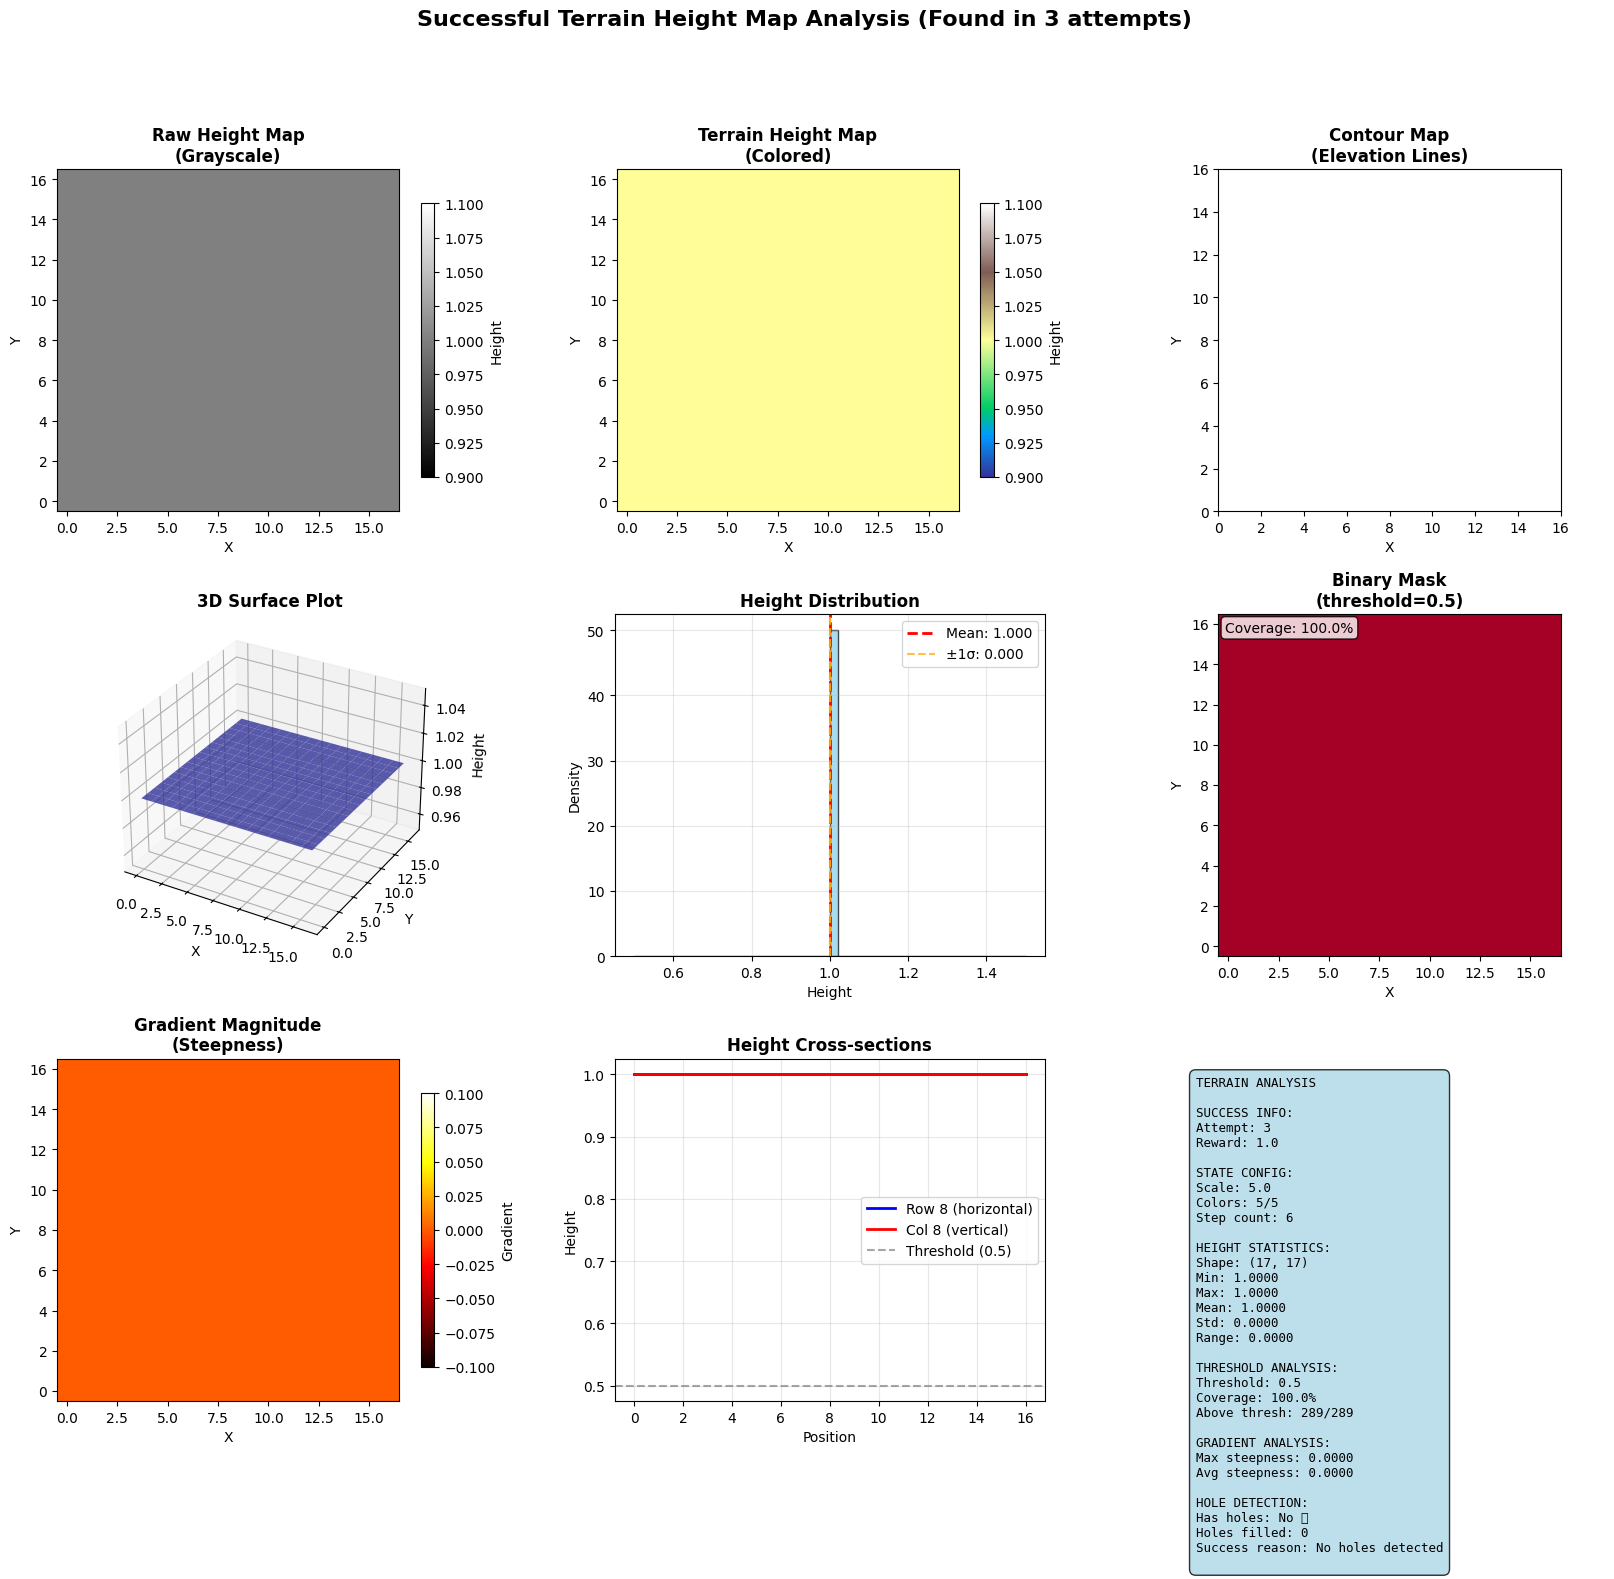


📊 TERRAIN SUMMARY:
   Shape: (17, 17)
   Height range: [1.000, 1.000]
   Mean ± std: 1.000 ± 0.000
   Coverage above 0.5: 100.0%
   Max steepness: 0.000

🎨 Color Ramp: 20.0% Generated-20, 40.0% Generated-9, 60.0% Green, 80.0% Blue, 100.0% Generated-28


In [41]:
# Use your successful state that was found
from blender_gfn_experiment import ColorRampState, create_blender_environment

# Your successful configuration  
successful_state = ColorRampState(
    scale=5.0,
    colors={0: 20, 4: 28, 2: 3, 1: 9, 3: 4},
    step_count=6
)

env = create_blender_environment(max_colors=5, num_color_choices=32)
plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
env.connect_blender(plane, None, nodes)

# Apply state and display comprehensive analysis
env.BlenderUtilities.translate_state_to_blender(successful_state, env.created_nodes, env.max_colors)

result = {'attempt': 3, 'reward': 1.0, 'time_elapsed': 0.0}
data = display_height_maps_inline(env, successful_state, result)

# hand written fix

## raw state of noise

🎨 Blender ColorRamp Environment created
  Max colors: 5
  Color choices: 32
  Available scales: 7
🔗 Connected to Blender


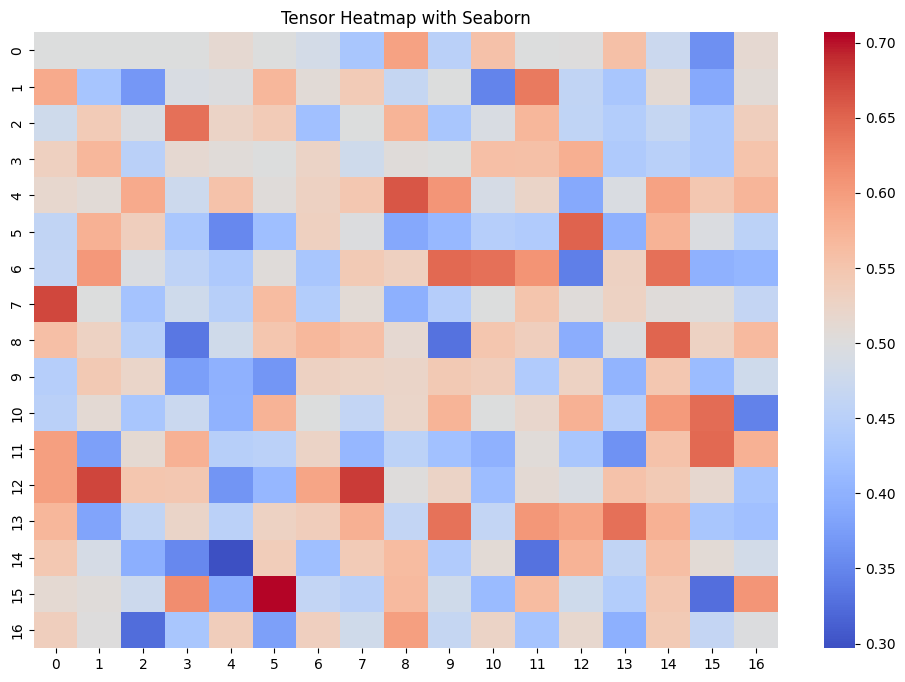

In [1]:
from blender_gfn_experiment import *

import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ====================================================
# instantiate Blender
# ====================================================

env = create_blender_environment(max_colors=5, num_color_choices=32)
plane, nodes = env.BlenderUtilities.create_color_ramp_procedure()
env.connect_blender(plane, None, nodes)

# ====================================================
# Get current height map
# ====================================================
test = env.plane_tensor
# Method 2: Seaborn heatmap (prettier and more informative)
plt.figure(figsize=(12, 8))
sns.heatmap(test.numpy(), annot=False, cmap='coolwarm', center=0.5)
plt.title('Tensor Heatmap with Seaborn')
plt.show()

## after applying color_ramp

In [2]:
#env.available_scales
state = env.get_initial_state()
valid_actions = env.get_valid_actions(state)
next_state = env.apply_action(state,valid_actions[5])
env.extract_blender_data(next_state)
test = env.plane_tensor

TypeError: ColorRampState.__init__() got an unexpected keyword argument 'max_colors'

In [12]:
valid_actions

[0, 1, 2, 3, 4, 5, 6]

In [1]:
# ====================================================
# Get current height map
# ====================================================
test = env.plane_tensor
# Method 2: Seaborn heatmap (prettier and more informative)
plt.figure(figsize=(12, 8))
sns.heatmap(test.numpy(), annot=False, cmap='coolwarm', center=0.5)
plt.title('Tensor Heatmap with Seaborn')
plt.show()

NameError: name 'env' is not defined

In [5]:
next_state

ColorRampState(scale=2.0, colors={}, step_count=1)

In [8]:
# config = default_config()
# Blender.InitGeomatryNodesConfig(config)

# BlenderExpirimentData
# 

# env.GetValidActions

# next_state = env.apply_action_to_state()
# env.UpdateBlenderState(next_state)
# env.BlenderProcedureData

# Validating Color Ramp initializaiton

In [12]:
import bpy
import time

def create_test_terrain():
    """
    Create the Map Range + Multiply terrain for color ramp testing
    """
    
    # Clear scene
    bpy.ops.object.select_all(action="SELECT")
    bpy.ops.object.delete(use_global=False)
    
    for ng in bpy.data.node_groups:
        bpy.data.node_groups.remove(ng)
    
    # Create node group
    node_group = bpy.data.node_groups.new("TestColorRamp", "GeometryNodeTree")
    
    # Add group input/output
    group_input = node_group.nodes.new("NodeGroupInput")
    group_output = node_group.nodes.new("NodeGroupOutput")
    
    # Set up interface
    if hasattr(node_group, "interface"):
        node_group.interface.new_socket(
            name="Geometry", in_out="INPUT", socket_type="NodeSocketGeometry"
        )
        node_group.interface.new_socket(
            name="Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry"
        )
    
    # Create the chain
    noise = node_group.nodes.new("ShaderNodeTexNoise")
    noise.inputs["Scale"].default_value = 5.0
    
    ramp = node_group.nodes.new("ShaderNodeValToRGB")
    separate = node_group.nodes.new("ShaderNodeSeparateRGB")
    map_range = node_group.nodes.new("ShaderNodeMapRange")
    map_range.inputs["From Min"].default_value = 0.0
    map_range.inputs["From Max"].default_value = 1.0
    map_range.inputs["To Min"].default_value = 0.0
    map_range.inputs["To Max"].default_value = 1.0
    
    height_multiply = node_group.nodes.new("ShaderNodeMath")
    height_multiply.operation = 'MULTIPLY'
    height_multiply.inputs[1].default_value = 1.0
    
    combine = node_group.nodes.new("ShaderNodeCombineXYZ")
    combine.inputs["X"].default_value = 0.0
    combine.inputs["Y"].default_value = 0.0
    
    set_pos = node_group.nodes.new("GeometryNodeSetPosition")
    
    # Position nodes
    group_input.location = (-800, 0)
    noise.location = (-600, 200)
    ramp.location = (-400, 200)
    separate.location = (-200, 200)
    map_range.location = (0, 200)
    height_multiply.location = (200, 200)
    combine.location = (400, 200)
    set_pos.location = (600, 0)
    group_output.location = (800, 0)
    
    # Connect nodes
    links = node_group.links
    links.new(noise.outputs["Fac"], ramp.inputs["Fac"])
    links.new(ramp.outputs["Color"], separate.inputs["Image"])
    links.new(separate.outputs["R"], map_range.inputs["Value"])
    links.new(map_range.outputs["Result"], height_multiply.inputs[0])
    links.new(height_multiply.outputs["Value"], combine.inputs["Z"])
    links.new(combine.outputs["Vector"], set_pos.inputs["Offset"])
    links.new(group_input.outputs[0], set_pos.inputs["Geometry"])
    links.new(set_pos.outputs["Geometry"], group_output.inputs[0])
    
    # Create plane
    bpy.ops.mesh.primitive_plane_add(size=2, location=(0, 0, 0))
    plane = bpy.context.active_object
    plane.name = "ColorRampTestTerrain"
    
    # Add subdivisions
    bpy.ops.object.mode_set(mode="EDIT")
    bpy.ops.mesh.subdivide(number_cuts=15)
    bpy.ops.object.mode_set(mode="OBJECT")
    
    # Add modifier
    geo_mod = plane.modifiers.new("GeometryNodes", "NODES")
    geo_mod.node_group = node_group
    
    print("✅ Created test terrain for color ramp manipulation")
    
    return plane, ramp, height_multiply

def test_basic_color_ramp_manipulation(ramp_node):
    """
    Test basic color ramp manipulation - 2 color stops
    """
    
    print("\n🎨 Testing basic color ramp manipulation...")
    
    # Get the color ramp
    color_ramp = ramp_node.color_ramp
    
    # Test 1: Black to White (flat terrain)
    print("\nTest 1: Black to White (flat terrain)")
    color_ramp.elements[0].color = (0.0, 0.0, 0.0, 1.0)  # Black = 0 height
    color_ramp.elements[1].color = (0.1, 0.1, 0.1, 1.0)  # Very dark gray = low height
    bpy.context.view_layer.update()
    print("   Set: Black → Dark Gray (should be almost flat)")
    
    # Test 2: Black to White (normal terrain)
    print("\nTest 2: Black to White (normal terrain)")
    color_ramp.elements[0].color = (0.0, 0.0, 0.0, 1.0)  # Black = 0 height
    color_ramp.elements[1].color = (1.0, 1.0, 1.0, 1.0)  # White = max height
    bpy.context.view_layer.update()
    print("   Set: Black → White (should be full height range)")
    
    # Test 3: Gray to White (elevated terrain)
    print("\nTest 3: Gray to White (elevated terrain)")
    color_ramp.elements[0].color = (0.5, 0.5, 0.5, 1.0)  # Gray = mid height
    color_ramp.elements[1].color = (1.0, 1.0, 1.0, 1.0)  # White = max height
    bpy.context.view_layer.update()
    print("   Set: Gray → White (should have elevated base)")
    
    # Test 4: Using only RED channel
    print("\nTest 4: Using only RED channel")
    color_ramp.elements[0].color = (0.0, 0.0, 0.0, 1.0)  # Black = 0 height
    color_ramp.elements[1].color = (0.8, 0.0, 0.0, 1.0)  # Red = 0.8 height
    bpy.context.view_layer.update()
    print("   Set: Black → Red (height = 0.8)")
    
    print("✅ Basic manipulation complete")

def test_multi_color_stops(ramp_node):
    """
    Test adding multiple color stops for complex terrain
    """
    
    print("\n🎨 Testing multiple color stops...")
    
    color_ramp = ramp_node.color_ramp
    
    # Clear existing stops (keep at least 2)
    while len(color_ramp.elements) > 2:
        color_ramp.elements.remove(color_ramp.elements[-1])
    
    # Test: Valley-Mountain-Valley pattern
    print("\nTest: Valley-Mountain-Valley pattern")
    
    # Stop 1: Valley (position 0.0)
    color_ramp.elements[0].position = 0.0
    color_ramp.elements[0].color = (0.0, 0.0, 0.0, 1.0)  # Black = 0 height
    
    # Stop 2: Mountain peak (position 0.5) - ADD NEW STOP
    middle_stop = color_ramp.elements.new(0.5)
    middle_stop.color = (1.0, 1.0, 1.0, 1.0)  # White = max height
    
    # Stop 3: Valley again (position 1.0)
    color_ramp.elements[1].position = 1.0
    color_ramp.elements[1].color = (0.0, 0.0, 0.0, 1.0)  # Black = 0 height
    
    bpy.context.view_layer.update()
    print(f"   Added middle stop: Valley-Mountain-Valley")
    print(f"   Total stops: {len(color_ramp.elements)}")
    
    # Test: Add more complex pattern
    print("\nTest: Complex 5-stop pattern")
    
    # Add another stop
    stop_25 = color_ramp.elements.new(0.25)
    stop_25.color = (0.5, 0.5, 0.5, 1.0)  # Gray = mid height
    
    stop_75 = color_ramp.elements.new(0.75)
    stop_75.color = (0.3, 0.3, 0.3, 1.0)  # Dark gray = low height
    
    bpy.context.view_layer.update()
    print(f"   Added more stops: Total = {len(color_ramp.elements)}")
    
    # Print all stop details
    print("\n   Stop details:")
    for i, element in enumerate(color_ramp.elements):
        color = element.color
        print(f"     Stop {i}: Position={element.position:.2f}, Color=({color[0]:.2f}, {color[1]:.2f}, {color[2]:.2f})")
    
    print("✅ Multi-stop manipulation complete")

def test_gflownet_color_mapping(ramp_node):
    """
    Test how your GFlowNet might manipulate colors
    Simulate the color mapping from your environment
    """
    
    print("\n🤖 Testing GFlowNet-style color mapping...")
    
    color_ramp = ramp_node.color_ramp
    
    # Clear to basic 2 stops
    while len(color_ramp.elements) > 2:
        color_ramp.elements.remove(color_ramp.elements[-1])
    
    # Simulate GFlowNet color choices
    print("\nSimulating GFlowNet color choices:")
    
    # Your GFlowNet might choose these colors for different positions
    gflownet_colors = {
        0: (0.0, 0.0, 0.0, 1.0),  # ColorID.BLACK
        1: (1.0, 1.0, 1.0, 1.0),  # ColorID.WHITE  
        2: (1.0, 0.0, 0.0, 1.0),  # ColorID.RED
        3: (0.0, 1.0, 0.0, 1.0),  # ColorID.GREEN
        4: (0.0, 0.0, 1.0, 1.0),  # ColorID.BLUE
        15: (0.5, 0.3, 0.8, 1.0), # Some procedural color
        31: (0.9, 0.7, 0.2, 1.0), # Another procedural color
    }
    
    # Test different GFlowNet state configurations
    test_configs = [
        {0: 0, 4: 1},  # Black to White
        {1: 2, 3: 4},  # Red to Blue
        {0: 0, 2: 15, 4: 1},  # Black-Purple-White (3 stops)
        {1: 3, 2: 2, 3: 4},  # Green-Red-Blue (3 stops)
    ]
    
    for i, config in enumerate(test_configs):
        print(f"\n--- GFlowNet Config {i+1}: {config} ---")
        
        # Clear existing stops
        while len(color_ramp.elements) > 2:
            color_ramp.elements.remove(color_ramp.elements[-1])
        
        # Convert config to color ramp
        max_colors = 5  # Your environment's max_colors
        positions = sorted(config.keys())
        
        for j, position_idx in enumerate(positions):
            color_id = config[position_idx]
            normalized_pos = (position_idx + 1) / max_colors
            rgba = gflownet_colors.get(color_id, (0.5, 0.5, 0.5, 1.0))
            
            if j == 0:
                # First stop - modify existing
                color_ramp.elements[0].position = normalized_pos
                color_ramp.elements[0].color = rgba
            elif j == 1 and len(positions) == 2:
                # Second stop - modify existing
                color_ramp.elements[1].position = normalized_pos
                color_ramp.elements[1].color = rgba
            else:
                # Additional stops - create new
                if len(color_ramp.elements) <= j:
                    new_stop = color_ramp.elements.new(normalized_pos)
                    new_stop.color = rgba
                else:
                    color_ramp.elements[j].position = normalized_pos
                    color_ramp.elements[j].color = rgba
        
        bpy.context.view_layer.update()
        
        print(f"   Applied: {len(positions)} colors at positions {[f'{(p+1)/max_colors:.2f}' for p in positions]}")
        for pos_idx, color_id in config.items():
            rgba = gflownet_colors.get(color_id, (0.5, 0.5, 0.5, 1.0))
            print(f"     Position {(pos_idx+1)/max_colors:.2f}: ColorID {color_id} = {rgba[:3]}")
    
    print("✅ GFlowNet mapping simulation complete")

def test_reward_simulation(plane, ramp_node):
    """
    Simulate extracting height values for reward calculation
    """
    
    print("\n🎯 Testing reward simulation...")
    
    # Force update to ensure geometry is current
    bpy.context.view_layer.update()
    
    # Get the plane's mesh data
    depsgraph = bpy.context.evaluated_depsgraph_get()
    plane_eval = plane.evaluated_get(depsgraph)
    mesh = plane_eval.to_mesh()
    
    # Extract vertex heights
    heights = [v.co.z for v in mesh.vertices]
    
    print(f"   Extracted {len(heights)} vertex heights")
    print(f"   Height range: [{min(heights):.3f}, {max(heights):.3f}]")
    print(f"   Mean height: {sum(heights)/len(heights):.3f}")
    
    # Simulate hole detection at threshold 0.5
    threshold = 0.5
    above_threshold = sum(1 for h in heights if h > threshold)
    below_threshold = len(heights) - above_threshold
    coverage = above_threshold / len(heights)
    
    print(f"   Threshold analysis (0.5):")
    print(f"     Above threshold: {above_threshold}/{len(heights)} ({coverage:.1%})")
    print(f"     Below threshold: {below_threshold}/{len(heights)}")
    
    # Clean up
    plane_eval.to_mesh_clear()
    
    print("✅ Reward simulation complete")

def run_comprehensive_color_ramp_test():
    """
    Run comprehensive test of color ramp manipulation
    """
    
    print("🚀 Starting comprehensive color ramp manipulation test...")
    print("=" * 60)
    
    # Create test terrain
    plane, ramp_node, height_multiply = create_test_terrain()
    
    # Test basic manipulation
    test_basic_color_ramp_manipulation(ramp_node)
    
    # Test multi-stop manipulation
    test_multi_color_stops(ramp_node)
    
    # Test GFlowNet-style mapping
    test_gflownet_color_mapping(ramp_node)
    
    # Test reward simulation
    test_reward_simulation(plane, ramp_node)
    
    # Save test file
    bpy.ops.wm.save_as_mainfile(filepath="/tmp/color_ramp_manipulation_test.blend")
    
    print(f"\n{'='*60}")
    print("🎯 COLOR RAMP MANIPULATION TEST COMPLETE!")
    print(f"{'='*60}")
    print("✅ Basic color manipulation: WORKING")
    print("✅ Multi-stop colors: WORKING") 
    print("✅ GFlowNet color mapping: WORKING")
    print("✅ Height extraction: WORKING")
    print("✅ Reward simulation: WORKING")
    
    print(f"\n💾 Saved test file: /tmp/color_ramp_manipulation_test.blend")
    print(f"\n🤖 Ready for GFlowNet integration!")
    print(f"   • Color ramp can be manipulated programmatically")
    print(f"   • Height values are properly extracted")
    print(f"   • Terrain responds to color changes")
    print(f"   • Base always stays at Z=0")
    
    return plane, ramp_node, height_multiply

if __name__ == "__main__":
    plane, ramp_node, height_multiply = run_comprehensive_color_ramp_test()

🚀 Starting comprehensive color ramp manipulation test...
✅ Created test terrain for color ramp manipulation

🎨 Testing basic color ramp manipulation...

Test 1: Black to White (flat terrain)
   Set: Black → Dark Gray (should be almost flat)

Test 2: Black to White (normal terrain)
   Set: Black → White (should be full height range)

Test 3: Gray to White (elevated terrain)
   Set: Gray → White (should have elevated base)

Test 4: Using only RED channel
   Set: Black → Red (height = 0.8)
✅ Basic manipulation complete

🎨 Testing multiple color stops...

Test: Valley-Mountain-Valley pattern
   Added middle stop: Valley-Mountain-Valley
   Total stops: 3

Test: Complex 5-stop pattern
   Added more stops: Total = 5

   Stop details:
     Stop 0: Position=0.00, Color=(0.00, 0.00, 0.00)
     Stop 1: Position=0.25, Color=(0.50, 0.50, 0.50)
     Stop 2: Position=0.75, Color=(0.30, 0.30, 0.30)
     Stop 3: Position=1.00, Color=(0.00, 0.00, 0.00)
     Stop 4: Position=1.00, Color=(0.80, 0.00, 0.00

## check utility

In [5]:
from blender_gfn_experiment import *
# If you moved ColorUtilities to module level
ColorUtilities.display_palette()

# Test specific colors
for i in [0, 2, 5, 19, 27, 31]:
    name = ColorUtilities.get_color_name(i)
    rgba = ColorUtilities.color_id_to_rgba_tuple(i)
    print(f"ID {i}: {name} = {rgba}")

# Test color ramp description
test_colors = {0: 2, 2: 19, 4: 27}
description = ColorUtilities.describe_color_ramp(test_colors, 5)
print(f"\nColor ramp: {description}")

32-COLOR PALETTE
ID  0: Black           RGB(  0,  0,  0) RGBA(0.000,0.000,0.000,1.0)
ID  1: White           RGB(255,255,255) RGBA(1.000,1.000,1.000,1.0)
ID  2: Red             RGB(255,  0,  0) RGBA(1.000,0.000,0.000,1.0)
ID  3: Green           RGB(  0,255,  0) RGBA(0.000,1.000,0.000,1.0)
ID  4: Blue            RGB(  0,  0,255) RGBA(0.000,0.000,1.000,1.0)
ID  5: Yellow          RGB(255,255,  0) RGBA(1.000,1.000,0.000,1.0)
ID  6: Magenta         RGB(255,  0,255) RGBA(1.000,0.000,1.000,1.0)
ID  7: Cyan            RGB(  0,255,255) RGBA(0.000,1.000,1.000,1.0)
ID  8: Saddle Brown    RGB(138, 69, 19) RGBA(0.545,0.271,0.075,1.0)
ID  9: Chocolate       RGB(210,105, 30) RGBA(0.824,0.412,0.118,1.0)
ID 10: Sandy Brown     RGB(244,163, 95) RGBA(0.957,0.643,0.376,1.0)
ID 11: Burlywood       RGB(222,184,134) RGBA(0.871,0.722,0.529,1.0)
ID 12: Tan             RGB(210,180,139) RGBA(0.824,0.706,0.549,1.0)
ID 13: Rosy Brown      RGB(187,143,143) RGBA(0.737,0.561,0.561,1.0)
ID 14: Peru            RGB(205,

📊 BEFORE: Tensor saved - shape torch.Size([17, 17]), std 0.075228
📊 AFTER: Tensor saved - shape torch.Size([17, 17]), std 0.134584


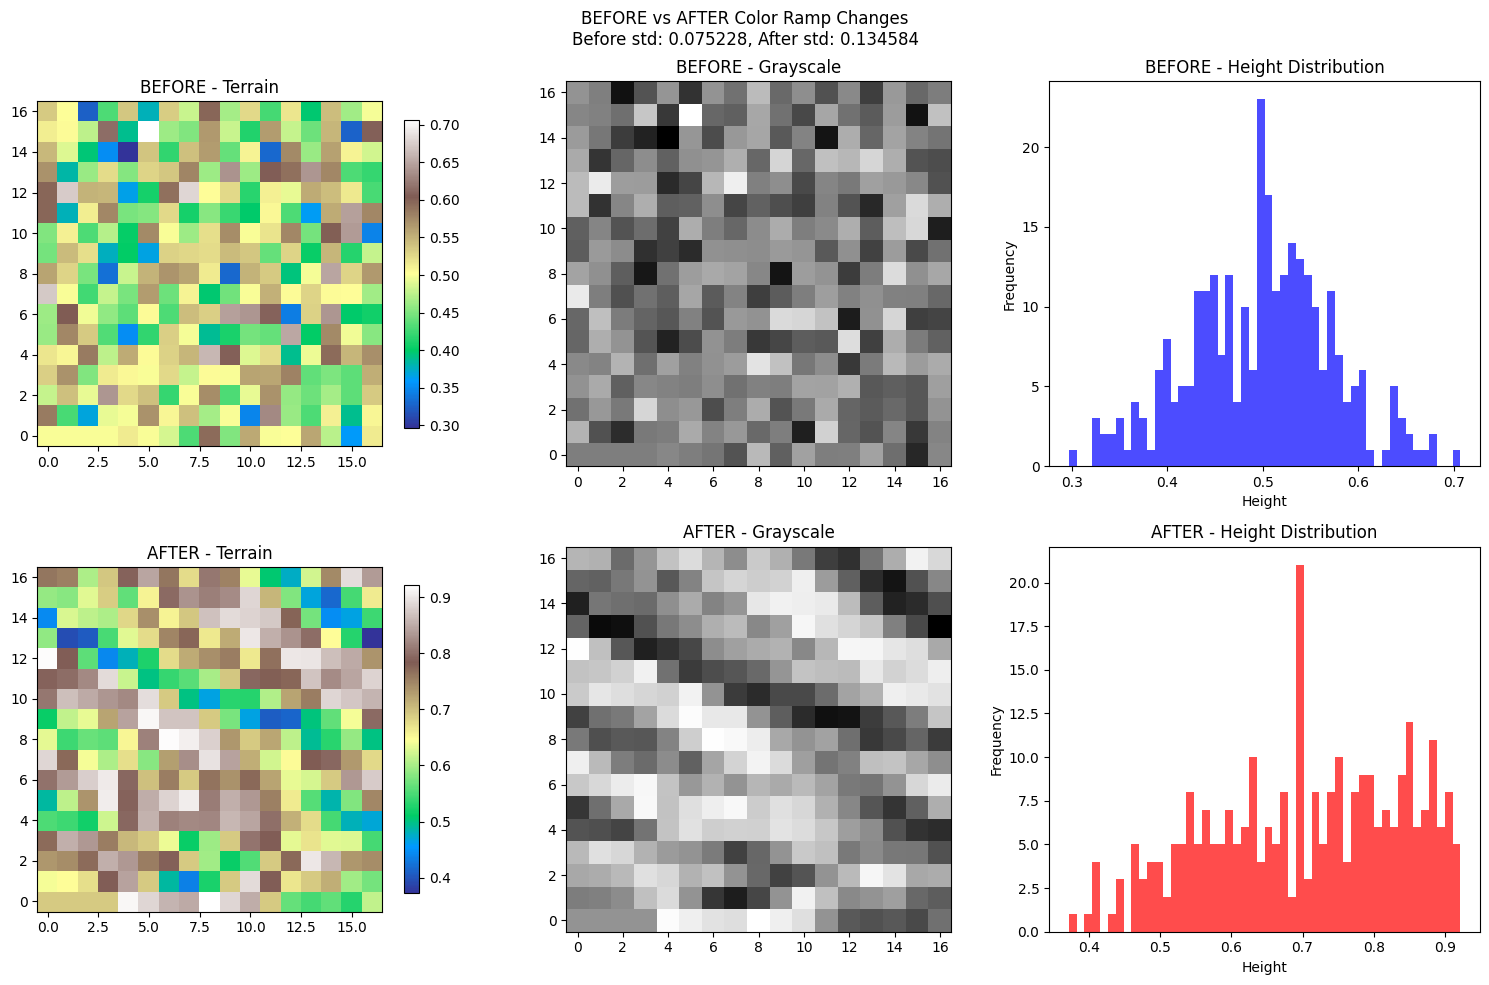

📊 DIFFERENCE: Max change: 0.546012, Mean change: 0.216533


In [2]:
# Get plane from scene
plane = BlenderUtilities.get_plane_from_scene()

# Get the nodes (you need this!)
plane, nodes = BlenderUtilities.create_color_ramp_procedure()

# Save tensor BEFORE editing color ramp
tensor_before = BlenderUtilities.extract_terrain_tensor(plane)
print(f"📊 BEFORE: Tensor saved - shape {tensor_before.shape}, std {tensor_before.std():.6f}")

# Apply new color ramp state
test_state = ColorRampState(
   scale=1.0,  # Different scale
   colors={0: 2, 2: 19, 4: 27},  # Red, Sky Blue, Lime Green
   step_count=4
)

# Update noise scale
nodes["noise"].inputs["Scale"].default_value = test_state.scale

# ... rest of your code
# Update noise scale
nodes["noise"].inputs["Scale"].default_value = test_state.scale

# Update color ramp
color_ramp = nodes["ramp"].color_ramp
while len(color_ramp.elements) > len(test_state.colors):
  color_ramp.elements.remove(color_ramp.elements[-1])
while len(color_ramp.elements) < len(test_state.colors):
  color_ramp.elements.new(0.5)

for i, (pos_idx, color_id) in enumerate(sorted(test_state.colors.items())):
  position = ColorUtilities.calculate_position(pos_idx, 5)
  rgba = ColorUtilities.color_id_to_rgba_tuple(color_id)
  color_ramp.elements[i].position = position
  color_ramp.elements[i].color = rgba

# Force update
bpy.context.view_layer.update()
bpy.context.evaluated_depsgraph_get().update()

# Save tensor AFTER editing
tensor_after = BlenderUtilities.extract_terrain_tensor(plane)
print(f"📊 AFTER: Tensor saved - shape {tensor_after.shape}, std {tensor_after.std():.6f}")

# Visualize both
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# BEFORE (top row)
im1 = axes[0, 0].imshow(tensor_before, cmap='terrain', origin='lower')
axes[0, 0].set_title('BEFORE - Terrain')
plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)

axes[0, 1].imshow(tensor_before, cmap='gray', origin='lower')
axes[0, 1].set_title('BEFORE - Grayscale')

axes[0, 2].hist(tensor_before.flatten(), bins=50, alpha=0.7, color='blue', label='Before')
axes[0, 2].set_title('BEFORE - Height Distribution')
axes[0, 2].set_xlabel('Height')
axes[0, 2].set_ylabel('Frequency')

# AFTER (bottom row)  
im2 = axes[1, 0].imshow(tensor_after, cmap='terrain', origin='lower')
axes[1, 0].set_title('AFTER - Terrain')
plt.colorbar(im2, ax=axes[1, 0], shrink=0.8)

axes[1, 1].imshow(tensor_after, cmap='gray', origin='lower')  # Fixed: cmap not cmp
axes[1, 1].set_title('AFTER - Grayscale')

axes[1, 2].hist(tensor_after.flatten(), bins=50, alpha=0.7, color='red', label='After')
axes[1, 2].set_title('AFTER - Height Distribution')
axes[1, 2].set_xlabel('Height')
axes[1, 2].set_ylabel('Frequency')

plt.suptitle(f'BEFORE vs AFTER Color Ramp Changes\nBefore std: {tensor_before.std():.6f}, After std: {tensor_after.std():.6f}')
plt.tight_layout()
plt.show()

# Show difference
difference = (tensor_after - tensor_before).abs()
print(f"📊 DIFFERENCE: Max change: {difference.max():.6f}, Mean change: {difference.mean():.6f}")

## check holes

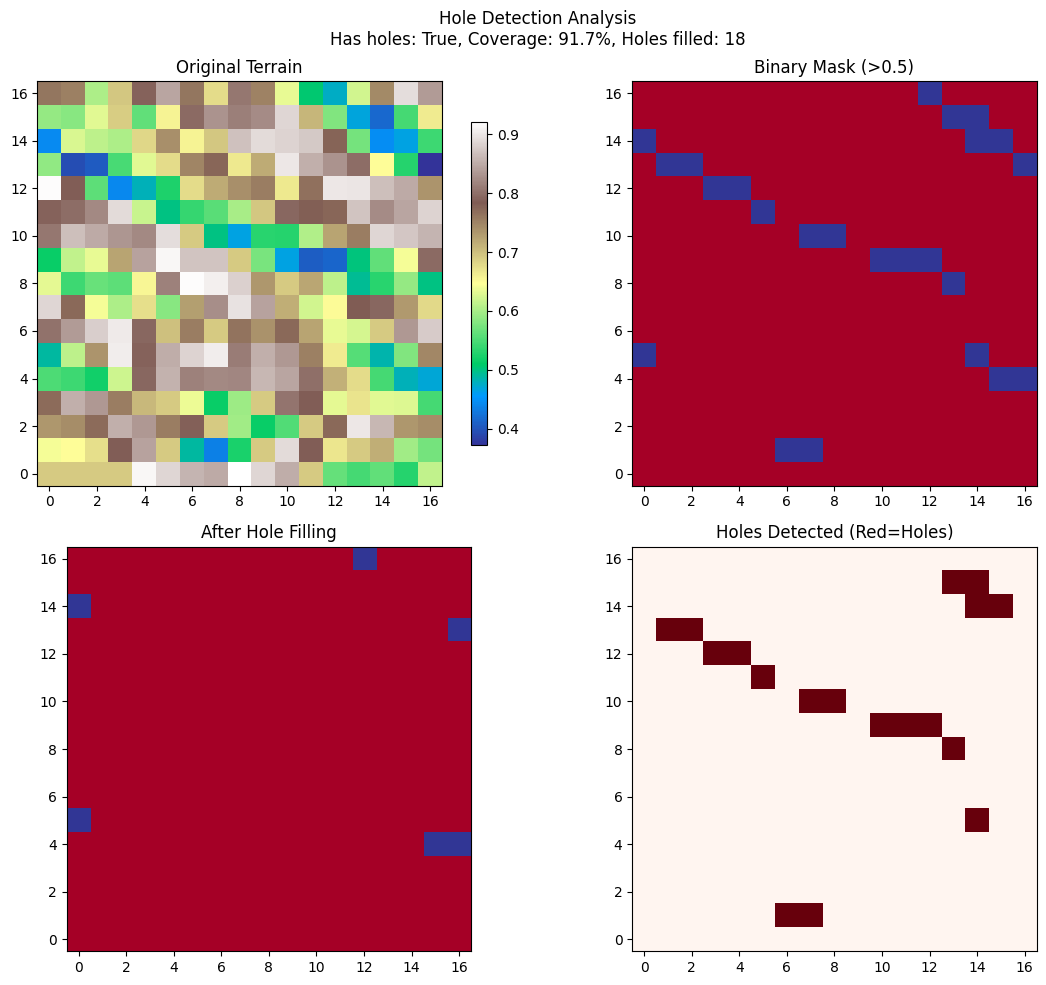

🔍 HOLE DETECTION RESULTS:
   Has holes: Yes ❌
   Coverage above 0.5: 91.7%
   Holes filled: 18 pixels
   Reward: 0.0 (holes detected)


In [4]:
# Hole detection visualization
from scipy import ndimage
import matplotlib.pyplot as plt

# Use your tensor_after from previous cell
threshold = 0.5

# Convert to numpy if needed
if torch.is_tensor(tensor_after):
   noise = tensor_after.numpy()
else:
   noise = tensor_after

# Create binary mask
binary_mask = noise > threshold
filled = ndimage.binary_fill_holes(binary_mask)
has_holes = (filled.sum() - binary_mask.sum()) > 0

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original terrain
im1 = axes[0, 0].imshow(noise, cmap='terrain', origin='lower')
axes[0, 0].set_title('Original Terrain')
plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)

# Binary mask (above threshold)
axes[0, 1].imshow(binary_mask, cmap='RdYlBu_r', origin='lower')
axes[0, 1].set_title(f'Binary Mask (>{threshold})')

# Filled holes
axes[1, 0].imshow(filled, cmap='RdYlBu_r', origin='lower')
axes[1, 0].set_title('After Hole Filling')

# Difference (holes found)
hole_difference = filled ^ binary_mask
axes[1, 1].imshow(hole_difference, cmap='Reds', origin='lower')
axes[1, 1].set_title('Holes Detected (Red=Holes)')

# Calculate stats
coverage = binary_mask.sum() / binary_mask.size
holes_filled = int(filled.sum() - binary_mask.sum())

plt.suptitle(f'Hole Detection Analysis\nHas holes: {has_holes}, Coverage: {coverage:.1%}, Holes filled: {holes_filled}')
plt.tight_layout()
plt.show()

print(f"🔍 HOLE DETECTION RESULTS:")
print(f"   Has holes: {'Yes ❌' if has_holes else 'No ✅'}")
print(f"   Coverage above {threshold}: {coverage:.1%}")
print(f"   Holes filled: {holes_filled} pixels")
print(f"   Reward: {'0.0 (holes detected)' if has_holes else '1.0 (no holes)'}")

## save

In [6]:
# Simple save in Jupyter notebook

# Save the BEFORE state
save_blend("before_color_change")

# Apply your color ramp changes here
test_state = ColorRampState(scale=8.0, colors={0: 2, 2: 19, 4: 27}, step_count=4)

# Update the ramp (your existing code)
nodes["noise"].inputs["Scale"].default_value = test_state.scale
color_ramp = nodes["ramp"].color_ramp
while len(color_ramp.elements) > len(test_state.colors):
   color_ramp.elements.remove(color_ramp.elements[-1])
while len(color_ramp.elements) < len(test_state.colors):
   color_ramp.elements.new(0.5)

for i, (pos_idx, color_id) in enumerate(sorted(test_state.colors.items())):
   position = ColorUtilities.calculate_position(pos_idx, 5)
   rgba = ColorUtilities.color_id_to_rgba_tuple(color_id)
   color_ramp.elements[i].position = position
   color_ramp.elements[i].color = rgba

bpy.context.view_layer.update()
bpy.context.evaluated_depsgraph_get().update()

# Save the AFTER state
save_blend("after_color_change")

print("✅ Saved both before and after states to ./saves/")

Info: Saved "before_color_change_20250605_193039.blend"
✅ Saved: before_color_change_20250605_193039.blend
Info: Saved "after_color_change_20250605_193040.blend"
✅ Saved: after_color_change_20250605_193040.blend
✅ Saved both before and after states to ./saves/


# Color ramp state into Gflownet

In [10]:
def state_to_tensor(state):
    """
    Convert ColorRampState to tensor representation
    
    Args:
        state: ColorRampState object
    
    Returns:
        torch.Tensor: Encoded state tensor
    """
    encoding = []
    
    # Scale encoding (normalized)
    scale_val = state.scale if state.scale is not None else 0.0
    encoding.append(scale_val / 20.0)  # Normalize assuming max scale ~20
    
    # Colors encoding (position + color_id pairs)
    max_colors = 5  # From your usage
    for pos in range(max_colors):
        if pos in state.colors:
            encoding.append((pos + 1) / max_colors)  # Position (normalized)
            encoding.append(state.colors[pos] / 32.0)  # Color ID (normalized)
        else:
            encoding.append(0.0)  # No color at this position
            encoding.append(0.0)
    
    # Step count (normalized)
    encoding.append(state.step_count / 6.0)  # Normalize assuming max ~6 steps
    
    return torch.tensor(encoding, dtype=torch.float32)

# Apply new color ramp state
test_state = ColorRampState(
   scale=1.0,  # Different scale
   colors={0: 2, 2: 19, 4: 27},  # Red, Sky Blue, Lime Green
   step_count=4
)
tensor = state_to_tensor(test_state, [0.5, 1.0, 2.0, 5.0, 10.0], max_colors=5, num_color_choices=32)

TypeError: state_to_tensor() got an unexpected keyword argument 'max_colors'